In [2]:
pip install QuantLib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 8.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# SWAP Types
1. Interest rate
2. Currency
3. Commodity
4. Credit default
5. Equity swaps

# Vanilla interest rate swap (IRS) where one party pays a fixed rate and the other pays a floating rate.

In [ ]:
import numpy as np

def calculate_swap_npv(fixed_rate, floating_rates, notional, discount_factors, payment_dates):
    """
    Calculate the NPV of an interest rate swap.

    Returns:
        dict: NPV of the fixed leg, floating leg, and net NPV.
    """
    # Validate input dimensions
    assert len(payment_dates) == len(discount_factors) == len(floating_rates), \

    
    # Calculate cash flows
    fixed_leg_cash_flows = [fixed_rate * notional * (payment_dates[i] - payment_dates[i-1] if i > 0 else payment_dates[i]) 
                            for i in range(len(payment_dates))]
    floating_leg_cash_flows = [floating_rates[i] * notional * (payment_dates[i] - payment_dates[i-1] if i > 0 else payment_dates[i]) 
                               for i in range(len(payment_dates))]
    
    # Discounted cash flows
    fixed_leg_present_value = sum(cf * df for cf, df in zip(fixed_leg_cash_flows, discount_factors))
    floating_leg_present_value = sum(cf * df for cf, df in zip(floating_leg_cash_flows, discount_factors))
    
    # Net NPV
    net_npv = floating_leg_present_value - fixed_leg_present_value
    
    return {
        "Fixed Leg NPV": fixed_leg_present_value,
        "Floating Leg NPV": floating_leg_present_value,
        "Net NPV": net_npv
    }

# Example inputs
fixed_rate = 0.025  # 2.5%
floating_rates = [0.023, 0.024, 0.026, 0.027]  # Example forward rates
notional = 1_000_000  # Notional amount in currency units
discount_factors = [0.99, 0.97, 0.95, 0.93]  # Discount factors
payment_dates = [0.25, 0.5, 0.75, 1.0]  # Payment times in years

# Calculate the NPV
npv = calculate_swap_npv(fixed_rate, floating_rates, notional, discount_factors, payment_dates)

# Print results
for leg, value in npv.items():
    print(f"{leg}: {value:,.2f}")

Fixed Leg NPV: 24,000.00
Floating Leg NPV: 23,965.00
Net NPV: -35.00


Improvements:

1. Use Actual Market Curves

	•	Forward Curve: Use a forward rate curve constructed from market data (e.g., LIBOR/SOFR swap curves or OIS curves). These rates reflect the expected floating payments.
	•	Discount Curve: Derive the discount factors from the risk-free or OIS curve to discount cash flows more accurately.

Action:
	•	Fetch or construct these curves using market data from sources like Bloomberg, Reuters, or Quandl.
	•	Interpolate the curves to match payment dates.

In [2]:
import numpy as np
from scipy.interpolate import interp1d

def construct_forward_curve(market_data):
    """
    Construct a forward rate curve using market data.
    Interpolates rates for the desired payment dates.
    """
    times = market_data['times']  # e.g., [0.25, 0.5, 1.0, 2.0]
    rates = market_data['rates']  # e.g., [0.02, 0.021, 0.022, 0.025]
    forward_curve = interp1d(times, rates, kind='cubic', fill_value="extrapolate")
    return forward_curve

def construct_discount_curve(market_data):
    """
    Construct a discount factor curve using risk-free rates.
    Interpolates discount factors for the desired payment dates.
    """
    times = market_data['times']  # e.g., [0.25, 0.5, 1.0, 2.0]
    discount_factors = market_data['discount_factors']  # e.g., [0.99, 0.97, 0.95, 0.92]
    discount_curve = interp1d(times, discount_factors, kind='linear', fill_value="extrapolate")
    return discount_curve

def calculate_swap_npv(fixed_rate, notional, payment_dates, forward_curve, discount_curve):
    """
    Calculate the NPV of an interest rate swap using interpolated curves.
    """
    # Interpolated forward rates and discount factors
    floating_rates = forward_curve(payment_dates)
    discount_factors = discount_curve(payment_dates)

    # Cash flows for fixed and floating legs
    fixed_leg_cash_flows = [fixed_rate * notional * (payment_dates[i] - payment_dates[i - 1] if i > 0 else payment_dates[i]) 
                            for i in range(len(payment_dates))]
    floating_leg_cash_flows = [floating_rates[i] * notional * (payment_dates[i] - payment_dates[i - 1] if i > 0 else payment_dates[i]) 
                               for i in range(len(payment_dates))]

    # Discounted present values
    fixed_leg_present_value = sum(cf * df for cf, df in zip(fixed_leg_cash_flows, discount_factors))
    floating_leg_present_value = sum(cf * df for cf, df in zip(floating_leg_cash_flows, discount_factors))

    # Net NPV
    net_npv = floating_leg_present_value - fixed_leg_present_value

    return {
        "Fixed Leg NPV": fixed_leg_present_value,
        "Floating Leg NPV": floating_leg_present_value,
        "Net NPV": net_npv
    }

# Example market data
forward_market_data = {
    'times': [0.25, 0.5, 1.0, 2.0],  # in years
    'rates': [0.02, 0.021, 0.022, 0.025]  # forward rates
}
discount_market_data = {
    'times': [0.25, 0.5, 1.0, 2.0],  # in years
    'discount_factors': [0.99, 0.97, 0.95, 0.92]  # discount factors
}

# Construct curves
forward_curve = construct_forward_curve(forward_market_data)
discount_curve = construct_discount_curve(discount_market_data)

# Example inputs
fixed_rate = 0.025  # 2.5%
notional = 1_000_000  # Notional amount
payment_dates = [0.25, 0.5, 0.75, 1.0]  # Payment times in years

# Calculate NPV
npv = calculate_swap_npv(fixed_rate, notional, payment_dates, forward_curve, discount_curve)

# Print results
for leg, value in npv.items():
    print(f"{leg}: {value:,.2f}")

Fixed Leg NPV: 24,187.50
Floating Leg NPV: 20,453.21
Net NPV: -3,734.29


2. Day Count Conventions (Doesnt work yet)

	•	Real swaps use specific day count conventions (e.g., 30/360, Actual/360, Actual/Actual) for calculating interest payments.
	•	Adjust cash flow calculations to account for the day count basis.

Action:
	•	Use libraries like QuantLib to handle day count conventions programmatically.

3. Floating Rate Resets

	•	Floating payments are based on rates observed at specific reset dates, often slightly before the actual payment date.
	•	Include the reset dates and ensure the forward curve is used accurately to predict these rates.

Action:
	•	Incorporate logic to calculate cash flows using reset dates instead of payment dates.

In [6]:
import numpy as np
from scipy.interpolate import interp1d
from datetime import datetime, timedelta

def construct_forward_curve(market_data):
    """
    Construct a forward rate curve using market data.
    Interpolates rates for the desired dates.
    """
    times = market_data['times']
    rates = market_data['rates']
    forward_curve = interp1d(times, rates, kind='cubic', fill_value="extrapolate")
    return forward_curve

def construct_discount_curve(market_data):
    """
    Construct a discount factor curve using risk-free rates.
    Interpolates discount factors for the desired dates.
    """
    times = market_data['times']
    discount_factors = market_data['discount_factors']
    discount_curve = interp1d(times, discount_factors, kind='linear', fill_value="extrapolate")
    return discount_curve

def calculate_swap_npv(fixed_rate, notional, payment_dates, reset_dates, forward_curve, discount_curve):
    """
    Calculate the NPV of an interest rate swap using interpolated curves and reset dates.
    """
    # Interpolated forward rates and discount factors
    floating_rates = forward_curve(reset_dates)
    discount_factors = discount_curve(payment_dates)

    # Cash flows for fixed and floating legs
    fixed_leg_cash_flows = [fixed_rate * notional * (payment_dates[i] - payment_dates[i - 1] if i > 0 else payment_dates[i]) 
                            for i in range(len(payment_dates))]
    
    floating_leg_cash_flows = [floating_rates[i] * notional * (payment_dates[i] - payment_dates[i - 1] if i > 0 else payment_dates[i]) 
                               for i in range(len(payment_dates))]

    # Discounted present values
    fixed_leg_present_value = sum(cf * df for cf, df in zip(fixed_leg_cash_flows, discount_factors))
    floating_leg_present_value = sum(cf * df for cf, df in zip(floating_leg_cash_flows, discount_factors))

    # Net NPV
    net_npv = floating_leg_present_value - fixed_leg_present_value

    return {
        "Fixed Leg NPV": fixed_leg_present_value,
        "Floating Leg NPV": floating_leg_present_value,
        "Net NPV": net_npv
    }

# Generate random market data
np.random.seed(42)  # for reproducibility
times = np.sort(np.random.uniform(0, 5, 10))
forward_rates = np.cumsum(np.random.normal(0.001, 0.0005, 10)) + 0.02  # starting from 2%
discount_factors = np.exp(-times * np.random.uniform(0.01, 0.03, 10))

forward_market_data = {
    'times': times,
    'rates': forward_rates
}
discount_market_data = {
    'times': times,
    'discount_factors': discount_factors
}

current_date = datetime(2024, 11, 22)
day_count = 365.25  # using average day count for simplicity

def date_to_year_fraction(date):
    return (date - current_date).days / day_count

# Example inputs
fixed_rate = 0.025  # 2.5%
notional = 1_000_000  # Notional amount
start_date = current_date
payment_dates = [start_date + timedelta(days=90*i) for i in range(1, 5)]
reset_dates = [date - timedelta(days=2) for date in payment_dates]

# Convert dates to year fractions
payment_dates_yf = [date_to_year_fraction(date) for date in payment_dates]
reset_dates_yf = [date_to_year_fraction(date) for date in reset_dates]

# Calculate NPV
npv = calculate_swap_npv(fixed_rate, notional, payment_dates_yf, reset_dates_yf, forward_curve, discount_curve)

# Print results
print("Swap Valuation Results:")
for leg, value in npv.items():
    print(f"{leg}: ${value:,.2f}")

print("\nDetails:")
print(f"Payment Dates: {payment_dates}")
print(f"Reset Dates: {reset_dates}")
print(f"Forward Rates at Reset: {forward_curve(reset_dates_yf)}")
print(f"Discount Factors: {discount_curve(payment_dates_yf)}")

Swap Valuation Results:
Fixed Leg NPV: $24,359.83
Floating Leg NPV: $36,145.57
Net NPV: $11,785.75

Details:
Payment Dates: [datetime.datetime(2025, 2, 20, 0, 0), datetime.datetime(2025, 5, 21, 0, 0), datetime.datetime(2025, 8, 19, 0, 0), datetime.datetime(2025, 11, 17, 0, 0)]
Reset Dates: [datetime.datetime(2025, 2, 18, 0, 0), datetime.datetime(2025, 5, 19, 0, 0), datetime.datetime(2025, 8, 17, 0, 0), datetime.datetime(2025, 11, 15, 0, 0)]
Forward Rates at Reset: [ 1.04830293 -1.52662469 -0.28956195  0.9215208 ]
Discount Factors: [0.99620364 0.99175756 0.98731148 0.97913905]


4. Spread Adjustments

	•	Many floating legs have an added spread (e.g., LIBOR + 50 bps). Incorporate this adjustment into the floating rate cash flows.

Action:
	•	Include a spread parameter when calculating floating cash flows.

In [7]:
import numpy as np
from scipy.interpolate import interp1d
from datetime import datetime, timedelta

def construct_forward_curve(market_data):
    """
    Construct a forward rate curve using market data.
    Interpolates rates for the desired dates.
    """
    times = market_data['times']
    rates = market_data['rates']
    forward_curve = interp1d(times, rates, kind='cubic', fill_value="extrapolate")
    return forward_curve

def construct_discount_curve(market_data):
    """
    Construct a discount factor curve using risk-free rates.
    Interpolates discount factors for the desired dates.
    """
    times = market_data['times']
    discount_factors = market_data['discount_factors']
    discount_curve = interp1d(times, discount_factors, kind='linear', fill_value="extrapolate")
    return discount_curve

def calculate_swap_npv(fixed_rate, notional, payment_dates, reset_dates, forward_curve, discount_curve, floating_spread):
    """
    Calculate the NPV of an interest rate swap using interpolated curves, reset dates, and floating rate spread.
    """
    # Interpolated forward rates and discount factors
    floating_rates = forward_curve(reset_dates) + floating_spread
    discount_factors = discount_curve(payment_dates)

    # Cash flows for fixed and floating legs
    fixed_leg_cash_flows = [fixed_rate * notional * (payment_dates[i] - payment_dates[i - 1] if i > 0 else payment_dates[i]) 
                            for i in range(len(payment_dates))]
    
    floating_leg_cash_flows = [floating_rates[i] * notional * (payment_dates[i] - payment_dates[i - 1] if i > 0 else payment_dates[i]) 
                               for i in range(len(payment_dates))]

    # Discounted present values
    fixed_leg_present_value = sum(cf * df for cf, df in zip(fixed_leg_cash_flows, discount_factors))
    floating_leg_present_value = sum(cf * df for cf, df in zip(floating_leg_cash_flows, discount_factors))

    # Net NPV
    net_npv = floating_leg_present_value - fixed_leg_present_value

    return {
        "Fixed Leg NPV": fixed_leg_present_value,
        "Floating Leg NPV": floating_leg_present_value,
        "Net NPV": net_npv
    }

# Generate random LIBOR data
np.random.seed(42)  # for reproducibility
times = np.sort(np.random.uniform(0, 5, 10))
libor_rates = np.cumsum(np.random.normal(0.0005, 0.0002, 10)) + 0.015  # starting from 1.5%
discount_factors = np.exp(-times * np.random.uniform(0.01, 0.03, 10))

forward_market_data = {
    'times': times,
    'rates': libor_rates
}
discount_market_data = {
    'times': times,
    'discount_factors': discount_factors
}

# Construct curves
forward_curve = construct_forward_curve(forward_market_data)
discount_curve = construct_discount_curve(discount_market_data)

# Example inputs
fixed_rate = 0.025  # 2.5%
notional = 1_000_000  # Notional amount
floating_spread = 0.005  # 50 bps spread
current_date = datetime(2024, 11, 22)
day_count = 365.25  # using average day count for simplicity

def date_to_year_fraction(date):
    return (date - current_date).days / day_count

start_date = current_date
payment_dates = [start_date + timedelta(days=90*i) for i in range(1, 5)]
reset_dates = [date - timedelta(days=2) for date in payment_dates]

# Convert dates to year fractions
payment_dates_yf = [date_to_year_fraction(date) for date in payment_dates]
reset_dates_yf = [date_to_year_fraction(date) for date in reset_dates]

# Calculate NPV
npv = calculate_swap_npv(fixed_rate, notional, payment_dates_yf, reset_dates_yf, forward_curve, discount_curve, floating_spread)

# Print results
print("Swap Valuation Results:")
for leg, value in npv.items():
    print(f"{leg}: ${value:,.2f}")

print("\nDetails:")
print(f"Payment Dates: {payment_dates}")
print(f"Reset Dates: {reset_dates}")
print(f"LIBOR Rates at Reset: {forward_curve(reset_dates_yf)}")
print(f"Floating Rates (LIBOR + Spread): {forward_curve(reset_dates_yf) + floating_spread}")
print(f"Discount Factors: {discount_curve(payment_dates_yf)}")
print(f"Floating Spread: {floating_spread:.2%}")

Swap Valuation Results:
Fixed Leg NPV: $24,359.83
Floating Leg NPV: $28,297.47
Net NPV: $3,937.64

Details:
Payment Dates: [datetime.datetime(2025, 2, 20, 0, 0), datetime.datetime(2025, 5, 21, 0, 0), datetime.datetime(2025, 8, 19, 0, 0), datetime.datetime(2025, 11, 17, 0, 0)]
Reset Dates: [datetime.datetime(2025, 2, 18, 0, 0), datetime.datetime(2025, 5, 19, 0, 0), datetime.datetime(2025, 8, 17, 0, 0), datetime.datetime(2025, 11, 15, 0, 0)]
LIBOR Rates at Reset: [ 0.56013454 -0.80494729 -0.14917864  0.49294202]
Floating Rates (LIBOR + Spread): [ 0.56513454 -0.79994729 -0.14417864  0.49794202]
Discount Factors: [0.99620364 0.99175756 0.98731148 0.97913905]
Floating Spread: 0.50%


5. Curve Bootstrapping

	•	Construct the forward and discount curves via bootstrapping from real swap rates, deposit rates, and other instruments.

Action:
	•	Use bootstrapping algorithms or leverage a library like QuantLib to construct curves.

6. Stochastic Modeling

	•	Introduce stochastic models (e.g., Hull-White, Black-Scholes) to model the evolution of interest rates and improve the valuation of floating cash flows.

Action:
	•	Implement a short-rate model for simulating interest rate paths.
	•	Monte Carlo simulations can model the floating leg more accurately.

In [11]:
import numpy as np
from scipy.interpolate import interp1d
from datetime import datetime, timedelta

def construct_forward_curve(market_data):
    times = market_data['times']
    rates = market_data['rates']
    forward_curve = interp1d(times, rates, kind='cubic', fill_value="extrapolate")
    return forward_curve

def construct_discount_curve(market_data):
    times = market_data['times']
    discount_factors = market_data['discount_factors']
    discount_curve = interp1d(times, discount_factors, kind='linear', fill_value="extrapolate")
    return discount_curve

def hull_white_simulation(a, sigma, T, dt, r0, num_paths):
    """
    Simulate interest rate paths using the Hull-White one-factor model.
    """
    num_steps = int(T / dt)
    times = np.linspace(0, T, num_steps + 1)
    dW = np.random.normal(0, np.sqrt(dt), (num_paths, num_steps))
    r = np.zeros((num_paths, num_steps + 1))
    r[:, 0] = r0

    for i in range(1, num_steps + 1):
        dr = a * (0 - r[:, i-1]) * dt + sigma * dW[:, i-1]
        r[:, i] = r[:, i-1] + dr

    return times, r

def calculate_swap_npv_stochastic(fixed_rate, notional, payment_dates, reset_dates, forward_curve, discount_curve, floating_spread, num_simulations):
    """
    Calculate the NPV of an interest rate swap using stochastic modeling and Monte Carlo simulation.
    """
    T = max(payment_dates)
    dt = 1/252  # Daily time step
    a = 0.1  # Mean reversion speed
    sigma = 0.01  # Volatility of short rate
    r0 = forward_curve(0)  # Initial short rate

    times, rate_paths = hull_white_simulation(a, sigma, T, dt, r0, num_simulations)

    # Interpolate simulated rates to reset dates
    reset_rates = np.array([np.interp(reset_dates, times, path) for path in rate_paths])
    floating_rates = reset_rates + floating_spread

    # Calculate cash flows
    fixed_leg_cash_flows = fixed_rate * notional * np.diff(np.insert(payment_dates, 0, 0))
    floating_leg_cash_flows = floating_rates * notional * np.diff(np.insert(payment_dates, 0, 0))

    # Discount factors
    discount_factors = discount_curve(payment_dates)

    # Calculate present values
    fixed_leg_pv = np.sum(fixed_leg_cash_flows * discount_factors)
    floating_leg_pv = np.mean(np.sum(floating_leg_cash_flows * discount_factors, axis=1))

    net_npv = floating_leg_pv - fixed_leg_pv

    return {
        "Fixed Leg NPV": fixed_leg_pv,
        "Floating Leg NPV": floating_leg_pv,
        "Net NPV": net_npv
    }

# Generate random LIBOR data (same as before)
np.random.seed(42)
times = np.sort(np.random.uniform(0, 5, 10))
libor_rates = np.cumsum(np.random.normal(0.0005, 0.0002, 10)) + 0.015
discount_factors = np.exp(-times * np.random.uniform(0.01, 0.03, 10))

forward_market_data = {'times': times, 'rates': libor_rates}
discount_market_data = {'times': times, 'discount_factors': discount_factors}

# Construct curves
forward_curve = construct_forward_curve(forward_market_data)
discount_curve = construct_discount_curve(discount_market_data)

# Example inputs
fixed_rate = 0.025
notional = 1_000_000
floating_spread = 0.005
current_date = datetime(2024, 11, 22)
day_count = 365.25

def date_to_year_fraction(date):
    return (date - current_date).days / day_count

start_date = current_date
payment_dates = [start_date + timedelta(days=90*i) for i in range(1, 5)]
reset_dates = [date - timedelta(days=2) for date in payment_dates]

# Convert dates to year fractions
payment_dates_yf = [date_to_year_fraction(date) for date in payment_dates]
reset_dates_yf = [date_to_year_fraction(date) for date in reset_dates]

# Calculate NPV using stochastic modeling
num_simulations = 10000
npv_stochastic = calculate_swap_npv_stochastic(fixed_rate, notional, payment_dates_yf, reset_dates_yf, forward_curve, discount_curve, floating_spread, num_simulations)

# Print results
print("Swap Valuation Results (Stochastic Model):")
for leg, value in npv_stochastic.items():
    print(f"{leg}: ${value:,.2f}")

print("\nDetails:")
print(f"Payment Dates: {payment_dates}")
print(f"Reset Dates: {reset_dates}")
print(f"Initial Forward Rates: {forward_curve(reset_dates_yf)}")
print(f"Discount Factors: {discount_curve(payment_dates_yf)}")
print(f"Floating Spread: {floating_spread:.2%}")
print(f"Number of Monte Carlo Simulations: {num_simulations}")

Swap Valuation Results (Stochastic Model):
Fixed Leg NPV: $24,359.83
Floating Leg NPV: $5,518,013.89
Net NPV: $5,493,654.07

Details:
Payment Dates: [datetime.datetime(2025, 2, 20, 0, 0), datetime.datetime(2025, 5, 21, 0, 0), datetime.datetime(2025, 8, 19, 0, 0), datetime.datetime(2025, 11, 17, 0, 0)]
Reset Dates: [datetime.datetime(2025, 2, 18, 0, 0), datetime.datetime(2025, 5, 19, 0, 0), datetime.datetime(2025, 8, 17, 0, 0), datetime.datetime(2025, 11, 15, 0, 0)]
Initial Forward Rates: [ 0.56013454 -0.80494729 -0.14917864  0.49294202]
Discount Factors: [0.99620364 0.99175756 0.98731148 0.97913905]
Floating Spread: 0.50%
Number of Monte Carlo Simulations: 10000


7. Incorporate Credit and Funding Costs (XVAs)

	•	Include counterparty credit risk adjustments (CVA) and funding value adjustments (FVA). These factors are critical for pricing in real-world scenarios.

Action:
	•	Compute CVA and FVA based on market CDS spreads and funding curves.

Swap Valuation Results with XVAs:
Fixed Leg NPV: $24,418.59
Floating Leg NPV: $16,579.23
Net NPV: $-7,839.36
Net NPV with XVAs: $-7,852.63
CVA: $97.42
DVA: $87.45
FVA: $1.27
KVA: $2.03


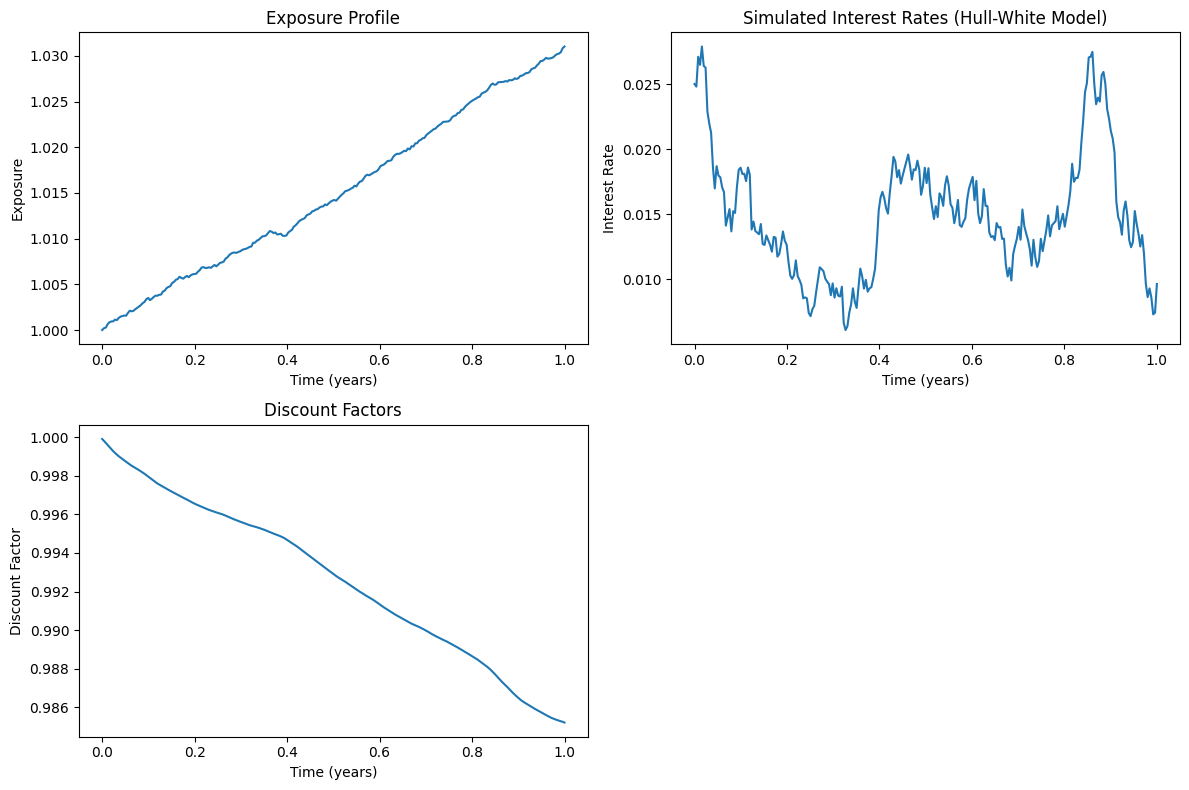

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Input parameters
num_simulations = 10000
T = 1  # Time horizon in years
time_steps = 252  # Daily steps for one year
base_risk_free_rate = 0.043
funding_spread = 0.005
cost_of_capital = 0.1
capital_requirement = 0.08
default_probability = 0.01
own_default_probability = 0.008
recovery_rate = 0.4
confidence_level = 0.98
lookback_window = 20
threshold = 50000
margin_call_freq = 10
interest_rate = 0.01

# Swap parameters
fixed_rate = 0.025  # 2.5%
notional = 1_000_000  # Notional amount
floating_spread = 0.005  # 50 bps spread

# GBM Parameters for Exposure
S0 = 1
mu = 0.03
base_sigma = 0.2

# Hull-White model parameters
a, sigma_hw, theta, initial_rate = 0.1, 0.02, 0.03, 0.025

# Function to simulate exposure profile with GBM
def simulate_exposure_gbm(S0, mu, sigma, T, steps, simulations):
    dt = T / steps
    exposures = np.zeros((simulations, steps))
    exposures[:, 0] = S0
    for t in range(1, steps):
        z = np.random.standard_normal(simulations)
        exposures[:, t] = exposures[:, t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return exposures.mean(axis=0)

# Hull-White model for interest rates
def simulate_hull_white(a, sigma, theta, initial_rate, num_steps, dt):
    rates = np.zeros(num_steps)
    rates[0] = initial_rate
    for t in range(1, num_steps):
        dW = np.random.normal(0, np.sqrt(dt))
        dr = a * (theta - rates[t - 1]) * dt + sigma * dW
        rates[t] = rates[t - 1] + dr
    return rates

def calculate_discount_factors(rates, dt):
    return np.exp(-np.cumsum(rates) * dt)

# Function to calculate XVAs
def calculate_xva(exposure_profile, discount_factors, default_probability, own_default_probability, recovery_rate, funding_spread, capital_requirement, cost_of_capital):
    survival_probabilities = (1 - default_probability) ** np.arange(1, len(exposure_profile) + 1)
    own_survival_probabilities = (1 - own_default_probability) ** np.arange(1, len(exposure_profile) + 1)

    cva = sum(exposure_profile[t] * (1 - recovery_rate) * discount_factors[t] * (1 - survival_probabilities[t]) for t in range(len(exposure_profile)))
    dva = sum(exposure_profile[t] * (1 - recovery_rate) * discount_factors[t] * (1 - own_survival_probabilities[t]) for t in range(len(exposure_profile)))
    fva = sum(exposure_profile[t] * funding_spread * discount_factors[t] for t in range(len(exposure_profile)))
    kva = sum(exposure_profile[t] * capital_requirement * cost_of_capital * discount_factors[t] for t in range(len(exposure_profile)))

    return cva, dva, fva, kva

# Simulate exposure profile
exposure_profile = simulate_exposure_gbm(S0, mu, base_sigma, T, time_steps, num_simulations)

# Simulate interest rates and calculate discount factors
dt = T / time_steps
rates = simulate_hull_white(a, sigma_hw, theta, initial_rate, time_steps, dt)
discount_factors = calculate_discount_factors(rates, dt)

# Calculate XVAs
cva, dva, fva, kva = calculate_xva(exposure_profile, discount_factors, default_probability, own_default_probability, recovery_rate, funding_spread, capital_requirement, cost_of_capital)

# Function to calculate swap NPV incorporating XVAs
def calculate_swap_npv_with_xva(fixed_rate, notional, payment_dates, reset_dates, forward_curve, discount_curve, floating_spread, cva, dva, fva, kva):
    floating_rates = forward_curve(reset_dates) + floating_spread
    fixed_leg_cash_flows = [fixed_rate * notional * (payment_dates[i] - (payment_dates[i-1] if i > 0 else 0)) for i in range(len(payment_dates))]
    floating_leg_cash_flows = [floating_rates[i] * notional * (payment_dates[i] - (payment_dates[i-1] if i > 0 else 0)) for i in range(len(payment_dates))]

    discount_factors = discount_curve(payment_dates)

    fixed_leg_present_value = sum(cf * df for cf, df in zip(fixed_leg_cash_flows, discount_factors))
    floating_leg_present_value = sum(cf * df for cf, df in zip(floating_leg_cash_flows, discount_factors))

    net_npv = floating_leg_present_value - fixed_leg_present_value
    net_npv_with_xva = net_npv - cva + dva - fva - kva

    return {
        "Fixed Leg NPV": fixed_leg_present_value,
        "Floating Leg NPV": floating_leg_present_value,
        "Net NPV": net_npv,
        "Net NPV with XVAs": net_npv_with_xva,
        "CVA": cva,
        "DVA": dva,
        "FVA": fva,
        "KVA": kva
    }

# Mock forward and discount curves using simulated rates
def forward_curve_mock(t):
    return np.interp(t, np.linspace(0, T, num=len(rates)), rates)

def discount_curve_mock(t):
    return np.interp(t, np.linspace(0, T, num=len(discount_factors)), discount_factors)

# Calculate swap dates
current_date = datetime(2024, 11, 22)
day_count = 365.25
start_date = current_date
payment_dates = [start_date + timedelta(days=90*i) for i in range(1, 5)]
reset_dates = [date - timedelta(days=2) for date in payment_dates]

payment_dates_yf = [(date - current_date).days / day_count for date in payment_dates]
reset_dates_yf = [(date - current_date).days / day_count for date in reset_dates]

# Calculate swap NPV including XVAs
swap_results = calculate_swap_npv_with_xva(fixed_rate, notional, payment_dates_yf, reset_dates_yf, forward_curve_mock, discount_curve_mock, floating_spread, cva, dva, fva, kva)

# Print results
print("Swap Valuation Results with XVAs:")
for key, value in swap_results.items():
    print(f"{key}: ${value:,.2f}")

# Plotting
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(np.linspace(0, T, time_steps), exposure_profile)
plt.title("Exposure Profile")
plt.xlabel("Time (years)")
plt.ylabel("Exposure")

plt.subplot(2, 2, 2)
plt.plot(np.linspace(0, T, time_steps), rates)
plt.title("Simulated Interest Rates (Hull-White Model)")
plt.xlabel("Time (years)")
plt.ylabel("Interest Rate")

plt.subplot(2, 2, 3)
plt.plot(np.linspace(0, T, time_steps), discount_factors)
plt.title("Discount Factors")
plt.xlabel("Time (years)")
plt.ylabel("Discount Factor")

plt.tight_layout()
plt.show()

8. Use Financial Libraries

	•	Leverage established libraries like QuantLib, which provide robust implementations for swap pricing and incorporate many of the above features out of the box.

Left to Implement (real data or other APIs related):

2. Day Count Conventions (Doesnt work yet)

	•	Real swaps use specific day count conventions (e.g., 30/360, Actual/360, Actual/Actual) for calculating interest payments.
	•	Adjust cash flow calculations to account for the day count basis.

Action:
	•	Use libraries like QuantLib to handle day count conventions programmatically.

5. Curve Bootstrapping

	•	Construct the forward and discount curves via bootstrapping from real swap rates, deposit rates, and other instruments.

Action:
	•	Use bootstrapping algorithms or leverage a library like QuantLib to construct curves.

8. Use Financial Libraries

	•	Leverage established libraries like QuantLib, which provide robust implementations for swap pricing and incorporate many of the above features out of the box.

1. Multi-Curve Framework
Incorporate a multi-curve framework that uses separate curves for discounting and forecasting. This approach:
    Uses an OIS curve for discounting
    Employs tenor-specific curves for forecasting different IBOR rates
    Requires solving a nonlinear system, often using modified Newton's methods

2. Principal Component Analysis
Apply Principal Component Analysis (PCA) to model the term structure of swap spreads:
    Decompose swap spreads into level and slope components
    Forecast these components using macroeconomic factors
    Combine with government bond yield forecasts for more accurate swap rate predictions


Swap Valuation Results with XVAs (Multi-Curve Framework):
Fixed Leg NPV: $24,342.60
Floating Leg NPV: $25,888.92
Net NPV: $1,546.32
Net NPV with XVAs: $1,533.09
CVA: $97.09
DVA: $87.15
FVA: $1.27
KVA: $2.03


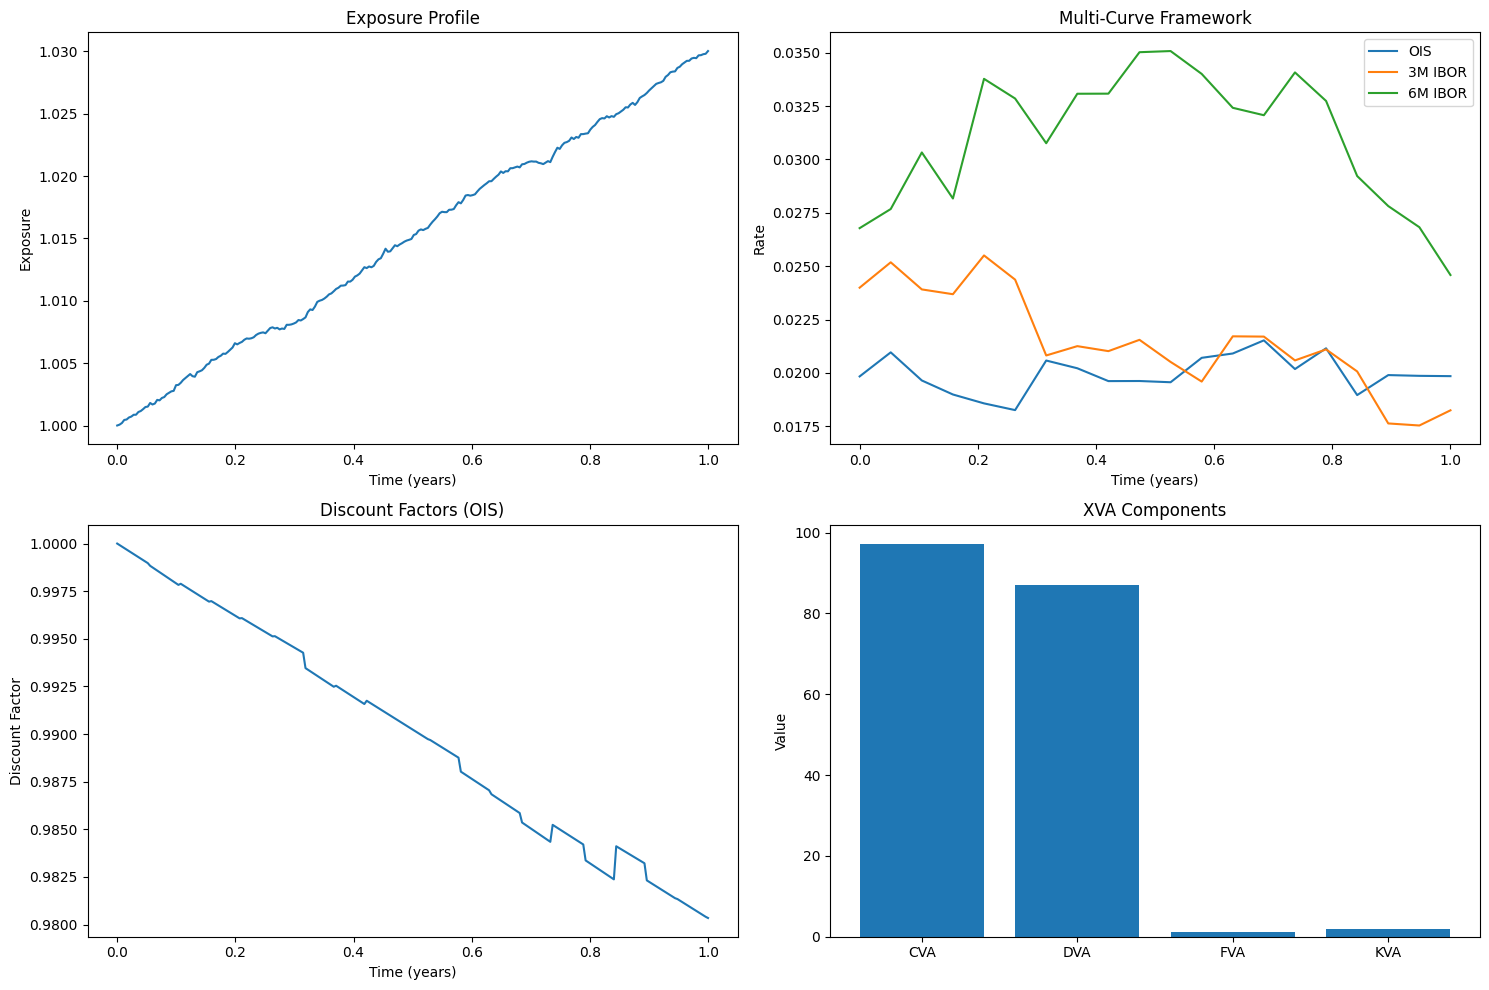

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import newton

# Input parameters (unchanged)
num_simulations = 10000
T = 1  # Time horizon in years
time_steps = 252  # Daily steps for one year
base_risk_free_rate = 0.043
funding_spread = 0.005
cost_of_capital = 0.1
capital_requirement = 0.08
default_probability = 0.01
own_default_probability = 0.008
recovery_rate = 0.4
confidence_level = 0.98
lookback_window = 20
threshold = 50000
margin_call_freq = 10
interest_rate = 0.01

# Swap parameters
fixed_rate = 0.025  # 2.5%
notional = 1_000_000  # Notional amount
floating_spread = 0.005  # 50 bps spread

# GBM Parameters for Exposure
S0 = 1
mu = 0.03
base_sigma = 0.2

# Hull-White model parameters
a, sigma_hw, theta, initial_rate = 0.1, 0.02, 0.03, 0.025

# Multi-curve framework
def generate_random_curve(num_points, base_rate, volatility):
    return base_rate + np.cumsum(np.random.normal(0, volatility, num_points))

# Generate random curves
num_curve_points = 20
ois_curve = generate_random_curve(num_curve_points, 0.02, 0.001)
ibor_3m_curve = generate_random_curve(num_curve_points, 0.025, 0.0015)
ibor_6m_curve = generate_random_curve(num_curve_points, 0.03, 0.002)

def interpolate_rate(t, curve, max_t=T):
    idx = min(int(t / max_t * (len(curve) - 1)), len(curve) - 1)
    return curve[idx]

def ois_rate(t):
    return interpolate_rate(t, ois_curve)

def ibor_3m_rate(t):
    return interpolate_rate(t, ibor_3m_curve)

def ibor_6m_rate(t):
    return interpolate_rate(t, ibor_6m_curve)

def discount_factor(t):
    return np.exp(-ois_rate(t) * t)

# Function to simulate exposure profile with GBM (unchanged)
def simulate_exposure_gbm(S0, mu, sigma, T, steps, simulations):
    dt = T / steps
    exposures = np.zeros((simulations, steps))
    exposures[:, 0] = S0
    for t in range(1, steps):
        z = np.random.standard_normal(simulations)
        exposures[:, t] = exposures[:, t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return exposures.mean(axis=0)

# Function to calculate XVAs (unchanged)
def calculate_xva(exposure_profile, discount_factors, default_probability, own_default_probability, recovery_rate, funding_spread, capital_requirement, cost_of_capital):
    survival_probabilities = (1 - default_probability) ** np.arange(1, len(exposure_profile) + 1)
    own_survival_probabilities = (1 - own_default_probability) ** np.arange(1, len(exposure_profile) + 1)

    cva = sum(exposure_profile[t] * (1 - recovery_rate) * discount_factors[t] * (1 - survival_probabilities[t]) for t in range(len(exposure_profile)))
    dva = sum(exposure_profile[t] * (1 - recovery_rate) * discount_factors[t] * (1 - own_survival_probabilities[t]) for t in range(len(exposure_profile)))
    fva = sum(exposure_profile[t] * funding_spread * discount_factors[t] for t in range(len(exposure_profile)))
    kva = sum(exposure_profile[t] * capital_requirement * cost_of_capital * discount_factors[t] for t in range(len(exposure_profile)))

    return cva, dva, fva, kva

# Function to calculate swap NPV incorporating XVAs and multi-curve framework
def calculate_swap_npv_with_xva_multi_curve(fixed_rate, notional, payment_dates, reset_dates, floating_spread, cva, dva, fva, kva):
    floating_rates = [ibor_3m_rate(t) + floating_spread for t in reset_dates]
    fixed_leg_cash_flows = [fixed_rate * notional * (payment_dates[i] - (payment_dates[i-1] if i > 0 else 0)) for i in range(len(payment_dates))]
    floating_leg_cash_flows = [floating_rates[i] * notional * (payment_dates[i] - (payment_dates[i-1] if i > 0 else 0)) for i in range(len(payment_dates))]

    discount_factors = [discount_factor(t) for t in payment_dates]

    fixed_leg_present_value = sum(cf * df for cf, df in zip(fixed_leg_cash_flows, discount_factors))
    floating_leg_present_value = sum(cf * df for cf, df in zip(floating_leg_cash_flows, discount_factors))

    net_npv = floating_leg_present_value - fixed_leg_present_value
    net_npv_with_xva = net_npv - cva + dva - fva - kva

    return {
        "Fixed Leg NPV": fixed_leg_present_value,
        "Floating Leg NPV": floating_leg_present_value,
        "Net NPV": net_npv,
        "Net NPV with XVAs": net_npv_with_xva,
        "CVA": cva,
        "DVA": dva,
        "FVA": fva,
        "KVA": kva
    }

# Simulate exposure profile
exposure_profile = simulate_exposure_gbm(S0, mu, base_sigma, T, time_steps, num_simulations)

# Calculate discount factors for XVA calculation
discount_factors = [discount_factor(t) for t in np.linspace(0, T, time_steps)]

# Calculate XVAs
cva, dva, fva, kva = calculate_xva(exposure_profile, discount_factors, default_probability, own_default_probability, recovery_rate, funding_spread, capital_requirement, cost_of_capital)

# Calculate swap dates
current_date = datetime(2024, 11, 22)
day_count = 365.25
start_date = current_date
payment_dates = [start_date + timedelta(days=90*i) for i in range(1, 5)]
reset_dates = [date - timedelta(days=2) for date in payment_dates]

payment_dates_yf = [(date - current_date).days / day_count for date in payment_dates]
reset_dates_yf = [(date - current_date).days / day_count for date in reset_dates]

# Calculate swap NPV including XVAs with multi-curve framework
swap_results = calculate_swap_npv_with_xva_multi_curve(fixed_rate, notional, payment_dates_yf, reset_dates_yf, floating_spread, cva, dva, fva, kva)

# Print results
print("Swap Valuation Results with XVAs (Multi-Curve Framework):")
for key, value in swap_results.items():
    print(f"{key}: ${value:,.2f}")

# Plotting
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(np.linspace(0, T, time_steps), exposure_profile)
plt.title("Exposure Profile")
plt.xlabel("Time (years)")
plt.ylabel("Exposure")

plt.subplot(2, 2, 2)
t = np.linspace(0, T, num_curve_points)
plt.plot(t, ois_curve, label="OIS")
plt.plot(t, ibor_3m_curve, label="3M IBOR")
plt.plot(t, ibor_6m_curve, label="6M IBOR")
plt.title("Multi-Curve Framework")
plt.xlabel("Time (years)")
plt.ylabel("Rate")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(np.linspace(0, T, time_steps), discount_factors)
plt.title("Discount Factors (OIS)")
plt.xlabel("Time (years)")
plt.ylabel("Discount Factor")

plt.subplot(2, 2, 4)
xva_values = [swap_results["CVA"], swap_results["DVA"], swap_results["FVA"], swap_results["KVA"]]
plt.bar(["CVA", "DVA", "FVA", "KVA"], xva_values)
plt.title("XVA Components")
plt.ylabel("Value")

plt.tight_layout()
plt.show()

2. Principal Component Analysis
Apply Principal Component Analysis (PCA) to model the term structure of swap spreads:
    Decompose swap spreads into level and slope components
    Forecast these components using macroeconomic factors
    Combine with government bond yield forecasts for more accurate swap rate predictions

Swap Valuation Results with XVAs (Multi-Curve Framework and PCA):
Fixed Leg NPV: $24,299.68
Floating Leg NPV: $32,797.52
Net NPV: $8,497.84
Net NPV with XVAs: $8,484.65
CVA: $96.72
DVA: $86.81
FVA: $1.26
KVA: $2.02
Forecast Spreads:
  1y: 0.001993
  2y: 0.001979
  3y: 0.001973
  5y: 0.002007
  7y: 0.001990
  10y: 0.001955
  30y: 0.001987


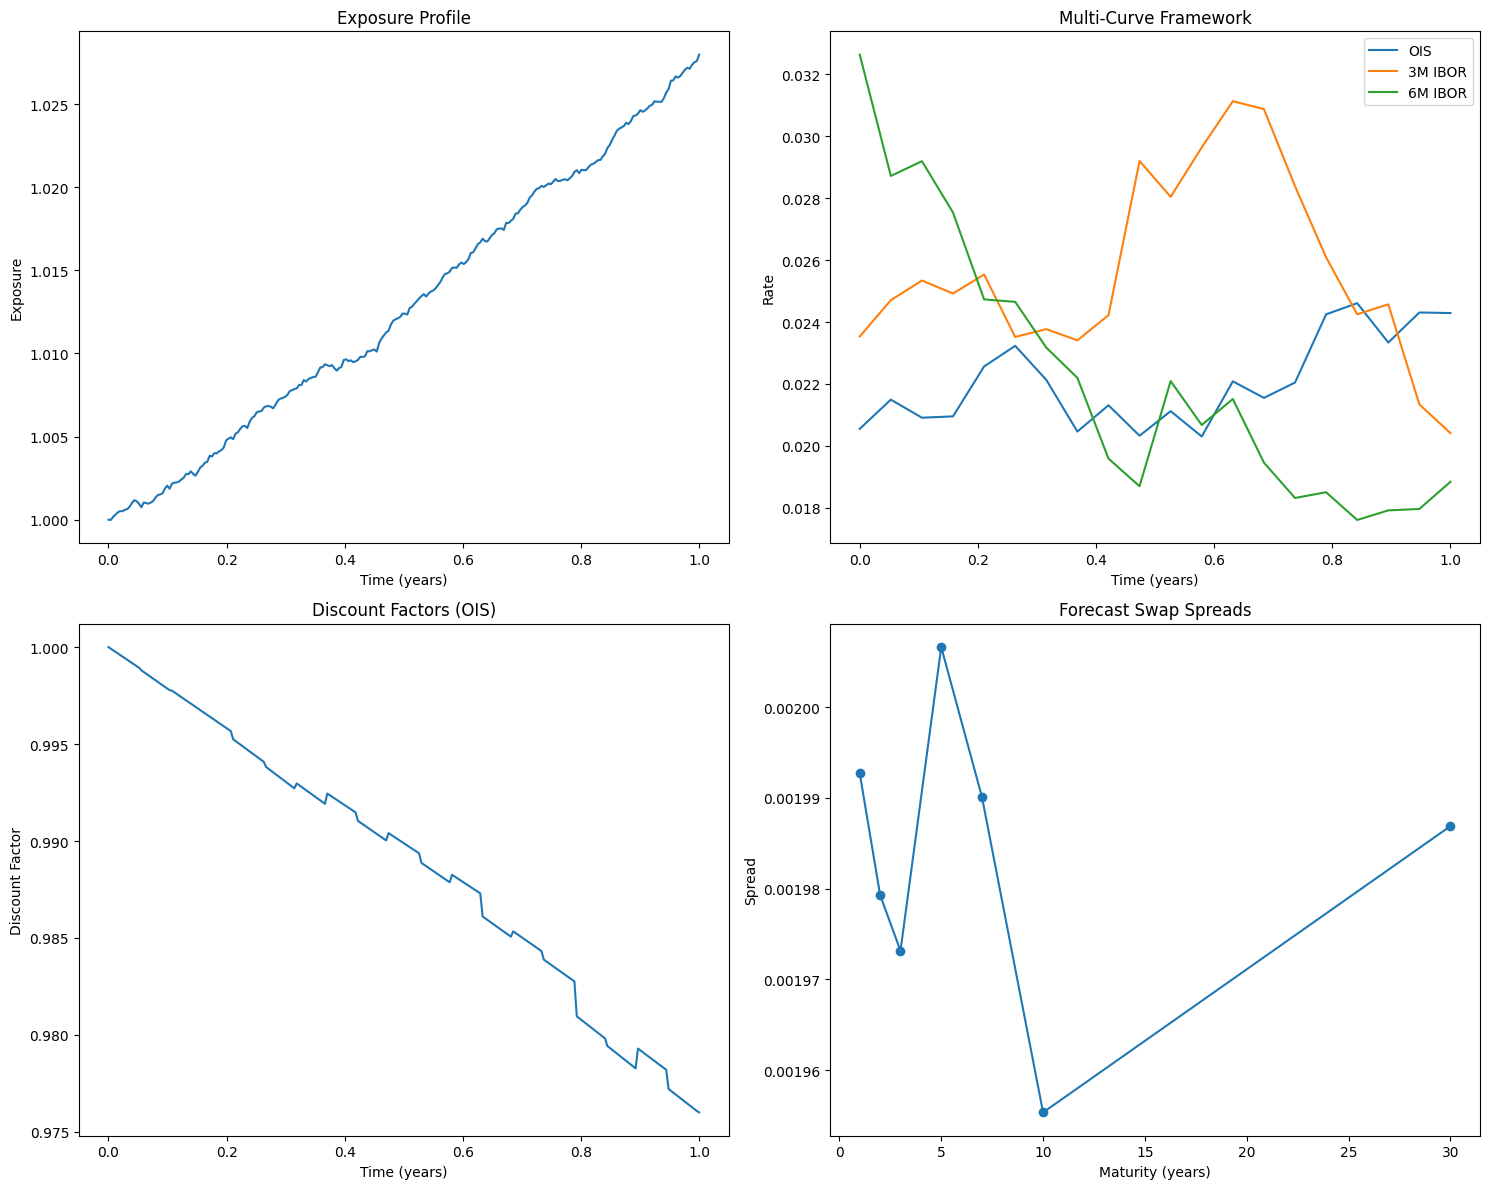

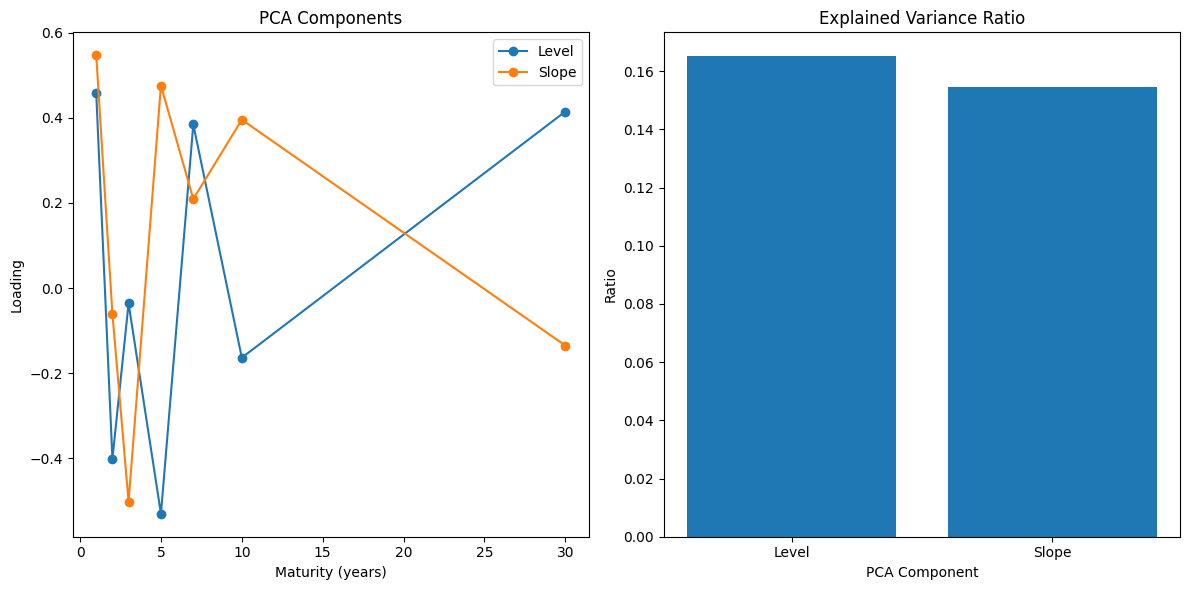

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import newton
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

# Input parameters
num_simulations = 10000
T = 1  # Time horizon in years
time_steps = 252  # Daily steps for one year
base_risk_free_rate = 0.043
funding_spread = 0.005
cost_of_capital = 0.1
capital_requirement = 0.08
default_probability = 0.01
own_default_probability = 0.008
recovery_rate = 0.4
confidence_level = 0.98
lookback_window = 20
threshold = 50000
margin_call_freq = 10
interest_rate = 0.01

# Swap parameters
fixed_rate = 0.025  # 2.5%
notional = 1_000_000  # Notional amount
floating_spread = 0.005  # 50 bps spread

# GBM Parameters for Exposure
S0 = 1
mu = 0.03
base_sigma = 0.2

# Hull-White model parameters
a, sigma_hw, theta, initial_rate = 0.1, 0.02, 0.03, 0.025

# Multi-curve framework
def generate_random_curve(num_points, base_rate, volatility):
    return base_rate + np.cumsum(np.random.normal(0, volatility, num_points))

# Generate random curves
num_curve_points = 20
ois_curve = generate_random_curve(num_curve_points, 0.02, 0.001)
ibor_3m_curve = generate_random_curve(num_curve_points, 0.025, 0.0015)
ibor_6m_curve = generate_random_curve(num_curve_points, 0.03, 0.002)

def interpolate_rate(t, curve, max_t=T):
    idx = min(int(t / max_t * (len(curve) - 1)), len(curve) - 1)
    return curve[idx]

def ois_rate(t):
    return interpolate_rate(t, ois_curve)

def ibor_3m_rate(t):
    return interpolate_rate(t, ibor_3m_curve)

def ibor_6m_rate(t):
    return interpolate_rate(t, ibor_6m_curve)

def discount_factor(t):
    return np.exp(-ois_rate(t) * t)

# Function to simulate exposure profile with GBM
def simulate_exposure_gbm(S0, mu, sigma, T, steps, simulations):
    dt = T / steps
    exposures = np.zeros((simulations, steps))
    exposures[:, 0] = S0
    for t in range(1, steps):
        z = np.random.standard_normal(simulations)
        exposures[:, t] = exposures[:, t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return exposures.mean(axis=0)

# Function to calculate XVAs
def calculate_xva(exposure_profile, discount_factors, default_probability, own_default_probability, recovery_rate, funding_spread, capital_requirement, cost_of_capital):
    survival_probabilities = (1 - default_probability) ** np.arange(1, len(exposure_profile) + 1)
    own_survival_probabilities = (1 - own_default_probability) ** np.arange(1, len(exposure_profile) + 1)

    cva = sum(exposure_profile[t] * (1 - recovery_rate) * discount_factors[t] * (1 - survival_probabilities[t]) for t in range(len(exposure_profile)))
    dva = sum(exposure_profile[t] * (1 - recovery_rate) * discount_factors[t] * (1 - own_survival_probabilities[t]) for t in range(len(exposure_profile)))
    fva = sum(exposure_profile[t] * funding_spread * discount_factors[t] for t in range(len(exposure_profile)))
    kva = sum(exposure_profile[t] * capital_requirement * cost_of_capital * discount_factors[t] for t in range(len(exposure_profile)))

    return cva, dva, fva, kva

# Generate random swap spreads for different maturities
maturities = [1, 2, 3, 5, 7, 10, 30]
num_observations = 1000
swap_spreads = np.random.normal(0.002, 0.001, (num_observations, len(maturities)))

# Perform PCA on swap spreads
pca = PCA(n_components=2)
pca_components = pca.fit_transform(swap_spreads)

# Generate random macroeconomic factors
gdp_growth = np.random.normal(0.02, 0.01, num_observations)
inflation = np.random.normal(0.02, 0.005, num_observations)
unemployment = np.random.normal(0.05, 0.01, num_observations)

# Combine macroeconomic factors
macro_factors = np.column_stack((gdp_growth, inflation, unemployment))

# Train linear regression models for each PCA component
level_model = LinearRegression().fit(macro_factors, pca_components[:, 0])
slope_model = LinearRegression().fit(macro_factors, pca_components[:, 1])

# Function to forecast PCA components
def forecast_pca_components(macro_forecast):
    level_forecast = level_model.predict(macro_forecast.reshape(1, -1))
    slope_forecast = slope_model.predict(macro_forecast.reshape(1, -1))
    return np.array([level_forecast[0], slope_forecast[0]])

# Function to reconstruct swap spreads from PCA components
def reconstruct_swap_spreads(pca_forecast):
    return pca.inverse_transform(pca_forecast.reshape(1, -1))[0]

# Function to calculate swap NPV incorporating XVAs, multi-curve framework, and PCA
def calculate_swap_npv_with_xva_multi_curve_pca(fixed_rate, notional, payment_dates, reset_dates, floating_spread, cva, dva, fva, kva, macro_forecast):
    # Forecast PCA components
    pca_forecast = forecast_pca_components(macro_forecast)
    
    # Reconstruct swap spreads
    forecast_spreads = reconstruct_swap_spreads(pca_forecast)
    
    # Interpolate forecast spreads for payment and reset dates
    payment_spreads = np.interp(payment_dates, maturities, forecast_spreads)
    reset_spreads = np.interp(reset_dates, maturities, forecast_spreads)
    
    # Calculate floating rates using forecast spreads
    floating_rates = [ibor_3m_rate(t) + reset_spreads[i] + floating_spread for i, t in enumerate(reset_dates)]
    
    fixed_leg_cash_flows = [fixed_rate * notional * (payment_dates[i] - (payment_dates[i-1] if i > 0 else 0)) for i in range(len(payment_dates))]
    floating_leg_cash_flows = [floating_rates[i] * notional * (payment_dates[i] - (payment_dates[i-1] if i > 0 else 0)) for i in range(len(payment_dates))]

    discount_factors = [discount_factor(t) for t in payment_dates]

    fixed_leg_present_value = sum(cf * df for cf, df in zip(fixed_leg_cash_flows, discount_factors))
    floating_leg_present_value = sum(cf * df for cf, df in zip(floating_leg_cash_flows, discount_factors))

    net_npv = floating_leg_present_value - fixed_leg_present_value
    net_npv_with_xva = net_npv - cva + dva - fva - kva

    return {
        "Fixed Leg NPV": fixed_leg_present_value,
        "Floating Leg NPV": floating_leg_present_value,
        "Net NPV": net_npv,
        "Net NPV with XVAs": net_npv_with_xva,
        "CVA": cva,
        "DVA": dva,
        "FVA": fva,
        "KVA": kva,
        "Forecast Spreads": forecast_spreads
    }

# Simulate exposure profile
exposure_profile = simulate_exposure_gbm(S0, mu, base_sigma, T, time_steps, num_simulations)

# Calculate discount factors for XVA calculation
discount_factors = [discount_factor(t) for t in np.linspace(0, T, time_steps)]

# Calculate XVAs
cva, dva, fva, kva = calculate_xva(exposure_profile, discount_factors, default_probability, own_default_probability, recovery_rate, funding_spread, capital_requirement, cost_of_capital)

# Calculate swap dates
current_date = datetime(2024, 11, 22)
day_count = 365.25
start_date = current_date
payment_dates = [start_date + timedelta(days=90*i) for i in range(1, 5)]
reset_dates = [date - timedelta(days=2) for date in payment_dates]

payment_dates_yf = [(date - current_date).days / day_count for date in payment_dates]
reset_dates_yf = [(date - current_date).days / day_count for date in reset_dates]

# Generate a random macroeconomic forecast
macro_forecast = np.random.normal([0.02, 0.02, 0.05], [0.01, 0.005, 0.01])

# Calculate swap NPV including XVAs with multi-curve framework and PCA
swap_results = calculate_swap_npv_with_xva_multi_curve_pca(fixed_rate, notional, payment_dates_yf, reset_dates_yf, floating_spread, cva, dva, fva, kva, macro_forecast)

# Print results
print("Swap Valuation Results with XVAs (Multi-Curve Framework and PCA):")
for key, value in swap_results.items():
    if isinstance(value, np.ndarray):
        print(f"{key}:")
        for i, v in enumerate(value):
            print(f"  {maturities[i]}y: {v:.6f}")
    else:
        print(f"{key}: ${value:,.2f}")

# Plotting
plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
plt.plot(np.linspace(0, T, time_steps), exposure_profile)
plt.title("Exposure Profile")
plt.xlabel("Time (years)")
plt.ylabel("Exposure")

plt.subplot(2, 2, 2)
t = np.linspace(0, T, num_curve_points)
plt.plot(t, ois_curve, label="OIS")
plt.plot(t, ibor_3m_curve, label="3M IBOR")
plt.plot(t, ibor_6m_curve, label="6M IBOR")
plt.title("Multi-Curve Framework")
plt.xlabel("Time (years)")
plt.ylabel("Rate")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(np.linspace(0, T, time_steps), discount_factors)
plt.title("Discount Factors (OIS)")
plt.xlabel("Time (years)")
plt.ylabel("Discount Factor")

plt.subplot(2, 2, 4)
plt.plot(maturities, swap_results["Forecast Spreads"], marker='o')
plt.title("Forecast Swap Spreads")
plt.xlabel("Maturity (years)")
plt.ylabel("Spread")

plt.tight_layout()
plt.show()

# Plot PCA components
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(maturities, pca.components_[0], marker='o', label='Level')
plt.plot(maturities, pca.components_[1], marker='o', label='Slope')
plt.title("PCA Components")
plt.xlabel("Maturity (years)")
plt.ylabel("Loading")
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(range(2), pca.explained_variance_ratio_)
plt.title("Explained Variance Ratio")
plt.xlabel("PCA Component")
plt.ylabel("Ratio")
plt.xticks(range(2), ['Level', 'Slope'])

plt.tight_layout()
plt.show()


# Interest Rate Swap Pricing and XVA Analysis

This repository provides a Python implementation for pricing **interest rate swaps (IRS)** with adjustments for credit, funding, and capital (XVAs). The code also includes a multi-curve framework, exposure simulation using Geometric Brownian Motion (GBM), and a Principal Component Analysis (PCA)-based macroeconomic forecasting model.

---

## Features

- **Interest Rate Swap Pricing**:
  - Compute fixed and floating leg cash flows.
  - Incorporate a multi-curve framework for accurate discounting and projection.
- **XVA Adjustments**:
  - Calculate Credit Valuation Adjustment (CVA), Debit Valuation Adjustment (DVA), Funding Valuation Adjustment (FVA), and Capital Valuation Adjustment (KVA).
- **Exposure Simulation**:
  - Simulate exposure profiles using GBM for future cash flow estimation.
- **Multi-Curve Framework**:
  - Incorporate OIS and IBOR curves for discounting and projection.
- **PCA for Swap Spread Forecasting**:
  - Decompose historical swap spreads using PCA.
  - Forecast swap spreads using macroeconomic indicators.
- **Visualization**:
  - Plot exposure profiles, discount factors, forecast spreads, and PCA components.

---

## Table of Contents

1. [Methods Overview](#methods-overview)
2. [Inputs](#inputs)
3. [Outputs](#outputs)
4. [Example Usage](#example-usage)
5. [Requirements](#requirements)
6. [Acknowledgments](#acknowledgments)

---

## Methods Overview

### Swap Pricing
- `calculate_swap_npv_with_xva_multi_curve_pca(...)`:
  - Calculates the net present value (NPV) of an interest rate swap.
  - Incorporates XVAs, multi-curve frameworks, and PCA-based spread forecasting.

### XVA Adjustments
- `calculate_xva(...)`:
  - Calculates CVA, DVA, FVA, and KVA using exposure profiles and discount factors.

### Exposure Simulation
- `simulate_exposure_gbm(...)`:
  - Simulates the exposure profile using GBM for future cash flow estimation.

### Multi-Curve Framework
- Generate random OIS and IBOR curves using `generate_random_curve(...)`.
- Discount and project cash flows using the curves.

### PCA and Macroeconomic Forecasting
- Decompose historical swap spreads into PCA components.
- Use macroeconomic factors to forecast future spreads:
  - `forecast_pca_components(...)`
  - `reconstruct_swap_spreads(...)`

---

## Inputs

### Swap Parameters
- `fixed_rate`: Fixed interest rate for the IRS (e.g., 2.5%).
- `floating_spread`: Spread added to floating rates (e.g., 50 bps).
- `notional`: Notional value of the swap (e.g., \$1,000,000).

### XVA Parameters
- `default_probability`: Counterparty's probability of default (e.g., 1%).
- `own_default_probability`: Firm's probability of default (e.g., 0.8%).
- `recovery_rate`: Fraction of exposure recovered in default (e.g., 40%).
- `funding_spread`: Funding cost over the risk-free rate (e.g., 0.5%).
- `capital_requirement`: Capital reserve as a percentage of notional (e.g., 8%).
- `cost_of_capital`: Annual cost of maintaining required capital (e.g., 10%).

### Market Curves
- `ois_curve`: Overnight Indexed Swap (OIS) curve for discounting.
- `ibor_3m_curve`: 3-month IBOR curve for floating rate projection.
- `ibor_6m_curve`: 6-month IBOR curve for alternative floating projection.

### PCA Forecasting
- `macro_factors`: Historical macroeconomic indicators:
  - GDP growth, inflation, and unemployment rates.
- `macro_forecast`: Forecasted macroeconomic factors for spread projection.

---

## Outputs

1. **Swap Valuation**:
   - Fixed leg, floating leg, and net NPV of the swap.
   - Adjusted NPV accounting for XVAs.
2. **XVA Breakdown**:
   - Credit Valuation Adjustment (CVA).
   - Debit Valuation Adjustment (DVA).
   - Funding Valuation Adjustment (FVA).
   - Capital Valuation Adjustment (KVA).
3. **Forecast Spreads**:
   - Forecasted swap spreads for various maturities.
4. **Visualization**:
   - Exposure profiles, discount factors, and multi-curve rates.
   - PCA components and explained variance.

---

## Example Usage

```python
# Define swap parameters
fixed_rate = 0.025  # 2.5%
notional = 1_000_000
floating_spread = 0.005  # 50 bps spread

# Generate random market curves
ois_curve = generate_random_curve(20, 0.02, 0.001)
ibor_3m_curve = generate_random_curve(20, 0.025, 0.0015)
ibor_6m_curve = generate_random_curve(20, 0.03, 0.002)

# Simulate exposure
exposure_profile = simulate_exposure_gbm(S0=1, mu=0.03, sigma=0.2, T=1, steps=252, simulations=10000)

# Calculate XVAs
discount_factors = [discount_factor(t) for t in np.linspace(0, 1, 252)]
cva, dva, fva, kva = calculate_xva(
    exposure_profile, discount_factors,
    default_probability=0.01,
    own_default_probability=0.008,
    recovery_rate=0.4,
    funding_spread=0.005,
    capital_requirement=0.08,
    cost_of_capital=0.1
)

# Define payment and reset dates
payment_dates = [0.25, 0.5, 0.75, 1.0]  # Quarterly payments
reset_dates = [t - 0.005 for t in payment_dates]  # Reset 2 days earlier

# Generate macroeconomic forecast
macro_forecast = np.array([0.02, 0.02, 0.05])  # GDP growth, inflation, unemployment

# Calculate swap valuation
results = calculate_swap_npv_with_xva_multi_curve_pca(
    fixed_rate, notional, payment_dates, reset_dates,
    floating_spread, cva, dva, fva, kva, macro_forecast
)

# Print results
for key, value in results.items():
    print(f"{key}: {value}")
```

---

## Requirements

- Python 3.7+
- Required Libraries:
  - `numpy`
  - `pandas`
  - `matplotlib`
  - `scipy`
  - `scikit-learn`

---

## Acknowledgments

This implementation is based on advanced interest rate modeling techniques, including:
- Multi-curve frameworks for OIS and IBOR.
- XVA calculation methodologies for credit, funding, and capital risk.
- Principal Component Analysis (PCA) for spread forecasting.

---



## Currency Swap

In [20]:
import numpy as np
from scipy.interpolate import interp1d

def price_currency_swap(notional_dom, notional_for, spot_rate, dom_rates, for_rates, 
                        dom_fixed_rate, for_fixed_rate, tenor, payment_freq):
    
    # Convert annual rates to payment frequency
    dom_fixed_rate /= payment_freq
    for_fixed_rate /= payment_freq
    
    # Generate payment dates
    payment_dates = np.arange(payment_freq, tenor + payment_freq, payment_freq)
    
    # Interpolate discount factors
    dom_df = interp1d(dom_rates[:, 0], dom_rates[:, 1], kind='linear', fill_value='extrapolate')
    for_df = interp1d(for_rates[:, 0], for_rates[:, 1], kind='linear', fill_value='extrapolate')
    
    # Calculate present values
    dom_pv = 0
    for_pv = 0
    
    for date in payment_dates:
        dom_pv += notional_dom * dom_fixed_rate * dom_df(date)
        for_pv += notional_for * for_fixed_rate * for_df(date)
    
    # Add final notional exchange
    dom_pv += notional_dom * dom_df(tenor)
    for_pv += notional_for * for_df(tenor)
    
    # Convert foreign PV to domestic currency
    for_pv_in_dom = for_pv * spot_rate
    
    # Calculate swap value
    swap_value = dom_pv - for_pv_in_dom
    
    return swap_value

# Example usage
notional_dom = 1000000  # Domestic currency notional
notional_for = 900000   # Foreign currency notional
spot_rate = 1.11        # Spot exchange rate (DOM/FOR)
dom_rates = np.array([[1, 0.98], [2, 0.96], [3, 0.94], [4, 0.92], [5, 0.90]])  # Domestic discount factors
for_rates = np.array([[1, 0.99], [2, 0.98], [3, 0.97], [4, 0.96], [5, 0.95]])  # Foreign discount factors
dom_fixed_rate = 0.03   # Domestic fixed rate (annual)
for_fixed_rate = 0.02   # Foreign fixed rate (annual)
tenor = 5               # Swap tenor in years
payment_freq = 2        # Payments per year

swap_value = price_currency_swap(notional_dom, notional_for, spot_rate, dom_rates, for_rates, 
                                 dom_fixed_rate, for_fixed_rate, tenor, payment_freq)

print(f"The value of the currency swap is: {swap_value:.2f}")

The value of the currency swap is: -36421.20



1. Counterparty credit risk: Include a credit valuation adjustment (CVA) to account for the possibility of default by either party.
2. Basis spreads: Incorporate cross-currency basis spreads, which reflect the relative demand for one currency versus another and the inherent credit risk in different currency LIBOR fixings.
3. Forward exchange rates: Use forward exchange rates instead of spot rates for future cash flows, as these better reflect market expectations of future currency values.
4. Yield curve construction: Implement a more sophisticated yield curve construction using bootstrapping or interpolation methods for more accurate discounting.
5. Multiple curve framework: Use different curves for discounting and for projecting future cash flows, especially in a post-financial crisis environment3.
6. Volatility surface: For options embedded in some currency swaps, incorporate a volatility surface to more accurately price these components.
7. Transaction costs and bid-ask spreads: Include these to reflect real-world trading conditions1.
8. Collateral agreements: Account for the impact of collateral on pricing, as it affects the effective discounting rate.
9. Capital costs: Factor in the regulatory capital requirements for holding the swap position.
10. Funding costs: Consider the funding value adjustment (FVA) to reflect the cost of funding the uncollateralized portion of the swap.

In [21]:
import numpy as np
from scipy.interpolate import interp1d

def price_currency_swap(notional_dom, notional_for, spot_rate, dom_rates, for_rates, 
                        dom_fixed_rate, for_fixed_rate, tenor, payment_freq):

        # Convert annual rates to payment frequency
    dom_fixed_rate /= payment_freq
    for_fixed_rate /= payment_freq
    
    # Generate payment dates
    payment_dates = np.arange(payment_freq, tenor + payment_freq, payment_freq)
    
    # Interpolate discount factors
    dom_df = interp1d(dom_rates[:, 0], dom_rates[:, 1], kind='linear', fill_value='extrapolate')
    for_df = interp1d(for_rates[:, 0], for_rates[:, 1], kind='linear', fill_value='extrapolate')
    
    # Calculate present values
    dom_pv = 0
    for_pv = 0
    
    for date in payment_dates:
        dom_pv += notional_dom * dom_fixed_rate * dom_df(date)
        for_pv += notional_for * for_fixed_rate * for_df(date)
    
    # Add final notional exchange
    dom_pv += notional_dom * dom_df(tenor)
    for_pv += notional_for * for_df(tenor)
    
    # Convert foreign PV to domestic currency
    for_pv_in_dom = for_pv * spot_rate
    
    # Calculate swap value
    swap_value = dom_pv - for_pv_in_dom
    

    # Calculate exposure profile
    exposure_profile = np.zeros(len(payment_dates))
    for i, date in enumerate(payment_dates):
        dom_pv_at_date = sum([notional_dom * dom_fixed_rate * dom_df(t) for t in payment_dates[i:]])
        for_pv_at_date = sum([notional_for * for_fixed_rate * for_df(t) for t in payment_dates[i:]])
        exposure_profile[i] = max(0, dom_pv_at_date - for_pv_at_date * spot_rate)

    return swap_value, exposure_profile, payment_dates

def calculate_cva(exposure_profile, payment_dates, pd_curve, lgd):
    cva = 0
    for i, exposure in enumerate(exposure_profile):
        survival_prob = 1 - pd_curve(payment_dates[i])
        default_prob = pd_curve(payment_dates[i]) - pd_curve(payment_dates[i-1]) if i > 0 else pd_curve(payment_dates[0])
        cva += exposure * default_prob * lgd
    return cva

# Example usage
notional_dom = 1000000  # Domestic currency notional
notional_for = 900000   # Foreign currency notional
spot_rate = 1.11        # Spot exchange rate (DOM/FOR)
dom_rates = np.array([[1, 0.98], [2, 0.96], [3, 0.94], [4, 0.92], [5, 0.90]])  # Domestic discount factors
for_rates = np.array([[1, 0.99], [2, 0.98], [3, 0.97], [4, 0.96], [5, 0.95]])  # Foreign discount factors
dom_fixed_rate = 0.03   # Domestic fixed rate (annual)
for_fixed_rate = 0.02   # Foreign fixed rate (annual)
tenor = 5               # Swap tenor in years
payment_freq = 2        # Payments per year

# Calculate swap value and exposure profile
swap_value, exposure_profile, payment_dates = price_currency_swap(
    notional_dom, notional_for, spot_rate, dom_rates, for_rates, 
    dom_fixed_rate, for_fixed_rate, tenor, payment_freq
)

# Define probability of default curve (example)
pd_times = np.array([0, 1, 2, 3, 4, 5])
pd_values = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05])
pd_curve = interp1d(pd_times, pd_values, kind='linear', fill_value='extrapolate')

# Calculate CVA
lgd = 0.6  # Loss Given Default
cva = calculate_cva(exposure_profile, payment_dates, pd_curve, lgd)

# Adjust swap value for CVA
adjusted_swap_value = swap_value - cva

print(f"The unadjusted value of the currency swap is: {swap_value:.2f}")
print(f"The Credit Valuation Adjustment (CVA) is: {cva:.2f}")
print(f"The CVA-adjusted value of the currency swap is: {adjusted_swap_value:.2f}")

The unadjusted value of the currency swap is: -36421.20
The Credit Valuation Adjustment (CVA) is: 293.49
The CVA-adjusted value of the currency swap is: -36714.69


2. Basis spreads: Incorporate cross-currency basis spreads, which reflect the relative demand for one currency versus another and the inherent credit risk in different currency LIBOR fixings.

In [22]:
import numpy as np
from scipy.interpolate import interp1d
import random

def price_currency_swap(notional_dom, notional_for, spot_rate, dom_rates, for_rates, 
                        dom_fixed_rate, for_fixed_rate, tenor, payment_freq, basis_spread):
    
    # Convert annual rates to payment frequency
    dom_fixed_rate /= payment_freq
    for_fixed_rate /= payment_freq
    basis_spread /= payment_freq
    
    # Generate payment dates
    payment_dates = np.arange(payment_freq, tenor + payment_freq, payment_freq)
    
    # Interpolate discount factors
    dom_df = interp1d(dom_rates[:, 0], dom_rates[:, 1], kind='linear', fill_value='extrapolate')
    for_df = interp1d(for_rates[:, 0], for_rates[:, 1], kind='linear', fill_value='extrapolate')
    
    # Calculate present values
    dom_pv = 0
    for_pv = 0
    
    for date in payment_dates:
        dom_pv += notional_dom * dom_fixed_rate * dom_df(date)
        for_pv += notional_for * (for_fixed_rate + basis_spread) * for_df(date)
    
    # Add final notional exchange
    dom_pv += notional_dom * dom_df(tenor)
    for_pv += notional_for * for_df(tenor)
    
    # Convert foreign PV to domestic currency
    for_pv_in_dom = for_pv * spot_rate
    
    # Calculate swap value
    swap_value = dom_pv - for_pv_in_dom
    
    # Calculate exposure profile
    exposure_profile = np.zeros(len(payment_dates))
    for i, date in enumerate(payment_dates):
        dom_pv_at_date = sum([notional_dom * dom_fixed_rate * dom_df(t) for t in payment_dates[i:]])
        for_pv_at_date = sum([notional_for * (for_fixed_rate + basis_spread) * for_df(t) for t in payment_dates[i:]])
        exposure_profile[i] = max(0, dom_pv_at_date - for_pv_at_date * spot_rate)

    return swap_value, exposure_profile, payment_dates

def calculate_cva(exposure_profile, payment_dates, pd_curve, lgd):
    cva = 0
    for i, exposure in enumerate(exposure_profile):
        survival_prob = 1 - pd_curve(payment_dates[i])
        default_prob = pd_curve(payment_dates[i]) - pd_curve(payment_dates[i-1]) if i > 0 else pd_curve(payment_dates[0])
        cva += exposure * default_prob * lgd
    return cva

# Generate random market data
def generate_random_rates(tenor):
    times = np.arange(1, tenor + 1)
    rates = np.cumsum(np.random.uniform(-0.001, 0.001, tenor)) + 0.98
    return np.column_stack((times, rates))

# Example usage with random data
notional_dom = 1000000  # Domestic currency notional
notional_for = 900000   # Foreign currency notional
spot_rate = random.uniform(1.05, 1.15)  # Random spot exchange rate (DOM/FOR)
dom_rates = generate_random_rates(5)  # Random domestic discount factors
for_rates = generate_random_rates(5)  # Random foreign discount factors
dom_fixed_rate = random.uniform(0.02, 0.04)  # Random domestic fixed rate (annual)
for_fixed_rate = random.uniform(0.01, 0.03)  # Random foreign fixed rate (annual)
tenor = 5               # Swap tenor in years
payment_freq = 2        # Payments per year
basis_spread = random.uniform(0.001, 0.005)  # Random basis spread (annual)

# Calculate swap value and exposure profile
swap_value, exposure_profile, payment_dates = price_currency_swap(
    notional_dom, notional_for, spot_rate, dom_rates, for_rates, 
    dom_fixed_rate, for_fixed_rate, tenor, payment_freq, basis_spread
)

# Define probability of default curve (random example)
pd_times = np.array([0, 1, 2, 3, 4, 5])
pd_values = np.cumsum(np.random.uniform(0, 0.01, 6))
pd_curve = interp1d(pd_times, pd_values, kind='linear', fill_value='extrapolate')

# Calculate CVA
lgd = random.uniform(0.5, 0.7)  # Random Loss Given Default
cva = calculate_cva(exposure_profile, payment_dates, pd_curve, lgd)

# Adjust swap value for CVA
adjusted_swap_value = swap_value - cva

print(f"Spot Rate: {spot_rate:.4f}")
print(f"Domestic Fixed Rate: {dom_fixed_rate:.4f}")
print(f"Foreign Fixed Rate: {for_fixed_rate:.4f}")
print(f"Basis Spread: {basis_spread:.4f}")
print(f"Loss Given Default: {lgd:.4f}")
print(f"The unadjusted value of the currency swap is: {swap_value:.2f}")
print(f"The Credit Valuation Adjustment (CVA) is: {cva:.2f}")
print(f"The CVA-adjusted value of the currency swap is: {adjusted_swap_value:.2f}")

Spot Rate: 1.0842
Domestic Fixed Rate: 0.0294
Foreign Fixed Rate: 0.0195
Basis Spread: 0.0038
Loss Given Default: 0.5644
The unadjusted value of the currency swap is: 34767.46
The Credit Valuation Adjustment (CVA) is: 110.80
The CVA-adjusted value of the currency swap is: 34656.66


3. Forward exchange rates: Use forward exchange rates instead of spot rates for future cash flows, as these better reflect market expectations of future currency values.

In [28]:
import numpy as np
from scipy.interpolate import interp1d
import random

def generate_random_rates(tenor):
    times = np.arange(1, tenor + 1)
    rates = np.cumsum(np.random.uniform(-0.001, 0.001, tenor)) + 0.98
    return np.column_stack((times, rates))

def generate_forward_rates(spot_rate, tenor, volatility=0.1):
    times = np.arange(1, tenor + 1)
    forward_rates = spot_rate * np.exp(np.cumsum(np.random.normal(0, volatility, tenor)))
    return np.column_stack((times, forward_rates))

def price_currency_swap(notional_dom, notional_for, spot_rate, dom_rates, for_rates, 
                        dom_fixed_rate, for_fixed_rate, tenor, payment_freq, basis_spread, forward_rates):
    
    # Convert annual rates to payment frequency
    dom_fixed_rate /= payment_freq
    for_fixed_rate /= payment_freq
    basis_spread /= payment_freq
    
    # Generate payment dates
    payment_dates = np.arange(payment_freq, tenor + payment_freq, payment_freq)
    
    # Interpolate discount factors and forward rates
    dom_df = interp1d(dom_rates[:, 0], dom_rates[:, 1], kind='linear', fill_value='extrapolate')
    for_df = interp1d(for_rates[:, 0], for_rates[:, 1], kind='linear', fill_value='extrapolate')
    fwd_rate = interp1d(forward_rates[:, 0], forward_rates[:, 1], kind='linear', fill_value='extrapolate')
    
    # Calculate present values
    dom_pv = 0
    for_pv = 0
    
    for date in payment_dates:
        dom_pv += notional_dom * dom_fixed_rate * dom_df(date)
        for_pv += notional_for * (for_fixed_rate + basis_spread) * for_df(date)
    
    # Add final notional exchange
    dom_pv += notional_dom * dom_df(tenor)
    for_pv += notional_for * for_df(tenor)
    
    # Convert foreign PV to domestic currency using forward rate
    for_pv_in_dom = for_pv * fwd_rate(tenor)
    
    # Calculate swap value
    swap_value = dom_pv - for_pv_in_dom
    
    # Calculate exposure profile
    exposure_profile = np.zeros(len(payment_dates))
    for i, date in enumerate(payment_dates):
        dom_pv_at_date = sum([notional_dom * dom_fixed_rate * dom_df(t) for t in payment_dates[i:]])
        for_pv_at_date = sum([notional_for * (for_fixed_rate + basis_spread) * for_df(t) for t in payment_dates[i:]])
        exposure_profile[i] = max(0, dom_pv_at_date - for_pv_at_date * fwd_rate(date))

    return swap_value, exposure_profile, payment_dates

def calculate_cva(exposure_profile, payment_dates, pd_curve, lgd):
    cva = 0
    for i, exposure in enumerate(exposure_profile):
        survival_prob = 1 - pd_curve(payment_dates[i])
        default_prob = pd_curve(payment_dates[i]) - pd_curve(payment_dates[i-1]) if i > 0 else pd_curve(payment_dates[0])
        cva += exposure * default_prob * lgd
    return cva

# Example usage with random data
notional_dom = 1000000  # Domestic currency notional
notional_for = 900000   # Foreign currency notional
spot_rate = random.uniform(1.05, 1.15)  # Random spot exchange rate (DOM/FOR)
dom_rates = generate_random_rates(5)  # Random domestic discount factors
for_rates = generate_random_rates(5)  # Random foreign discount factors
dom_fixed_rate = random.uniform(0.02, 0.04)  # Random domestic fixed rate (annual)
for_fixed_rate = random.uniform(0.01, 0.03)  # Random foreign fixed rate (annual)
tenor = 5               # Swap tenor in years
payment_freq = 2        # Payments per year
basis_spread = random.uniform(0.001, 0.005)  # Random basis spread (annual)
forward_rates = generate_forward_rates(spot_rate, tenor)  # Generate random forward rates

# Calculate swap value and exposure profile
swap_value, exposure_profile, payment_dates = price_currency_swap(
    notional_dom, notional_for, spot_rate, dom_rates, for_rates, 
    dom_fixed_rate, for_fixed_rate, tenor, payment_freq, basis_spread, forward_rates
)

# Define probability of default curve (random example)
pd_times = np.array([0, 1, 2, 3, 4, 5])
pd_values = np.cumsum(np.random.uniform(0, 0.01, 6))
pd_curve = interp1d(pd_times, pd_values, kind='linear', fill_value='extrapolate')

# Calculate CVA
lgd = random.uniform(0.5, 0.7)  # Random Loss Given Default
cva = calculate_cva(exposure_profile, payment_dates, pd_curve, lgd)

# Adjust swap value for CVA
adjusted_swap_value = swap_value - cva

print(f"Spot Rate: {spot_rate:.4f}")
print(f"Domestic Fixed Rate: {dom_fixed_rate:.4f}")
print(f"Foreign Fixed Rate: {for_fixed_rate:.4f}")
print(f"Basis Spread: {basis_spread:.4f}")
print(f"Loss Given Default: {lgd:.4f}")
print("Forward Rates:")
for time, rate in forward_rates:
    print(f"  Year {time}: {rate:.4f}")
print(f"The unadjusted value of the currency swap is: {swap_value:.2f}")
print(f"The Credit Valuation Adjustment (CVA) is: {cva:.2f}")
print(f"The CVA-adjusted value of the currency swap is: {adjusted_swap_value:.2f}")

Spot Rate: 1.0783
Domestic Fixed Rate: 0.0245
Foreign Fixed Rate: 0.0258
Basis Spread: 0.0031
Loss Given Default: 0.6134
Forward Rates:
  Year 1.0: 1.0086
  Year 2.0: 1.0739
  Year 3.0: 1.1123
  Year 4.0: 1.1019
  Year 5.0: 0.9362
The unadjusted value of the currency swap is: 152526.95
The Credit Valuation Adjustment (CVA) is: 4.91
The CVA-adjusted value of the currency swap is: 152522.04


4. Yield curve construction: Implement a more sophisticated yield curve construction using bootstrapping or interpolation methods for more accurate discounting.

In [29]:
import numpy as np
from scipy.interpolate import CubicSpline
import random

def generate_random_market_rates(tenors):
    """Generate random market rates for given tenors."""
    return np.array([(t, random.uniform(0.01, 0.05)) for t in tenors])

def bootstrap_zero_curve(market_rates):
    """Bootstrap zero rates from market rates."""
    tenors, rates = market_rates[:, 0], market_rates[:, 1]
    zero_rates = [rates[0]]
    
    for i in range(1, len(tenors)):
        t = tenors[i]
        r = rates[i]
        sum_term = sum(zero_rates[j] * tenors[j] * 
                       (1 - np.exp(-zero_rates[j] * (t - tenors[j]))) 
                       for j in range(i))
        zero_rate = -np.log(1 - r * t + sum_term) / t
        zero_rates.append(zero_rate)
    
    return np.column_stack((tenors, zero_rates))

def construct_yield_curve(market_rates):
    """Construct yield curve using bootstrapping and cubic spline interpolation."""
    zero_rates = bootstrap_zero_curve(market_rates)
    return CubicSpline(zero_rates[:, 0], zero_rates[:, 1], extrapolate=True)

def generate_forward_rates(spot_rate, tenor, volatility=0.1):
    times = np.arange(1, tenor + 1)
    forward_rates = spot_rate * np.exp(np.cumsum(np.random.normal(0, volatility, tenor)))
    return np.column_stack((times, forward_rates))

def price_currency_swap(notional_dom, notional_for, spot_rate, dom_yield_curve, for_yield_curve, 
                        dom_fixed_rate, for_fixed_rate, tenor, payment_freq, basis_spread, forward_rates):
    
    # Convert annual rates to payment frequency
    dom_fixed_rate /= payment_freq
    for_fixed_rate /= payment_freq
    basis_spread /= payment_freq
    
    # Generate payment dates
    payment_dates = np.arange(payment_freq, tenor + payment_freq, payment_freq)
    
    # Interpolate forward rates
    fwd_rate = CubicSpline(forward_rates[:, 0], forward_rates[:, 1], extrapolate=True)
    
    # Calculate present values
    dom_pv = 0
    for_pv = 0
    
    for date in payment_dates:
        dom_df = np.exp(-dom_yield_curve(date) * date)
        for_df = np.exp(-for_yield_curve(date) * date)
        dom_pv += notional_dom * dom_fixed_rate * dom_df
        for_pv += notional_for * (for_fixed_rate + basis_spread) * for_df
    
    # Add final notional exchange
    dom_pv += notional_dom * np.exp(-dom_yield_curve(tenor) * tenor)
    for_pv += notional_for * np.exp(-for_yield_curve(tenor) * tenor)
    
    # Convert foreign PV to domestic currency using forward rate
    for_pv_in_dom = for_pv * fwd_rate(tenor)
    
    # Calculate swap value
    swap_value = dom_pv - for_pv_in_dom
    
    # Calculate exposure profile
    exposure_profile = np.zeros(len(payment_dates))
    for i, date in enumerate(payment_dates):
        dom_pv_at_date = sum([notional_dom * dom_fixed_rate * np.exp(-dom_yield_curve(t) * t) for t in payment_dates[i:]])
        for_pv_at_date = sum([notional_for * (for_fixed_rate + basis_spread) * np.exp(-for_yield_curve(t) * t) for t in payment_dates[i:]])
        exposure_profile[i] = max(0, dom_pv_at_date - for_pv_at_date * fwd_rate(date))

    return swap_value, exposure_profile, payment_dates

def calculate_cva(exposure_profile, payment_dates, pd_curve, lgd):
    cva = 0
    for i, exposure in enumerate(exposure_profile):
        survival_prob = 1 - pd_curve(payment_dates[i])
        default_prob = pd_curve(payment_dates[i]) - pd_curve(payment_dates[i-1]) if i > 0 else pd_curve(payment_dates[0])
        cva += exposure * default_prob * lgd
    return cva

# Example usage with random data
notional_dom = 1000000  # Domestic currency notional
notional_for = 900000   # Foreign currency notional
spot_rate = random.uniform(1.05, 1.15)  # Random spot exchange rate (DOM/FOR)
tenor = 5               # Swap tenor in years
payment_freq = 2        # Payments per year

# Generate random market data
market_tenors = [0.25, 0.5, 1, 2, 3, 5, 7, 10]
dom_market_rates = generate_random_market_rates(market_tenors)
for_market_rates = generate_random_market_rates(market_tenors)

# Construct yield curves
dom_yield_curve = construct_yield_curve(dom_market_rates)
for_yield_curve = construct_yield_curve(for_market_rates)

dom_fixed_rate = random.uniform(0.02, 0.04)  # Random domestic fixed rate (annual)
for_fixed_rate = random.uniform(0.01, 0.03)  # Random foreign fixed rate (annual)
basis_spread = random.uniform(0.001, 0.005)  # Random basis spread (annual)
forward_rates = generate_forward_rates(spot_rate, tenor)  # Generate random forward rates

# Calculate swap value and exposure profile
swap_value, exposure_profile, payment_dates = price_currency_swap(
    notional_dom, notional_for, spot_rate, dom_yield_curve, for_yield_curve, 
    dom_fixed_rate, for_fixed_rate, tenor, payment_freq, basis_spread, forward_rates
)

# Define probability of default curve (random example)
pd_times = np.array([0, 1, 2, 3, 4, 5])
pd_values = np.cumsum(np.random.uniform(0, 0.01, 6))
pd_curve = CubicSpline(pd_times, pd_values, extrapolate=True)

# Calculate CVA
lgd = random.uniform(0.5, 0.7)  # Random Loss Given Default
cva = calculate_cva(exposure_profile, payment_dates, pd_curve, lgd)

# Adjust swap value for CVA
adjusted_swap_value = swap_value - cva

print(f"Spot Rate: {spot_rate:.4f}")
print(f"Domestic Fixed Rate: {dom_fixed_rate:.4f}")
print(f"Foreign Fixed Rate: {for_fixed_rate:.4f}")
print(f"Basis Spread: {basis_spread:.4f}")
print(f"Loss Given Default: {lgd:.4f}")
print("Domestic Yield Curve:")
for tenor, rate in dom_market_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("Foreign Yield Curve:")
for tenor, rate in for_market_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("Forward Rates:")
for time, rate in forward_rates:
    print(f"  Year {time}: {rate:.4f}")
print(f"The unadjusted value of the currency swap is: {swap_value:.2f}")
print(f"The Credit Valuation Adjustment (CVA) is: {cva:.2f}")
print(f"The CVA-adjusted value of the currency swap is: {adjusted_swap_value:.2f}")

Spot Rate: 1.0699
Domestic Fixed Rate: 0.0368
Foreign Fixed Rate: 0.0138
Basis Spread: 0.0018
Loss Given Default: 0.6325
Domestic Yield Curve:
  0.25 year: 0.0153
  0.50 year: 0.0106
  1.00 year: 0.0117
  2.00 year: 0.0408
  3.00 year: 0.0359
  5.00 year: 0.0109
  7.00 year: 0.0451
  10.00 year: 0.0199
Foreign Yield Curve:
  0.25 year: 0.0160
  0.50 year: 0.0160
  1.00 year: 0.0120
  2.00 year: 0.0343
  3.00 year: 0.0179
  5.00 year: 0.0238
  7.00 year: 0.0205
  10.00 year: 0.0100
Forward Rates:
  Year 1.0: 1.1977
  Year 2.0: 1.1258
  Year 3.0: 1.1290
  Year 4.0: 1.0853
  Year 5.0: 1.1012
The unadjusted value of the currency swap is: 110040.18
The Credit Valuation Adjustment (CVA) is: 412.27
The CVA-adjusted value of the currency swap is: 109627.91


5. Multiple curve framework: Use different curves for discounting and for projecting future cash flows, especially in a post-financial crisis environment.

In [30]:
import numpy as np
from scipy.interpolate import CubicSpline
import random

def generate_random_market_rates(tenors):
    """Generate random market rates for given tenors."""
    return np.array([(t, random.uniform(0.01, 0.05)) for t in tenors])

def bootstrap_zero_curve(market_rates):
    """Bootstrap zero rates from market rates."""
    tenors, rates = market_rates[:, 0], market_rates[:, 1]
    zero_rates = [rates[0]]
    
    for i in range(1, len(tenors)):
        t = tenors[i]
        r = rates[i]
        sum_term = sum(zero_rates[j] * tenors[j] * 
                       (1 - np.exp(-zero_rates[j] * (t - tenors[j]))) 
                       for j in range(i))
        zero_rate = -np.log(1 - r * t + sum_term) / t
        zero_rates.append(zero_rate)
    
    return np.column_stack((tenors, zero_rates))

def construct_yield_curve(market_rates):
    """Construct yield curve using bootstrapping and cubic spline interpolation."""
    zero_rates = bootstrap_zero_curve(market_rates)
    return CubicSpline(zero_rates[:, 0], zero_rates[:, 1], extrapolate=True)

def generate_forward_rates(spot_rate, tenor, volatility=0.1):
    times = np.arange(1, tenor + 1)
    forward_rates = spot_rate * np.exp(np.cumsum(np.random.normal(0, volatility, tenor)))
    return np.column_stack((times, forward_rates))

def price_currency_swap(notional_dom, notional_for, spot_rate, 
                        dom_disc_curve, for_disc_curve, 
                        dom_proj_curve, for_proj_curve,
                        dom_fixed_rate, for_fixed_rate, tenor, payment_freq, 
                        basis_spread, forward_rates):
    
    # Convert annual rates to payment frequency
    dom_fixed_rate /= payment_freq
    for_fixed_rate /= payment_freq
    basis_spread /= payment_freq
    
    # Generate payment dates
    payment_dates = np.arange(payment_freq, tenor + payment_freq, payment_freq)
    
    # Interpolate forward rates
    fwd_rate = CubicSpline(forward_rates[:, 0], forward_rates[:, 1], extrapolate=True)
    
    # Calculate present values
    dom_pv = 0
    for_pv = 0
    
    for i, date in enumerate(payment_dates):
        dom_df = np.exp(-dom_disc_curve(date) * date)
        for_df = np.exp(-for_disc_curve(date) * date)
        
        # Use projection curves for floating rates
        if i == 0:
            dom_proj_rate = dom_proj_curve(date)
            for_proj_rate = for_proj_curve(date)
        else:
            prev_date = payment_dates[i-1]
            dom_proj_rate = (np.exp(dom_proj_curve(date) * date - dom_proj_curve(prev_date) * prev_date) - 1) / (date - prev_date)
            for_proj_rate = (np.exp(for_proj_curve(date) * date - for_proj_curve(prev_date) * prev_date) - 1) / (date - prev_date)
        
        dom_pv += notional_dom * (dom_fixed_rate - dom_proj_rate / payment_freq) * dom_df
        for_pv += notional_for * (for_fixed_rate + basis_spread - for_proj_rate / payment_freq) * for_df
    
    # Add final notional exchange
    dom_pv += notional_dom * np.exp(-dom_disc_curve(tenor) * tenor)
    for_pv += notional_for * np.exp(-for_disc_curve(tenor) * tenor)
    
    # Convert foreign PV to domestic currency using forward rate
    for_pv_in_dom = for_pv * fwd_rate(tenor)
    
    # Calculate swap value
    swap_value = dom_pv - for_pv_in_dom
    
    # Calculate exposure profile
    exposure_profile = np.zeros(len(payment_dates))
    for i, date in enumerate(payment_dates):
        dom_pv_at_date = sum([notional_dom * (dom_fixed_rate - dom_proj_curve(t) / payment_freq) * np.exp(-dom_disc_curve(t) * t) for t in payment_dates[i:]])
        for_pv_at_date = sum([notional_for * (for_fixed_rate + basis_spread - for_proj_curve(t) / payment_freq) * np.exp(-for_disc_curve(t) * t) for t in payment_dates[i:]])
        exposure_profile[i] = max(0, dom_pv_at_date - for_pv_at_date * fwd_rate(date))

    return swap_value, exposure_profile, payment_dates

def calculate_cva(exposure_profile, payment_dates, pd_curve, lgd):
    cva = 0
    for i, exposure in enumerate(exposure_profile):
        survival_prob = 1 - pd_curve(payment_dates[i])
        default_prob = pd_curve(payment_dates[i]) - pd_curve(payment_dates[i-1]) if i > 0 else pd_curve(payment_dates[0])
        cva += exposure * default_prob * lgd
    return cva

# Example usage with random data
notional_dom = 1000000  # Domestic currency notional
notional_for = 900000   # Foreign currency notional
spot_rate = random.uniform(1.05, 1.15)  # Random spot exchange rate (DOM/FOR)
tenor = 5               # Swap tenor in years
payment_freq = 2        # Payments per year

# Generate random market data
market_tenors = [0.25, 0.5, 1, 2, 3, 5, 7, 10]
dom_disc_rates = generate_random_market_rates(market_tenors)
for_disc_rates = generate_random_market_rates(market_tenors)
dom_proj_rates = generate_random_market_rates(market_tenors)
for_proj_rates = generate_random_market_rates(market_tenors)

# Construct yield curves
dom_disc_curve = construct_yield_curve(dom_disc_rates)
for_disc_curve = construct_yield_curve(for_disc_rates)
dom_proj_curve = construct_yield_curve(dom_proj_rates)
for_proj_curve = construct_yield_curve(for_proj_rates)

dom_fixed_rate = random.uniform(0.02, 0.04)  # Random domestic fixed rate (annual)
for_fixed_rate = random.uniform(0.01, 0.03)  # Random foreign fixed rate (annual)
basis_spread = random.uniform(0.001, 0.005)  # Random basis spread (annual)
forward_rates = generate_forward_rates(spot_rate, tenor)  # Generate random forward rates

# Calculate swap value and exposure profile
swap_value, exposure_profile, payment_dates = price_currency_swap(
    notional_dom, notional_for, spot_rate, 
    dom_disc_curve, for_disc_curve, 
    dom_proj_curve, for_proj_curve,
    dom_fixed_rate, for_fixed_rate, tenor, payment_freq, basis_spread, forward_rates
)

# Define probability of default curve (random example)
pd_times = np.array([0, 1, 2, 3, 4, 5])
pd_values = np.cumsum(np.random.uniform(0, 0.01, 6))
pd_curve = CubicSpline(pd_times, pd_values, extrapolate=True)

# Calculate CVA
lgd = random.uniform(0.5, 0.7)  # Random Loss Given Default
cva = calculate_cva(exposure_profile, payment_dates, pd_curve, lgd)

# Adjust swap value for CVA
adjusted_swap_value = swap_value - cva

print(f"Spot Rate: {spot_rate:.4f}")
print(f"Domestic Fixed Rate: {dom_fixed_rate:.4f}")
print(f"Foreign Fixed Rate: {for_fixed_rate:.4f}")
print(f"Basis Spread: {basis_spread:.4f}")
print(f"Loss Given Default: {lgd:.4f}")
print("Domestic Discount Curve:")
for tenor, rate in dom_disc_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("Foreign Discount Curve:")
for tenor, rate in for_disc_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("Domestic Projection Curve:")
for tenor, rate in dom_proj_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("Foreign Projection Curve:")
for tenor, rate in for_proj_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("Forward Rates:")
for time, rate in forward_rates:
    print(f"  Year {time}: {rate:.4f}")
print(f"The unadjusted value of the currency swap is: {swap_value:.2f}")
print(f"The Credit Valuation Adjustment (CVA) is: {cva:.2f}")
print(f"The CVA-adjusted value of the currency swap is: {adjusted_swap_value:.2f}")

Spot Rate: 1.1072
Domestic Fixed Rate: 0.0238
Foreign Fixed Rate: 0.0204
Basis Spread: 0.0028
Loss Given Default: 0.5039
Domestic Discount Curve:
  0.25 year: 0.0375
  0.50 year: 0.0308
  1.00 year: 0.0166
  2.00 year: 0.0199
  3.00 year: 0.0181
  5.00 year: 0.0101
  7.00 year: 0.0364
  10.00 year: 0.0209
Foreign Discount Curve:
  0.25 year: 0.0231
  0.50 year: 0.0160
  1.00 year: 0.0226
  2.00 year: 0.0119
  3.00 year: 0.0207
  5.00 year: 0.0354
  7.00 year: 0.0129
  10.00 year: 0.0130
Domestic Projection Curve:
  0.25 year: 0.0234
  0.50 year: 0.0174
  1.00 year: 0.0110
  2.00 year: 0.0144
  3.00 year: 0.0411
  5.00 year: 0.0355
  7.00 year: 0.0337
  10.00 year: 0.0157
Foreign Projection Curve:
  0.25 year: 0.0441
  0.50 year: 0.0331
  1.00 year: 0.0402
  2.00 year: 0.0398
  3.00 year: 0.0418
  5.00 year: 0.0326
  7.00 year: 0.0297
  10.00 year: 0.0108
Forward Rates:
  Year 1.0: 1.2925
  Year 2.0: 1.4730
  Year 3.0: 1.5212
  Year 4.0: 1.3764
  Year 5.0: 1.1791
The unadjusted value of

6. Volatility surface: For options embedded in some currency swaps, incorporate a volatility surface to more accurately price these components. (Change BSM to other volatility models like SABR)


In [33]:
import numpy as np
from scipy.interpolate import CubicSpline, RectBivariateSpline
from scipy.stats import norm
import random

def generate_random_market_rates(tenors):
    """Generate random market rates for given tenors."""
    return np.array([(t, random.uniform(0.01, 0.05)) for t in tenors])

def bootstrap_zero_curve(market_rates):
    """Bootstrap zero rates from market rates."""
    tenors, rates = market_rates[:, 0], market_rates[:, 1]
    zero_rates = [rates[0]]
    
    for i in range(1, len(tenors)):
        t = tenors[i]
        r = rates[i]
        sum_term = sum(zero_rates[j] * tenors[j] * 
                       (1 - np.exp(-zero_rates[j] * (t - tenors[j]))) 
                       for j in range(i))
        zero_rate = -np.log(1 - r * t + sum_term) / t
        zero_rates.append(zero_rate)
    
    return np.column_stack((tenors, zero_rates))

def construct_yield_curve(market_rates):
    """Construct yield curve using bootstrapping and cubic spline interpolation."""
    zero_rates = bootstrap_zero_curve(market_rates)
    return CubicSpline(zero_rates[:, 0], zero_rates[:, 1], extrapolate=True)

def generate_forward_rates(spot_rate, tenor, volatility=0.1):
    times = np.arange(1, tenor + 1)
    forward_rates = spot_rate * np.exp(np.cumsum(np.random.normal(0, volatility, tenor)))
    return np.column_stack((times, forward_rates))

def generate_volatility_surface(tenors, strikes, base_vol=0.2, vol_of_vol=0.3):
    """Generate a random volatility surface."""
    vols = np.zeros((len(tenors), len(strikes)))
    for i, t in enumerate(tenors):
        for j, k in enumerate(strikes):
            vols[i, j] = base_vol + vol_of_vol * (np.random.random() - 0.5) * np.sqrt(t)
    return RectBivariateSpline(tenors, strikes, vols)

def black_scholes(S, K, T, r, sigma, option_type='call'):
    """Price an option using the Black-Scholes formula."""
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:  # put
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def price_currency_swap(notional_dom, notional_for, spot_rate, 
                        dom_disc_curve, for_disc_curve, 
                        dom_proj_curve, for_proj_curve,
                        dom_fixed_rate, for_fixed_rate, tenor, payment_freq, 
                        basis_spread, forward_rates):
    
    # Convert annual rates to payment frequency
    dom_fixed_rate /= payment_freq
    for_fixed_rate /= payment_freq
    basis_spread /= payment_freq
    
    # Generate payment dates
    payment_dates = np.arange(payment_freq, tenor + payment_freq, payment_freq)
    
    # Interpolate forward rates
    fwd_rate = CubicSpline(forward_rates[:, 0], forward_rates[:, 1], extrapolate=True)
    
    # Calculate present values
    dom_pv = 0
    for_pv = 0
    
    for i, date in enumerate(payment_dates):
        dom_df = np.exp(-dom_disc_curve(date) * date)
        for_df = np.exp(-for_disc_curve(date) * date)
        
        # Use projection curves for floating rates
        if i == 0:
            dom_proj_rate = dom_proj_curve(date)
            for_proj_rate = for_proj_curve(date)
        else:
            prev_date = payment_dates[i-1]
            dom_proj_rate = (np.exp(dom_proj_curve(date) * date - dom_proj_curve(prev_date) * prev_date) - 1) / (date - prev_date)
            for_proj_rate = (np.exp(for_proj_curve(date) * date - for_proj_curve(prev_date) * prev_date) - 1) / (date - prev_date)
        
        dom_pv += notional_dom * (dom_fixed_rate - dom_proj_rate / payment_freq) * dom_df
        for_pv += notional_for * (for_fixed_rate + basis_spread - for_proj_rate / payment_freq) * for_df
    
    # Add final notional exchange
    dom_pv += notional_dom * np.exp(-dom_disc_curve(tenor) * tenor)
    for_pv += notional_for * np.exp(-for_disc_curve(tenor) * tenor)
    
    # Convert foreign PV to domestic currency using forward rate
    for_pv_in_dom = for_pv * fwd_rate(tenor)
    
    # Calculate swap value
    swap_value = dom_pv - for_pv_in_dom
    
    # Calculate exposure profile
    exposure_profile = np.zeros(len(payment_dates))
    for i, date in enumerate(payment_dates):
        dom_pv_at_date = sum([notional_dom * (dom_fixed_rate - dom_proj_curve(t) / payment_freq) * np.exp(-dom_disc_curve(t) * t) for t in payment_dates[i:]])
        for_pv_at_date = sum([notional_for * (for_fixed_rate + basis_spread - for_proj_curve(t) / payment_freq) * np.exp(-for_disc_curve(t) * t) for t in payment_dates[i:]])
        exposure_profile[i] = max(0, dom_pv_at_date - for_pv_at_date * fwd_rate(date))

    return swap_value, exposure_profile, payment_dates

def price_currency_swap_with_options(notional_dom, notional_for, spot_rate, 
                                     dom_disc_curve, for_disc_curve, 
                                     dom_proj_curve, for_proj_curve,
                                     dom_fixed_rate, for_fixed_rate, tenor, payment_freq, 
                                     basis_spread, forward_rates, vol_surface,
                                     option_details):
    
    swap_value, exposure_profile, payment_dates = price_currency_swap(
        notional_dom, notional_for, spot_rate, 
        dom_disc_curve, for_disc_curve, 
        dom_proj_curve, for_proj_curve,
        dom_fixed_rate, for_fixed_rate, tenor, payment_freq, 
        basis_spread, forward_rates
    )
    
    # Price embedded options
    option_value = 0
    for option in option_details:
        S = forward_rates[option['expiry'] - 1, 1]  # Forward rate at expiry
        K = option['strike']
        T = option['expiry']
        r = dom_disc_curve(T)  # Use domestic discount rate
        sigma = vol_surface(T, K)[0][0]  # Get volatility from surface
        
        option_price = black_scholes(S, K, T, r, sigma, option['type'])
        option_value += option_price * option['notional'] * (1 if option['long'] else -1)
    
    total_value = swap_value + option_value
    
    return total_value, exposure_profile, payment_dates

def calculate_cva(exposure_profile, payment_dates, pd_curve, lgd):
    cva = 0
    for i, exposure in enumerate(exposure_profile):
        survival_prob = 1 - pd_curve(payment_dates[i])
        default_prob = pd_curve(payment_dates[i]) - pd_curve(payment_dates[i-1]) if i > 0 else pd_curve(payment_dates[0])
        cva += exposure * default_prob * lgd
    return cva

# Example usage with random data
notional_dom = 1000000  # Domestic currency notional
notional_for = 900000   # Foreign currency notional
spot_rate = random.uniform(1.05, 1.15)  # Random spot exchange rate (DOM/FOR)
tenor = 5               # Swap tenor in years
payment_freq = 2        # Payments per year

# Generate random market data
market_tenors = [0.25, 0.5, 1, 2, 3, 5, 7, 10]
dom_disc_rates = generate_random_market_rates(market_tenors)
for_disc_rates = generate_random_market_rates(market_tenors)
dom_proj_rates = generate_random_market_rates(market_tenors)
for_proj_rates = generate_random_market_rates(market_tenors)

# Construct yield curves
dom_disc_curve = construct_yield_curve(dom_disc_rates)
for_disc_curve = construct_yield_curve(for_disc_rates)
dom_proj_curve = construct_yield_curve(dom_proj_rates)
for_proj_curve = construct_yield_curve(for_proj_rates)

dom_fixed_rate = random.uniform(0.02, 0.04)  # Random domestic fixed rate (annual)
for_fixed_rate = random.uniform(0.01, 0.03)  # Random foreign fixed rate (annual)
basis_spread = random.uniform(0.001, 0.005)  # Random basis spread (annual)
forward_rates = generate_forward_rates(spot_rate, tenor)  # Generate random forward rates

# Generate volatility surface
vol_tenors = np.linspace(0.5, 5, 10)
vol_strikes = np.linspace(0.8, 1.2, 9) * spot_rate
vol_surface = generate_volatility_surface(vol_tenors, vol_strikes)

# Define embedded options (example)
option_details = [
    {'type': 'call', 'strike': spot_rate * 1.1, 'expiry': 2, 'notional': notional_for / 2, 'long': True},
    {'type': 'put', 'strike': spot_rate * 0.9, 'expiry': 3, 'notional': notional_for / 2, 'long': False}
]

# Calculate swap value with embedded options
swap_value, exposure_profile, payment_dates = price_currency_swap_with_options(
    notional_dom, notional_for, spot_rate, 
    dom_disc_curve, for_disc_curve, 
    dom_proj_curve, for_proj_curve,
    dom_fixed_rate, for_fixed_rate, tenor, payment_freq, 
    basis_spread, forward_rates, vol_surface,
    option_details
)

# Define probability of default curve (random example)
pd_times = np.array([0, 1, 2, 3, 4, 5])
pd_values = np.cumsum(np.random.uniform(0, 0.01, 6))
pd_curve = CubicSpline(pd_times, pd_values, extrapolate=True)

# Calculate CVA
lgd = random.uniform(0.5, 0.7)  # Random Loss Given Default
cva = calculate_cva(exposure_profile, payment_dates, pd_curve, lgd)

# Print results
print(f"Spot Rate: {spot_rate:.4f}")
print(f"Domestic Fixed Rate: {dom_fixed_rate:.4f}")
print(f"Foreign Fixed Rate: {for_fixed_rate:.4f}")
print(f"Basis Spread: {basis_spread:.4f}")
print(f"Loss Given Default: {lgd:.4f}")
print("Domestic Discount Curve:")
for tenor, rate in dom_disc_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("Foreign Discount Curve:")
for tenor, rate in for_disc_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("Domestic Projection Curve:")
for tenor, rate in dom_proj_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("Foreign Projection Curve:")
for tenor, rate in for_proj_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("Forward Rates:")
for time, rate in forward_rates:
    print(f"  Year {time}: {rate:.4f}")
print("Volatility Surface (sample points):")
for t in [1, 3, 5]:
    for k in [0.9, 1.0, 1.1]:
        print(f"  T={t}, K={k*spot_rate:.4f}: {vol_surface(t, k*spot_rate)[0][0]:.4f}")
print("Embedded Options:")
for option in option_details:
    print(f"  Type: {option['type']}, Strike: {option['strike']:.4f}, Expiry: {option['expiry']} years, Notional: {option['notional']}, Long: {option['long']}")
print(f"The value of the currency swap with embedded options is: {swap_value:.2f}")
print(f"The Credit Valuation Adjustment (CVA) is: {cva:.2f}")
print(f"The CVA-adjusted value of the currency swap with options is: {swap_value - cva:.2f}")

Spot Rate: 1.1245
Domestic Fixed Rate: 0.0396
Foreign Fixed Rate: 0.0222
Basis Spread: 0.0022
Loss Given Default: 0.6952
Domestic Discount Curve:
  0.25 year: 0.0425
  0.50 year: 0.0476
  1.00 year: 0.0355
  2.00 year: 0.0259
  3.00 year: 0.0136
  5.00 year: 0.0413
  7.00 year: 0.0269
  10.00 year: 0.0176
Foreign Discount Curve:
  0.25 year: 0.0122
  0.50 year: 0.0141
  1.00 year: 0.0139
  2.00 year: 0.0173
  3.00 year: 0.0176
  5.00 year: 0.0494
  7.00 year: 0.0382
  10.00 year: 0.0411
Domestic Projection Curve:
  0.25 year: 0.0411
  0.50 year: 0.0236
  1.00 year: 0.0137
  2.00 year: 0.0348
  3.00 year: 0.0373
  5.00 year: 0.0127
  7.00 year: 0.0447
  10.00 year: 0.0393
Foreign Projection Curve:
  0.25 year: 0.0443
  0.50 year: 0.0123
  1.00 year: 0.0170
  2.00 year: 0.0110
  3.00 year: 0.0258
  5.00 year: 0.0155
  7.00 year: 0.0327
  10.00 year: 0.0347
Forward Rates:
  Year 1.0: 1.0024
  Year 2.0: 1.0715
  Year 3.0: 1.1025
  Year 4.0: 1.1767
  Year 5.0: 1.2546
Volatility Surface (sam

7. Transaction costs and bid-ask spreads: Include these to reflect real-world trading conditions.

In [ ]:
import numpy as np
from scipy.interpolate import CubicSpline, RectBivariateSpline
from scipy.stats import norm
import random

def generate_random_market_rates(tenors):
    """Generate random market rates for given tenors."""
    return np.array([(t, random.uniform(0.01, 0.05)) for t in tenors])

def bootstrap_zero_curve(market_rates):
    """Bootstrap zero rates from market rates."""
    tenors, rates = market_rates[:, 0], market_rates[:, 1]
    zero_rates = [rates[0]]

    for i in range(1, len(tenors)):
        t = tenors[i]
        r = rates[i]
        sum_term = sum(zero_rates[j] * tenors[j] *
                       (1 - np.exp(-zero_rates[j] * (t - tenors[j])))
                       for j in range(i))
        zero_rate = -np.log(1 - r * t + sum_term) / t
        zero_rates.append(zero_rate)

    return np.column_stack((tenors, zero_rates))

def construct_yield_curve(market_rates):
    """Construct yield curve using bootstrapping and cubic spline interpolation."""
    zero_rates = bootstrap_zero_curve(market_rates)
    return CubicSpline(zero_rates[:, 0], zero_rates[:, 1], extrapolate=True)

def generate_forward_rates(spot_rate, tenor, volatility=0.1):
    times = np.arange(1, tenor + 1)
    forward_rates = spot_rate * np.exp(np.cumsum(np.random.normal(0, volatility, tenor)))
    return np.column_stack((times, forward_rates))

def generate_volatility_surface(tenors, strikes, base_vol=0.2, vol_of_vol=0.3):
    """Generate a random volatility surface."""
    vols = np.zeros((len(tenors), len(strikes)))
    for i, t in enumerate(tenors):
        for j, k in enumerate(strikes):
            vols[i, j] = base_vol + vol_of_vol * (np.random.random() - 0.5) * np.sqrt(t)
    return RectBivariateSpline(tenors, strikes, vols)

def black_scholes(S, K, T, r, sigma, option_type='call'):
    """Price an option using the Black-Scholes formula."""
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:  # put
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# BEGIN MODIFICATIONS FOR TRANSACTION COSTS AND BID-ASK SPREADS

def generate_bid_ask_rates(rate, spread_bps):
    """Generate bid and ask rates given a mid-rate and spread in basis points."""
    spread = spread_bps / 10000  # Convert basis points to decimal
    bid_rate = rate - spread / 2
    ask_rate = rate + spread / 2
    return bid_rate, ask_rate

def adjust_for_transaction_costs(cash_flow, transaction_cost_bps):
    """Adjust cash flows for transaction costs."""
    transaction_cost = abs(cash_flow) * (transaction_cost_bps / 10000)
    return cash_flow - transaction_cost

# END MODIFICATIONS

def price_currency_swap(notional_dom, notional_for, spot_rate,
                        dom_disc_curve, for_disc_curve,
                        dom_proj_curve, for_proj_curve,
                        dom_fixed_rate, for_fixed_rate, tenor, payment_freq,
                        basis_spread, forward_rates,
                        transaction_cost_bps=0, bid_ask_spread_bps=0):

    # Convert annual rates to payment frequency
    dom_fixed_rate /= payment_freq
    for_fixed_rate /= payment_freq
    basis_spread /= payment_freq

    # Generate payment dates
    payment_dates = np.arange(payment_freq, tenor + payment_freq, payment_freq)

    # Interpolate forward rates
    fwd_rate_curve = CubicSpline(forward_rates[:, 0], forward_rates[:, 1], extrapolate=True)

    # BEGIN MODIFICATIONS FOR BID-ASK SPREADS

    # Generate bid and ask spot rates
    bid_spot_rate, ask_spot_rate = generate_bid_ask_rates(spot_rate, bid_ask_spread_bps)

    # Adjust forward rates for bid-ask spread
    bid_forward_rates = forward_rates.copy()
    ask_forward_rates = forward_rates.copy()
    bid_forward_rates[:, 1] -= (bid_ask_spread_bps / 10000) / 2
    ask_forward_rates[:, 1] += (bid_ask_spread_bps / 10000) / 2

    # Use bid rate for selling currency and ask rate for buying currency
    # Assuming the swap involves buying foreign currency (notional_for) and selling domestic currency (notional_dom)
    fx_rate_used = ask_spot_rate  # Buying foreign currency at ask rate

    # END MODIFICATIONS

    # Calculate present values
    dom_pv = 0
    for_pv = 0

    for i, date in enumerate(payment_dates):
        dom_df = np.exp(-dom_disc_curve(date) * date)
        for_df = np.exp(-for_disc_curve(date) * date)

        # Use projection curves for floating rates
        if i == 0:
            dom_proj_rate = dom_proj_curve(date)
            for_proj_rate = for_proj_curve(date)
        else:
            prev_date = payment_dates[i - 1]
            dom_proj_rate = (np.exp(dom_proj_curve(date) * date - dom_proj_curve(prev_date) * prev_date) - 1) / (date - prev_date)
            for_proj_rate = (np.exp(for_proj_curve(date) * date - for_proj_curve(prev_date) * prev_date) - 1) / (date - prev_date)

        # Calculate cash flows
        dom_cash_flow = notional_dom * (dom_fixed_rate - dom_proj_rate / payment_freq)
        for_cash_flow = notional_for * (for_fixed_rate + basis_spread - for_proj_rate / payment_freq)

        # Adjust cash flows for transaction costs
        dom_cash_flow = adjust_for_transaction_costs(dom_cash_flow, transaction_cost_bps)
        for_cash_flow = adjust_for_transaction_costs(for_cash_flow, transaction_cost_bps)

        dom_pv += dom_cash_flow * dom_df
        for_pv += for_cash_flow * for_df

    # Add final notional exchange and adjust for transaction costs
    dom_final_cash_flow = notional_dom
    for_final_cash_flow = notional_for
    dom_final_cash_flow = adjust_for_transaction_costs(dom_final_cash_flow, transaction_cost_bps)
    for_final_cash_flow = adjust_for_transaction_costs(for_final_cash_flow, transaction_cost_bps)

    dom_pv += dom_final_cash_flow * np.exp(-dom_disc_curve(tenor) * tenor)
    for_pv += for_final_cash_flow * np.exp(-for_disc_curve(tenor) * tenor)

    # Convert foreign PV to domestic currency using adjusted forward rate
    forward_rate_at_tenor = fwd_rate_curve(tenor)
    adjusted_forward_rate = forward_rate_at_tenor + (bid_ask_spread_bps / 10000) / 2  # Assuming buying at ask
    for_pv_in_dom = for_pv * adjusted_forward_rate

    # Calculate swap value
    swap_value = dom_pv - for_pv_in_dom

    # Calculate exposure profile
    exposure_profile = np.zeros(len(payment_dates))
    for i, date in enumerate(payment_dates):
        dom_pv_at_date = sum([
            adjust_for_transaction_costs(
                notional_dom * (dom_fixed_rate - dom_proj_curve(t) / payment_freq),
                transaction_cost_bps) * np.exp(-dom_disc_curve(t) * t)
            for t in payment_dates[i:]
        ])
        for_pv_at_date = sum([
            adjust_for_transaction_costs(
                notional_for * (for_fixed_rate + basis_spread - for_proj_curve(t) / payment_freq),
                transaction_cost_bps) * np.exp(-for_disc_curve(t) * t)
            for t in payment_dates[i:]
        ])
        exposure = dom_pv_at_date - for_pv_at_date * adjusted_forward_rate
        exposure_profile[i] = max(0, exposure)

    return swap_value, exposure_profile, payment_dates

def price_currency_swap_with_options(notional_dom, notional_for, spot_rate,
                                     dom_disc_curve, for_disc_curve,
                                     dom_proj_curve, for_proj_curve,
                                     dom_fixed_rate, for_fixed_rate, tenor, payment_freq,
                                     basis_spread, forward_rates, vol_surface,
                                     option_details,
                                     transaction_cost_bps=0, bid_ask_spread_bps=0):

    swap_value, exposure_profile, payment_dates = price_currency_swap(
        notional_dom, notional_for, spot_rate,
        dom_disc_curve, for_disc_curve,
        dom_proj_curve, for_proj_curve,
        dom_fixed_rate, for_fixed_rate, tenor, payment_freq,
        basis_spread, forward_rates,
        transaction_cost_bps, bid_ask_spread_bps
    )

    # Price embedded options
    option_value = 0
    for option in option_details:
        S = forward_rates[option['expiry'] - 1, 1]  # Forward rate at expiry
        K = option['strike']
        T = option['expiry']
        r = dom_disc_curve(T)  # Use domestic discount rate
        sigma = vol_surface(T, K)[0][0]  # Get volatility from surface

        # Adjust S and K for bid-ask spread if necessary
        if option['type'] == 'call':
            S += (bid_ask_spread_bps / 10000) / 2  # Buying option, use ask price
        else:
            S -= (bid_ask_spread_bps / 10000) / 2  # Selling option, use bid price

        option_price = black_scholes(S, K, T, r, sigma, option['type'])
        option_price = adjust_for_transaction_costs(option_price, transaction_cost_bps)
        option_value += option_price * option['notional'] * (1 if option['long'] else -1)

    total_value = swap_value + option_value

    return total_value, exposure_profile, payment_dates

def calculate_cva(exposure_profile, payment_dates, pd_curve, lgd):
    cva = 0
    for i, exposure in enumerate(exposure_profile):
        survival_prob = 1 - pd_curve(payment_dates[i])
        default_prob = pd_curve(payment_dates[i]) - pd_curve(payment_dates[i - 1]) if i > 0 else pd_curve(payment_dates[0])
        cva += exposure * default_prob * lgd
    return cva

# Example usage with random data
notional_dom = 1000000  # Domestic currency notional
notional_for = 900000   # Foreign currency notional
spot_rate = random.uniform(1.05, 1.15)  # Random spot exchange rate (DOM/FOR)
tenor = 5               # Swap tenor in years
payment_freq = 2        # Payments per year

# Generate random market data
market_tenors = [0.25, 0.5, 1, 2, 3, 5, 7, 10]
dom_disc_rates = generate_random_market_rates(market_tenors)
for_disc_rates = generate_random_market_rates(market_tenors)
dom_proj_rates = generate_random_market_rates(market_tenors)
for_proj_rates = generate_random_market_rates(market_tenors)

# Construct yield curves
dom_disc_curve = construct_yield_curve(dom_disc_rates)
for_disc_curve = construct_yield_curve(for_disc_rates)
dom_proj_curve = construct_yield_curve(dom_proj_rates)
for_proj_curve = construct_yield_curve(for_proj_rates)

dom_fixed_rate = random.uniform(0.02, 0.04)  # Random domestic fixed rate (annual)
for_fixed_rate = random.uniform(0.01, 0.03)  # Random foreign fixed rate (annual)
basis_spread = random.uniform(0.001, 0.005)  # Random basis spread (annual)
forward_rates = generate_forward_rates(spot_rate, tenor)  # Generate random forward rates

# Generate volatility surface
vol_tenors = np.linspace(0.5, 5, 10)
vol_strikes = np.linspace(0.8, 1.2, 9) * spot_rate
vol_surface = generate_volatility_surface(vol_tenors, vol_strikes)

# Define embedded options (example)
option_details = [
    {'type': 'call', 'strike': spot_rate * 1.1, 'expiry': 2, 'notional': notional_for / 2, 'long': True},
    {'type': 'put', 'strike': spot_rate * 0.9, 'expiry': 3, 'notional': notional_for / 2, 'long': False}
]

# Define transaction cost and bid-ask spread in basis points
transaction_cost_bps = 5  # 5 basis points transaction cost
bid_ask_spread_bps = 10   # 10 basis points bid-ask spread

# Calculate swap value with embedded options and transaction costs
swap_value, exposure_profile, payment_dates = price_currency_swap_with_options(
    notional_dom, notional_for, spot_rate,
    dom_disc_curve, for_disc_curve,
    dom_proj_curve, for_proj_curve,
    dom_fixed_rate, for_fixed_rate, tenor, payment_freq,
    basis_spread, forward_rates, vol_surface,
    option_details,
    transaction_cost_bps, bid_ask_spread_bps
)

# Define probability of default curve (random example)
pd_times = np.array([0, 1, 2, 3, 4, 5])
pd_values = np.cumsum(np.random.uniform(0, 0.01, 6))
pd_curve = CubicSpline(pd_times, pd_values, extrapolate=True)

# Calculate CVA
lgd = random.uniform(0.5, 0.7)  # Random Loss Given Default
cva = calculate_cva(exposure_profile, payment_dates, pd_curve, lgd)

# Print results
print(f"Spot Rate: {spot_rate:.4f}")
print(f"Domestic Fixed Rate: {dom_fixed_rate * payment_freq:.4f}")
print(f"Foreign Fixed Rate: {for_fixed_rate * payment_freq:.4f}")
print(f"Basis Spread: {basis_spread * payment_freq:.4f}")
print(f"Transaction Cost: {transaction_cost_bps} bps")
print(f"Bid-Ask Spread: {bid_ask_spread_bps} bps")
print(f"Loss Given Default: {lgd:.4f}")
print("Domestic Discount Curve:")
for tenor, rate in dom_disc_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("Foreign Discount Curve:")
for tenor, rate in for_disc_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("Domestic Projection Curve:")
for tenor, rate in dom_proj_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("Foreign Projection Curve:")
for tenor, rate in for_proj_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("Forward Rates:")
for time, rate in forward_rates:
    print(f"  Year {time}: {rate:.4f}")
print("Volatility Surface (sample points):")
for t in [1, 3, 5]:
    for k in [0.9, 1.0, 1.1]:
        print(f"  T={t}, K={k * spot_rate:.4f}: {vol_surface(t, k * spot_rate)[0][0]:.4f}")
print("Embedded Options:")
for option in option_details:
    print(f"  Type: {option['type']}, Strike: {option['strike']:.4f}, Expiry: {option['expiry']} years, Notional: {option['notional']}, Long: {option['long']}")
print(f"The value of the currency swap with embedded options is: {swap_value:.2f}")
print(f"The Credit Valuation Adjustment (CVA) is: {cva:.2f}")
print(f"The CVA-adjusted value of the currency swap with options is: {swap_value - cva:.2f}")

Spot Rate: 1.0848
Domestic Fixed Rate: 0.0514
Foreign Fixed Rate: 0.0290
Basis Spread: 0.0025
Transaction Cost: 5 bps
Bid-Ask Spread: 10 bps
Loss Given Default: 0.6336
Domestic Discount Curve:
  0.25 year: 0.0487
  0.50 year: 0.0222
  1.00 year: 0.0237
  2.00 year: 0.0472
  3.00 year: 0.0428
  5.00 year: 0.0285
  7.00 year: 0.0165
  10.00 year: 0.0448
Foreign Discount Curve:
  0.25 year: 0.0378
  0.50 year: 0.0280
  1.00 year: 0.0479
  2.00 year: 0.0217
  3.00 year: 0.0216
  5.00 year: 0.0458
  7.00 year: 0.0491
  10.00 year: 0.0465
Domestic Projection Curve:
  0.25 year: 0.0260
  0.50 year: 0.0245
  1.00 year: 0.0430
  2.00 year: 0.0482
  3.00 year: 0.0295
  5.00 year: 0.0122
  7.00 year: 0.0206
  10.00 year: 0.0102
Foreign Projection Curve:
  0.25 year: 0.0458
  0.50 year: 0.0391
  1.00 year: 0.0209
  2.00 year: 0.0400
  3.00 year: 0.0231
  5.00 year: 0.0344
  7.00 year: 0.0434
  10.00 year: 0.0423
Forward Rates:
  Year 1.0: 1.0501
  Year 2.0: 1.0455
  Year 3.0: 1.0527
  Year 4.0: 0.

8. Collateral agreements: Account for the impact of collateral on pricing, as it affects the effective discounting rate.


In [43]:
import numpy as np
from scipy.interpolate import CubicSpline, RectBivariateSpline
from scipy.stats import norm
import random

def generate_random_market_rates(tenors):
    """Generate random market rates for given tenors."""
    return np.array([(t, random.uniform(0.01, 0.05)) for t in tenors])

def bootstrap_zero_curve(market_rates):
    """Bootstrap zero rates from market rates."""
    tenors, rates = market_rates[:, 0], market_rates[:, 1]
    zero_rates = [rates[0]]

    for i in range(1, len(tenors)):
        t = tenors[i]
        r = rates[i]
        sum_term = sum(zero_rates[j] * tenors[j] *
                       (1 - np.exp(-zero_rates[j] * (t - tenors[j])))
                       for j in range(i))
        zero_rate = -np.log(1 - r * t + sum_term) / t
        zero_rates.append(zero_rate)

    return np.column_stack((tenors, zero_rates))

def construct_yield_curve(market_rates):
    """Construct yield curve using bootstrapping and cubic spline interpolation."""
    zero_rates = bootstrap_zero_curve(market_rates)
    return CubicSpline(zero_rates[:, 0], zero_rates[:, 1], extrapolate=True)

def generate_forward_rates(spot_rate, tenor, volatility=0.1):
    times = np.arange(1, tenor + 1)
    forward_rates = spot_rate * np.exp(np.cumsum(np.random.normal(0, volatility, tenor)))
    return np.column_stack((times, forward_rates))

def generate_volatility_surface(tenors, strikes, base_vol=0.2, vol_of_vol=0.3):
    """Generate a random volatility surface."""
    vols = np.zeros((len(tenors), len(strikes)))
    for i, t in enumerate(tenors):
        for j, k in enumerate(strikes):
            vols[i, j] = base_vol + vol_of_vol * (np.random.random() - 0.5) * np.sqrt(t)
    return RectBivariateSpline(tenors, strikes, vols)

def black_scholes(S, K, T, r, sigma, option_type='call'):
    """Price an option using the Black-Scholes formula."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:  # put
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# BEGIN MODIFICATIONS FOR COLLATERAL AGREEMENTS

def generate_collateral_adjusted_curve(base_curve, collateral_curve, collateralization=True):
    """
    Generate a collateral-adjusted discount curve.
    If collateralization is True, adjust the discount rates to reflect the collateral curve (e.g., OIS rates).
    """
    if collateralization:
        # Simple adjustment: Replace the discount curve with collateral curve
        # In practice, you might have more complex adjustments
        return collateral_curve
    else:
        return base_curve

# END MODIFICATIONS

def price_currency_swap(notional_dom, notional_for, spot_rate,
                        dom_disc_curve, for_disc_curve,
                        dom_proj_curve, for_proj_curve,
                        dom_fixed_rate, for_fixed_rate, tenor, payment_freq,
                        basis_spread, forward_rates,
                        collateralization=True,
                        dom_collateral_curve=None, for_collateral_curve=None):

    # Convert annual rates to payment frequency
    dom_fixed_rate /= payment_freq
    for_fixed_rate /= payment_freq
    basis_spread /= payment_freq

    # Generate payment dates
    payment_dates = np.arange(payment_freq, tenor + payment_freq, payment_freq)

    # Interpolate forward rates
    fwd_rate = CubicSpline(forward_rates[:, 0], forward_rates[:, 1], extrapolate=True)

    # BEGIN MODIFICATIONS FOR COLLATERAL AGREEMENTS

    # Adjust domestic and foreign discount curves for collateral
    if dom_collateral_curve is not None:
        dom_disc_curve = generate_collateral_adjusted_curve(dom_disc_curve, dom_collateral_curve, collateralization)
    if for_collateral_curve is not None:
        for_disc_curve = generate_collateral_adjusted_curve(for_disc_curve, for_collateral_curve, collateralization)

    # END MODIFICATIONS

    # Calculate present values
    dom_pv = 0
    for_pv = 0

    for i, date in enumerate(payment_dates):
        dom_df = np.exp(-dom_disc_curve(date) * date)
        for_df = np.exp(-for_disc_curve(date) * date)

        # Use projection curves for floating rates
        if i == 0:
            dom_proj_rate = dom_proj_curve(date)
            for_proj_rate = for_proj_curve(date)
        else:
            prev_date = payment_dates[i - 1]
            dom_proj_rate = (np.exp(dom_proj_curve(date) * date - dom_proj_curve(prev_date) * prev_date) - 1) / (date - prev_date)
            for_proj_rate = (np.exp(for_proj_curve(date) * date - for_proj_curve(prev_date) * prev_date) - 1) / (date - prev_date)

        dom_cash_flow = notional_dom * (dom_fixed_rate - dom_proj_rate / payment_freq)
        for_cash_flow = notional_for * (for_fixed_rate + basis_spread - for_proj_rate / payment_freq)

        dom_pv += dom_cash_flow * dom_df
        for_pv += for_cash_flow * for_df

    # Add final notional exchange
    dom_pv += notional_dom * np.exp(-dom_disc_curve(tenor) * tenor)
    for_pv += notional_for * np.exp(-for_disc_curve(tenor) * tenor)

    # Convert foreign PV to domestic currency using forward rate
    for_pv_in_dom = for_pv * fwd_rate(tenor)

    # Calculate swap value
    swap_value = dom_pv - for_pv_in_dom

    # Calculate exposure profile
    exposure_profile = np.zeros(len(payment_dates))
    for i, date in enumerate(payment_dates):
        dom_pv_at_date = sum([notional_dom * (dom_fixed_rate - dom_proj_curve(t) / payment_freq) * np.exp(-dom_disc_curve(t) * t) for t in payment_dates[i:]])
        for_pv_at_date = sum([notional_for * (for_fixed_rate + basis_spread - for_proj_curve(t) / payment_freq) * np.exp(-for_disc_curve(t) * t) for t in payment_dates[i:]])
        exposure = dom_pv_at_date - for_pv_at_date * fwd_rate(date)
        exposure_profile[i] = max(0, exposure)

    return swap_value, exposure_profile, payment_dates

def price_currency_swap_with_options(notional_dom, notional_for, spot_rate,
                                     dom_disc_curve, for_disc_curve,
                                     dom_proj_curve, for_proj_curve,
                                     dom_fixed_rate, for_fixed_rate, tenor, payment_freq,
                                     basis_spread, forward_rates, vol_surface,
                                     option_details,
                                     collateralization=True,
                                     dom_collateral_curve=None, for_collateral_curve=None):

    swap_value, exposure_profile, payment_dates = price_currency_swap(
        notional_dom, notional_for, spot_rate,
        dom_disc_curve, for_disc_curve,
        dom_proj_curve, for_proj_curve,
        dom_fixed_rate, for_fixed_rate, tenor, payment_freq,
        basis_spread, forward_rates,
        collateralization,
        dom_collateral_curve, for_collateral_curve
    )

    # Price embedded options
    option_value = 0
    for option in option_details:
        S = forward_rates[option['expiry'] - 1, 1]  # Forward rate at expiry
        K = option['strike']
        T = option['expiry']
        r = dom_disc_curve(T)  # Use domestic discount rate
        sigma = vol_surface(T, K)[0][0]  # Get volatility from surface

        option_price = black_scholes(S, K, T, r, sigma, option['type'])
        option_value += option_price * option['notional'] * (1 if option['long'] else -1)

    total_value = swap_value + option_value

    return total_value, exposure_profile, payment_dates

def calculate_cva(exposure_profile, payment_dates, pd_curve, lgd):
    cva = 0
    for i, exposure in enumerate(exposure_profile):
        default_prob = pd_curve(payment_dates[i]) - pd_curve(payment_dates[i - 1]) if i > 0 else pd_curve(payment_dates[0])
        cva += exposure * default_prob * lgd
    return cva

# Example usage with random data
notional_dom = 1000000  # Domestic currency notional
notional_for = 900000   # Foreign currency notional
spot_rate = random.uniform(1.05, 1.15)  # Random spot exchange rate (DOM/FOR)
tenor = 5               # Swap tenor in years
payment_freq = 2        # Payments per year

# Generate random market data
market_tenors = [0.25, 0.5, 1, 2, 3, 5, 7, 10]
dom_disc_rates = generate_random_market_rates(market_tenors)
for_disc_rates = generate_random_market_rates(market_tenors)
dom_proj_rates = generate_random_market_rates(market_tenors)
for_proj_rates = generate_random_market_rates(market_tenors)

# Generate collateral curves (e.g., OIS rates)
dom_collateral_rates = generate_random_market_rates(market_tenors)
for_collateral_rates = generate_random_market_rates(market_tenors)

# Construct yield curves
dom_disc_curve = construct_yield_curve(dom_disc_rates)
for_disc_curve = construct_yield_curve(for_disc_rates)
dom_proj_curve = construct_yield_curve(dom_proj_rates)
for_proj_curve = construct_yield_curve(for_proj_rates)

# Construct collateral-adjusted discount curves
dom_collateral_curve = construct_yield_curve(dom_collateral_rates)
for_collateral_curve = construct_yield_curve(for_collateral_rates)

dom_fixed_rate = random.uniform(0.02, 0.04)  # Random domestic fixed rate (annual)
for_fixed_rate = random.uniform(0.01, 0.03)  # Random foreign fixed rate (annual)
basis_spread = random.uniform(0.001, 0.005)  # Random basis spread (annual)
forward_rates = generate_forward_rates(spot_rate, tenor)  # Generate random forward rates

# Generate volatility surface
vol_tenors = np.linspace(0.5, 5, 10)
vol_strikes = np.linspace(0.8, 1.2, 9) * spot_rate
vol_surface = generate_volatility_surface(vol_tenors, vol_strikes)

# Define embedded options (example)
option_details = [
    {'type': 'call', 'strike': spot_rate * 1.1, 'expiry': 2, 'notional': notional_for / 2, 'long': True},
    {'type': 'put', 'strike': spot_rate * 0.9, 'expiry': 3, 'notional': notional_for / 2, 'long': False}
]

# Calculate swap value with embedded options and collateral adjustments
swap_value, exposure_profile, payment_dates = price_currency_swap_with_options(
    notional_dom, notional_for, spot_rate,
    dom_disc_curve, for_disc_curve,
    dom_proj_curve, for_proj_curve,
    dom_fixed_rate, for_fixed_rate, tenor, payment_freq,
    basis_spread, forward_rates, vol_surface,
    option_details,
    collateralization=True,
    dom_collateral_curve=dom_collateral_curve, for_collateral_curve=for_collateral_curve
)

# Define probability of default curve (random example)
pd_times = np.array([0, 1, 2, 3, 4, 5])
pd_values = np.cumsum(np.random.uniform(0, 0.01, 6))
pd_curve = CubicSpline(pd_times, pd_values, extrapolate=True)

# Calculate CVA
lgd = random.uniform(0.5, 0.7)  # Random Loss Given Default
cva = calculate_cva(exposure_profile, payment_dates, pd_curve, lgd)

# Print results
print(f"Spot Rate: {spot_rate:.4f}")
print(f"Domestic Fixed Rate: {dom_fixed_rate * payment_freq:.4f}")
print(f"Foreign Fixed Rate: {for_fixed_rate * payment_freq:.4f}")
print(f"Basis Spread: {basis_spread * payment_freq:.4f}")
print(f"Loss Given Default: {lgd:.4f}")
print("Domestic Discount Curve:")
for tenor, rate in dom_disc_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("Foreign Discount Curve:")
for tenor, rate in for_disc_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("Domestic Collateral Curve:")
for tenor, rate in dom_collateral_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("Foreign Collateral Curve:")
for tenor, rate in for_collateral_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("Domestic Projection Curve:")
for tenor, rate in dom_proj_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("Foreign Projection Curve:")
for tenor, rate in for_proj_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("Forward Rates:")
for time, rate in forward_rates:
    print(f"  Year {time}: {rate:.4f}")
print("Volatility Surface (sample points):")
for t in [1, 3, 5]:
    for k in [0.9, 1.0, 1.1]:
        print(f"  T={t}, K={k * spot_rate:.4f}: {vol_surface(t, k * spot_rate)[0][0]:.4f}")
print("Embedded Options:")
for option in option_details:
    print(f"  Type: {option['type']}, Strike: {option['strike']:.4f}, Expiry: {option['expiry']} years, Notional: {option['notional']}, Long: {option['long']}")
print(f"The value of the currency swap with embedded options is: {swap_value:.2f}")
print(f"The Credit Valuation Adjustment (CVA) is: {cva:.2f}")
print(f"The CVA-adjusted value of the currency swap with options is: {swap_value - cva:.2f}")

Spot Rate: 1.1072
Domestic Fixed Rate: 0.0707
Foreign Fixed Rate: 0.0594
Basis Spread: 0.0046
Loss Given Default: 0.5871
Domestic Discount Curve:
  0.25 year: 0.0164
  0.50 year: 0.0315
  1.00 year: 0.0223
  2.00 year: 0.0290
  3.00 year: 0.0436
  5.00 year: 0.0454
  7.00 year: 0.0329
  10.00 year: 0.0360
Foreign Discount Curve:
  0.25 year: 0.0421
  0.50 year: 0.0178
  1.00 year: 0.0429
  2.00 year: 0.0205
  3.00 year: 0.0261
  5.00 year: 0.0402
  7.00 year: 0.0342
  10.00 year: 0.0406
Domestic Collateral Curve:
  0.25 year: 0.0182
  0.50 year: 0.0371
  1.00 year: 0.0318
  2.00 year: 0.0155
  3.00 year: 0.0346
  5.00 year: 0.0222
  7.00 year: 0.0306
  10.00 year: 0.0316
Foreign Collateral Curve:
  0.25 year: 0.0458
  0.50 year: 0.0465
  1.00 year: 0.0178
  2.00 year: 0.0483
  3.00 year: 0.0254
  5.00 year: 0.0451
  7.00 year: 0.0133
  10.00 year: 0.0371
Domestic Projection Curve:
  0.25 year: 0.0188
  0.50 year: 0.0448
  1.00 year: 0.0183
  2.00 year: 0.0240
  3.00 year: 0.0224
  5.00

9. Capital costs: Factor in the regulatory capital requirements for holding the swap position.
10. Funding costs: Consider the funding value adjustment (FVA) to reflect the cost of funding the uncollateralized portion of the swap.

Spot Rate: 1.0879
Domestic Fixed Rate: 0.0620
Foreign Fixed Rate: 0.0551
Basis Spread: 0.0038
Loss Given Default: 0.6430
Domestic Discount Curve:
  0.25 year: 0.0466
  0.50 year: 0.0421
  1.00 year: 0.0153
  2.00 year: 0.0289
  3.00 year: 0.0464
  5.00 year: 0.0321
  7.00 year: 0.0377
  10.00 year: 0.0478
Foreign Discount Curve:
  0.25 year: 0.0382
  0.50 year: 0.0261
  1.00 year: 0.0272
  2.00 year: 0.0438
  3.00 year: 0.0213
  5.00 year: 0.0170
  7.00 year: 0.0123
  10.00 year: 0.0496
Domestic Projection Curve:
  0.25 year: 0.0298
  0.50 year: 0.0439
  1.00 year: 0.0331
  2.00 year: 0.0430
  3.00 year: 0.0317
  5.00 year: 0.0402
  7.00 year: 0.0326
  10.00 year: 0.0234
Foreign Projection Curve:
  0.25 year: 0.0282
  0.50 year: 0.0437
  1.00 year: 0.0172
  2.00 year: 0.0388
  3.00 year: 0.0490
  5.00 year: 0.0346
  7.00 year: 0.0418
  10.00 year: 0.0299
Forward Rates:
  Year 1.0: 0.9393
  Year 2.0: 1.0366
  Year 3.0: 1.1061
  Year 4.0: 1.0268
  Year 5.0: 1.0364
Volatility Surface (sam

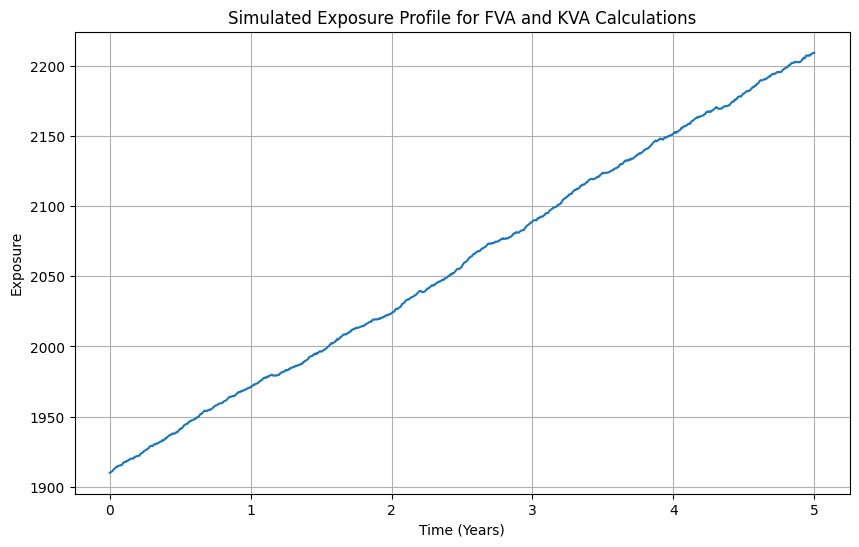

In [46]:
import numpy as np
from scipy.interpolate import CubicSpline, RectBivariateSpline
from scipy.stats import norm
import random
import matplotlib.pyplot as plt

def generate_random_market_rates(tenors):
    """Generate random market rates for given tenors."""
    return np.array([(t, random.uniform(0.01, 0.05)) for t in tenors])

def bootstrap_zero_curve(market_rates):
    """Bootstrap zero rates from market rates."""
    tenors, rates = market_rates[:, 0], market_rates[:, 1]
    zero_rates = [rates[0]]

    for i in range(1, len(tenors)):
        t = tenors[i]
        r = rates[i]
        sum_term = sum(zero_rates[j] * tenors[j] *
                       (1 - np.exp(-zero_rates[j] * (t - tenors[j])))
                       for j in range(i))
        zero_rate = -np.log(1 - r * t + sum_term) / t
        zero_rates.append(zero_rate)

    return np.column_stack((tenors, zero_rates))

def construct_yield_curve(market_rates):
    """Construct yield curve using bootstrapping and cubic spline interpolation."""
    zero_rates = bootstrap_zero_curve(market_rates)
    return CubicSpline(zero_rates[:, 0], zero_rates[:, 1], extrapolate=True)

def generate_forward_rates(spot_rate, tenor, volatility=0.1):
    times = np.arange(1, tenor + 1)
    forward_rates = spot_rate * np.exp(np.cumsum(np.random.normal(0, volatility, tenor)))
    return np.column_stack((times, forward_rates))

def generate_volatility_surface(tenors, strikes, base_vol=0.2, vol_of_vol=0.3):
    """Generate a random volatility surface."""
    vols = np.zeros((len(tenors), len(strikes)))
    for i, t in enumerate(tenors):
        for j, k in enumerate(strikes):
            vols[i, j] = base_vol + vol_of_vol * (np.random.random() - 0.5) * np.sqrt(t)
    return RectBivariateSpline(tenors, strikes, vols)

def black_scholes(S, K, T, r, sigma, option_type='call'):
    """Price an option using the Black-Scholes formula."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:  # put
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# BEGIN MODIFICATIONS FOR CAPITAL COSTS AND FUNDING COSTS

def simulate_exposure_gbm(S0, mu, sigma, T, steps, simulations):
    """Simulate exposure profile using Geometric Brownian Motion."""
    dt = T / steps
    exposures = np.zeros((simulations, steps))
    exposures[:, 0] = S0
    for t in range(1, steps):
        z = np.random.standard_normal(simulations)
        exposures[:, t] = exposures[:, t - 1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
    return exposures.mean(axis=0)

def calculate_fva(exposure_profile, funding_spread, discount_factors):
    """Calculate the Funding Valuation Adjustment (FVA)."""
    fva = np.sum(exposure_profile * funding_spread * discount_factors)
    return fva

def calculate_kva(exposure_profile, capital_requirement, cost_of_capital, discount_factors):
    """Calculate the Capital Valuation Adjustment (KVA)."""
    kva = np.sum(exposure_profile * capital_requirement * cost_of_capital * discount_factors)
    return kva

# END MODIFICATIONS

def price_currency_swap(notional_dom, notional_for, spot_rate,
                        dom_disc_curve, for_disc_curve,
                        dom_proj_curve, for_proj_curve,
                        dom_fixed_rate, for_fixed_rate, tenor, payment_freq,
                        basis_spread, forward_rates):

    # Convert annual rates to payment frequency
    dom_fixed_rate /= payment_freq
    for_fixed_rate /= payment_freq
    basis_spread /= payment_freq

    # Generate payment dates
    payment_dates = np.arange(payment_freq, tenor + payment_freq, payment_freq)

    # Interpolate forward rates
    fwd_rate = CubicSpline(forward_rates[:, 0], forward_rates[:, 1], extrapolate=True)

    # Calculate present values
    dom_pv = 0
    for_pv = 0

    for i, date in enumerate(payment_dates):
        dom_df = np.exp(-dom_disc_curve(date) * date)
        for_df = np.exp(-for_disc_curve(date) * date)

        # Use projection curves for floating rates
        if i == 0:
            dom_proj_rate = dom_proj_curve(date)
            for_proj_rate = for_proj_curve(date)
        else:
            prev_date = payment_dates[i - 1]
            dom_proj_rate = (np.exp(dom_proj_curve(date) * date - dom_proj_curve(prev_date) * prev_date) - 1) / (date - prev_date)
            for_proj_rate = (np.exp(for_proj_curve(date) * date - for_proj_curve(prev_date) * prev_date) - 1) / (date - prev_date)

        dom_pv += notional_dom * (dom_fixed_rate - dom_proj_rate / payment_freq) * dom_df
        for_pv += notional_for * (for_fixed_rate + basis_spread - for_proj_rate / payment_freq) * for_df

    # Add final notional exchange
    dom_pv += notional_dom * np.exp(-dom_disc_curve(tenor) * tenor)
    for_pv += notional_for * np.exp(-for_disc_curve(tenor) * tenor)

    # Convert foreign PV to domestic currency using forward rate
    for_pv_in_dom = for_pv * fwd_rate(tenor)

    # Calculate swap value
    swap_value = dom_pv - for_pv_in_dom

    # Calculate exposure profile (for XVA calculations)
    exposure_profile = np.zeros(len(payment_dates))
    for i, date in enumerate(payment_dates):
        dom_pv_at_date = sum([notional_dom * (dom_fixed_rate - dom_proj_curve(t) / payment_freq) * np.exp(-dom_disc_curve(t - date) * (t - date)) for t in payment_dates[i:]])
        for_pv_at_date = sum([notional_for * (for_fixed_rate + basis_spread - for_proj_curve(t) / payment_freq) * np.exp(-for_disc_curve(t - date) * (t - date)) for t in payment_dates[i:]])
        exposure = dom_pv_at_date - for_pv_at_date * fwd_rate(date)
        exposure_profile[i] = max(0, exposure)

    return swap_value, exposure_profile, payment_dates

def price_currency_swap_with_options(notional_dom, notional_for, spot_rate,
                                     dom_disc_curve, for_disc_curve,
                                     dom_proj_curve, for_proj_curve,
                                     dom_fixed_rate, for_fixed_rate, tenor, payment_freq,
                                     basis_spread, forward_rates, vol_surface,
                                     option_details):

    swap_value, exposure_profile, payment_dates = price_currency_swap(
        notional_dom, notional_for, spot_rate,
        dom_disc_curve, for_disc_curve,
        dom_proj_curve, for_proj_curve,
        dom_fixed_rate, for_fixed_rate, tenor, payment_freq,
        basis_spread, forward_rates
    )

    # Price embedded options
    option_value = 0
    for option in option_details:
        S = forward_rates[option['expiry'] - 1, 1]  # Forward rate at expiry
        K = option['strike']
        T = option['expiry']
        r = dom_disc_curve(T)  # Use domestic discount rate
        sigma = vol_surface(T, K)[0][0]  # Get volatility from surface

        option_price = black_scholes(S, K, T, r, sigma, option['type'])
        option_value += option_price * option['notional'] * (1 if option['long'] else -1)

    total_value = swap_value + option_value

    return total_value, exposure_profile, payment_dates

def calculate_cva(exposure_profile, payment_dates, pd_curve, lgd):
    cva = 0
    for i, exposure in enumerate(exposure_profile):
        default_prob = pd_curve(payment_dates[i]) - pd_curve(payment_dates[i - 1]) if i > 0 else pd_curve(payment_dates[0])
        cva += exposure * default_prob * lgd
    return cva

# Example usage with random data
notional_dom = 1000000  # Domestic currency notional
notional_for = 900000   # Foreign currency notional
spot_rate = random.uniform(1.05, 1.15)  # Random spot exchange rate (DOM/FOR)
tenor = 5               # Swap tenor in years
payment_freq = 2        # Payments per year

# Generate random market data
market_tenors = [0.25, 0.5, 1, 2, 3, 5, 7, 10]
dom_disc_rates = generate_random_market_rates(market_tenors)
for_disc_rates = generate_random_market_rates(market_tenors)
dom_proj_rates = generate_random_market_rates(market_tenors)
for_proj_rates = generate_random_market_rates(market_tenors)

# Construct yield curves
dom_disc_curve = construct_yield_curve(dom_disc_rates)
for_disc_curve = construct_yield_curve(for_disc_rates)
dom_proj_curve = construct_yield_curve(dom_proj_rates)
for_proj_curve = construct_yield_curve(for_proj_rates)

dom_fixed_rate = random.uniform(0.02, 0.04)  # Random domestic fixed rate (annual)
for_fixed_rate = random.uniform(0.01, 0.03)  # Random foreign fixed rate (annual)
basis_spread = random.uniform(0.001, 0.005)  # Random basis spread (annual)
forward_rates = generate_forward_rates(spot_rate, tenor)  # Generate random forward rates

# Generate volatility surface
vol_tenors = np.linspace(0.5, 5, 10)
vol_strikes = np.linspace(0.8, 1.2, 9) * spot_rate
vol_surface = generate_volatility_surface(vol_tenors, vol_strikes)

# Define embedded options (example)
option_details = [
    {'type': 'call', 'strike': spot_rate * 1.1, 'expiry': 2, 'notional': notional_for / 2, 'long': True},
    {'type': 'put', 'strike': spot_rate * 0.9, 'expiry': 3, 'notional': notional_for / 2, 'long': False}
]

# Calculate swap value with embedded options
swap_value, exposure_profile, payment_dates = price_currency_swap_with_options(
    notional_dom, notional_for, spot_rate,
    dom_disc_curve, for_disc_curve,
    dom_proj_curve, for_proj_curve,
    dom_fixed_rate, for_fixed_rate, tenor, payment_freq,
    basis_spread, forward_rates, vol_surface,
    option_details
)

# BEGIN ADDITIONAL CALCULATIONS FOR FVA AND KVA

# Parameters for FVA and KVA
num_simulations = 10000
time_steps = int(tenor * 252)  # Daily steps for the swap tenor
T = tenor
funding_spread = random.uniform(0.002, 0.005)  # Funding spread (annualized)
cost_of_capital = 0.1  # Cost of capital
capital_requirement = 0.08  # Regulatory capital requirement

# Simulate Exposure Profile using GBM
S0 = np.mean(exposure_profile)  # Starting exposure
mu = 0.03  # Drift
sigma = 0.2  # Volatility

simulated_exposure_profile = simulate_exposure_gbm(S0, mu, sigma, T, time_steps, num_simulations)

# Discount Factors
risk_free_rate = dom_disc_curve(T)
discount_factors = np.exp(-risk_free_rate * np.linspace(0, T, time_steps))

# Calculate FVA and KVA
fva = calculate_fva(simulated_exposure_profile, funding_spread, discount_factors)
kva = calculate_kva(simulated_exposure_profile, capital_requirement, cost_of_capital, discount_factors)

# END ADDITIONAL CALCULATIONS

# Define probability of default curve (random example)
pd_times = np.array([0, 1, 2, 3, 4, 5])
pd_values = np.cumsum(np.random.uniform(0, 0.01, 6))
pd_curve = CubicSpline(pd_times, pd_values, extrapolate=True)

# Calculate CVA
lgd = random.uniform(0.5, 0.7)  # Random Loss Given Default
cva = calculate_cva(exposure_profile, payment_dates, pd_curve, lgd)

# Total XVA adjustments
total_xva = cva + fva + kva

# Print results
print(f"Spot Rate: {spot_rate:.4f}")
print(f"Domestic Fixed Rate: {dom_fixed_rate * payment_freq:.4f}")
print(f"Foreign Fixed Rate: {for_fixed_rate * payment_freq:.4f}")
print(f"Basis Spread: {basis_spread * payment_freq:.4f}")
print(f"Loss Given Default: {lgd:.4f}")
print("Domestic Discount Curve:")
for tenor, rate in dom_disc_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("Foreign Discount Curve:")
for tenor, rate in for_disc_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("Domestic Projection Curve:")
for tenor, rate in dom_proj_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("Foreign Projection Curve:")
for tenor, rate in for_proj_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("Forward Rates:")
for time, rate in forward_rates:
    print(f"  Year {time}: {rate:.4f}")
print("Volatility Surface (sample points):")
for t in [1, 3, 5]:
    for k in [0.9, 1.0, 1.1]:
        print(f"  T={t}, K={k * spot_rate:.4f}: {vol_surface(t, k * spot_rate)[0][0]:.4f}")
print("Embedded Options:")
for option in option_details:
    print(f"  Type: {option['type']}, Strike: {option['strike']:.4f}, Expiry: {option['expiry']} years, Notional: {option['notional']}, Long: {option['long']}")
print(f"The value of the currency swap with embedded options is: {swap_value:.2f}")
print(f"The Credit Valuation Adjustment (CVA): {cva:.2f}")
print(f"The Funding Valuation Adjustment (FVA): {fva:.2f}")
print(f"The Capital Valuation Adjustment (KVA): {kva:.2f}")
print(f"The Total XVA Adjustments (CVA + FVA + KVA): {total_xva:.2f}")
print(f"The XVA-adjusted value of the currency swap with options is: {swap_value - total_xva:.2f}")

# Optional: Plot simulated exposure profile
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, T, time_steps), simulated_exposure_profile)
plt.xlabel("Time (Years)")
plt.ylabel("Exposure")
plt.title("Simulated Exposure Profile for FVA and KVA Calculations")
plt.grid(True)
plt.show()

CHANGE VOLATILITY SURFACE MODEL TO MORE ACCURATE ONE (EG SABR)

SABR works well for FX markets (Vanila swap). May try Heston for exotic currency swap. SVI for dynamic risk management. Also combination of SABR and SVI might work well

Spot Rate: 1.0540
Domestic Fixed Rate: 0.0486
Foreign Fixed Rate: 0.0534
Basis Spread: 0.0051
Loss Given Default: 0.6063

Domestic Discount Curve:
  0.25 year: 0.0181
  0.50 year: 0.0490
  1.00 year: 0.0272
  2.00 year: 0.0267
  3.00 year: 0.0291
  5.00 year: 0.0168
  7.00 year: 0.0104
  10.00 year: 0.0376

Foreign Discount Curve:
  0.25 year: 0.0102
  0.50 year: 0.0228
  1.00 year: 0.0121
  2.00 year: 0.0471
  3.00 year: 0.0298
  5.00 year: 0.0476
  7.00 year: 0.0124
  10.00 year: 0.0188

Domestic Projection Curve:
  0.25 year: 0.0480
  0.50 year: 0.0387
  1.00 year: 0.0410
  2.00 year: 0.0276
  3.00 year: 0.0261
  5.00 year: 0.0161
  7.00 year: 0.0438
  10.00 year: 0.0296

Foreign Projection Curve:
  0.25 year: 0.0199
  0.50 year: 0.0328
  1.00 year: 0.0392
  2.00 year: 0.0202
  3.00 year: 0.0214
  5.00 year: 0.0189
  7.00 year: 0.0483
  10.00 year: 0.0466

Forward Rates:
  Year 1.0: 0.8740
  Year 2.0: 1.0249
  Year 3.0: 0.8983
  Year 4.0: 0.8465
  Year 5.0: 0.8325

Volatility Surfac

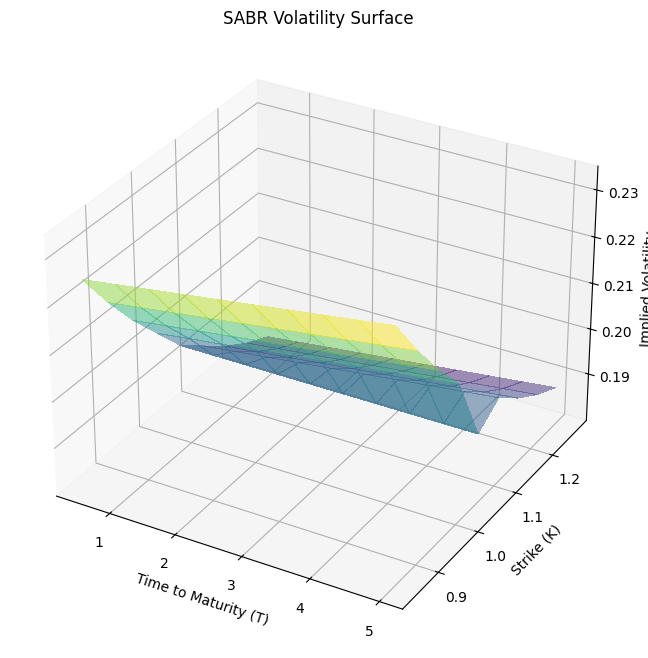

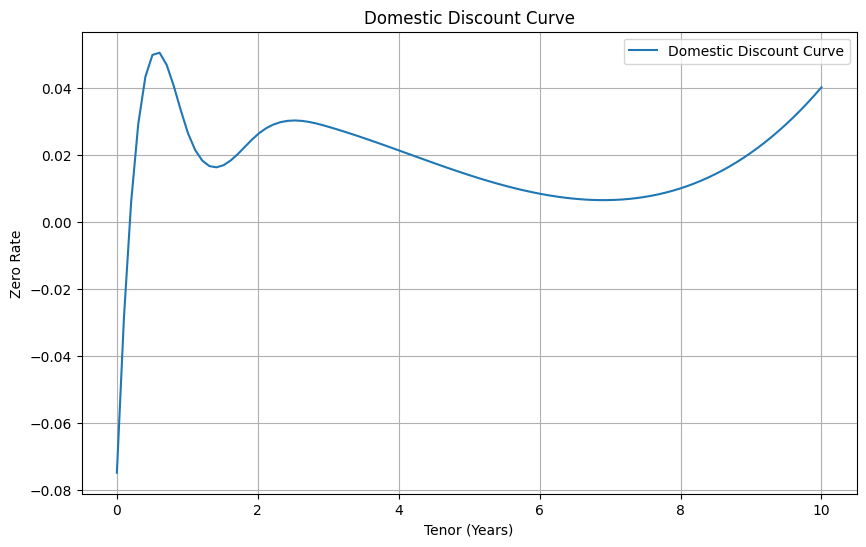

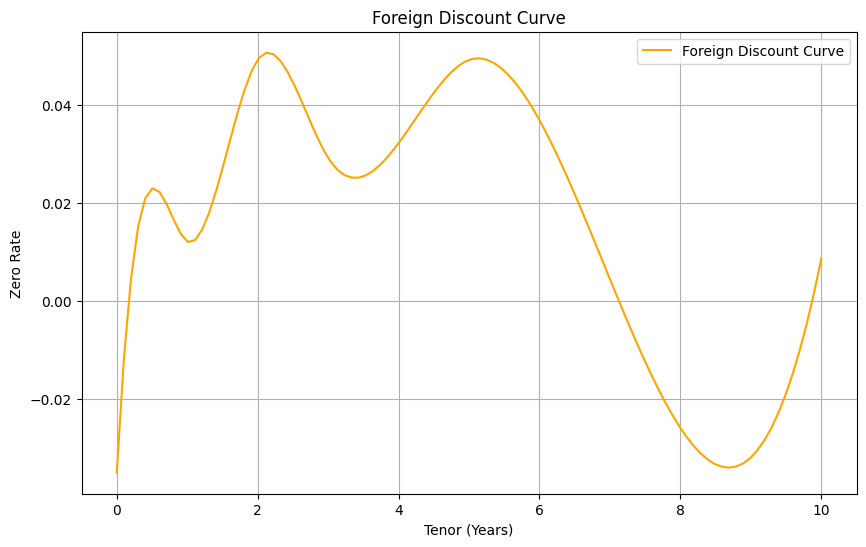

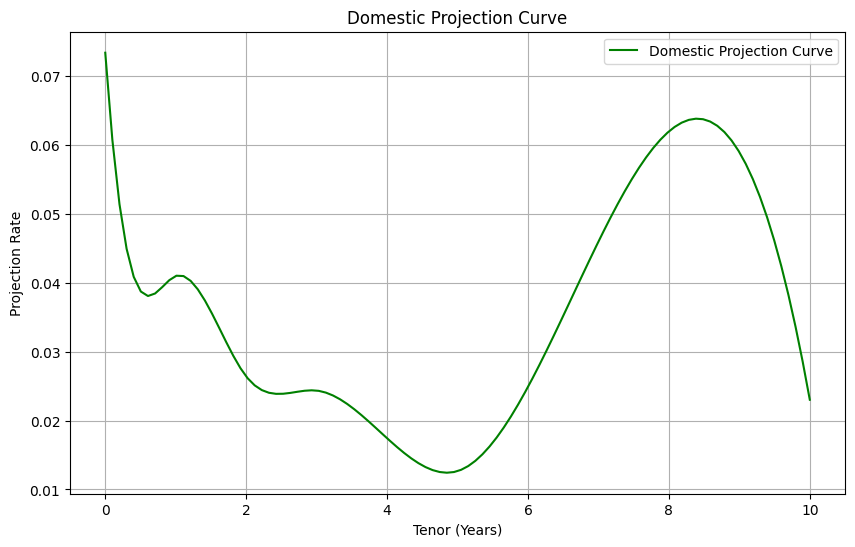

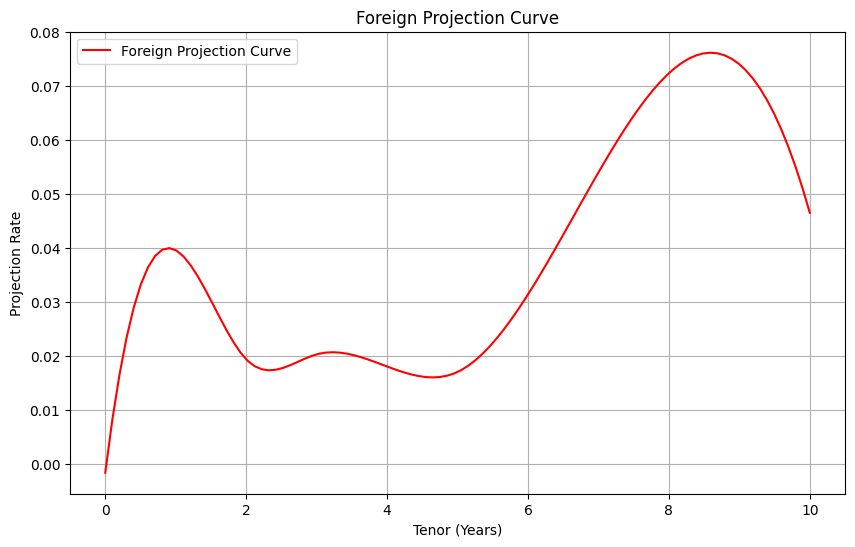

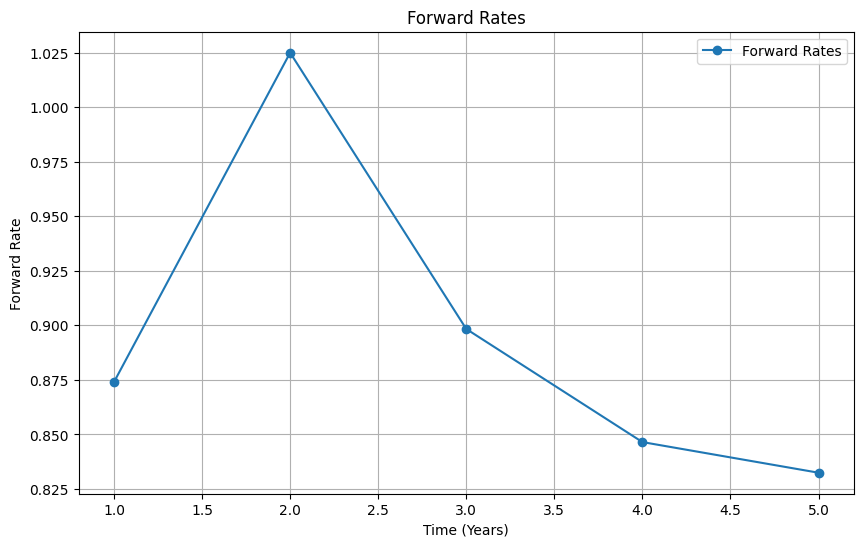

In [ ]:
import numpy as np
from scipy.interpolate import CubicSpline, RectBivariateSpline
from scipy.stats import norm
import random
import matplotlib.pyplot as plt
from scipy.special import erf

def generate_random_market_rates(tenors):
    """Generate random market rates for given tenors."""
    return np.array([(t, random.uniform(0.01, 0.05)) for t in tenors])

def bootstrap_zero_curve(market_rates):
    """Bootstrap zero rates from market rates."""
    tenors, rates = market_rates[:, 0], market_rates[:, 1]
    zero_rates = [rates[0]]

    for i in range(1, len(tenors)):
        t = tenors[i]
        r = rates[i]
        sum_term = sum(zero_rates[j] * tenors[j] *
                       (1 - np.exp(-zero_rates[j] * (t - tenors[j])))
                       for j in range(i))
        zero_rate = -np.log(1 - r * t + sum_term) / t
        zero_rates.append(zero_rate)

    return np.column_stack((tenors, zero_rates))

def construct_yield_curve(market_rates):
    """Construct yield curve using bootstrapping and cubic spline interpolation."""
    zero_rates = bootstrap_zero_curve(market_rates)
    return CubicSpline(zero_rates[:, 0], zero_rates[:, 1], extrapolate=True)

def generate_forward_rates(spot_rate, tenor, volatility=0.1):
    times = np.arange(1, tenor + 1)
    forward_rates = spot_rate * np.exp(np.cumsum(np.random.normal(0, volatility, tenor)))
    return np.column_stack((times, forward_rates))

def black_scholes(S, K, T, r, sigma, option_type='call'):
    """Price an option using the Black-Scholes formula."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:  # put
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


def sabr_implied_volatility(F, K, T, alpha, beta, rho, nu):
    """Compute SABR implied volatility using Hagan's approximation."""
    if F == K:
        num = alpha
        denom = F ** (1 - beta)
        vol = num / denom
    else:
        FK = F * K
        log_FK = np.log(F / K)
        z = (nu / alpha) * (FK) ** ((1 - beta) / 2) * log_FK
        x_z = np.log((np.sqrt(1 - 2 * rho * z + z ** 2) + z - rho) / (1 - rho))
        gamma1 = (1 - beta) / (F - K)
        gamma2 = (1 - beta) * (2 - beta) / ((F - K) ** 2)
        vol = (alpha / (FK) ** ((1 - beta) / 2)) * (z / x_z) * \
              (1 + (( ( ( (1 - beta) ** 2 ) / 24 ) * (alpha ** 2) / ( (FK) ** (1 - beta) ) ) +
                    (rho * beta * nu * alpha ) / (4 * (FK) ** ( (1 - beta) / 2 )) +
                    ( (2 - 3 * rho ** 2 ) * nu ** 2 ) / 24 ) * T)
    return vol

def generate_volatility_surface_sabr(tenors, strikes, F0, alpha, beta, rho, nu):
    """Generate a volatility surface using the SABR model."""
    vols = np.zeros((len(tenors), len(strikes)))
    for i, T in enumerate(tenors):
        for j, K in enumerate(strikes):
            vols[i, j] = sabr_implied_volatility(F0, K, T, alpha, beta, rho, nu)
    return RectBivariateSpline(tenors, strikes, vols)


def price_currency_swap(notional_dom, notional_for, spot_rate,
                        dom_disc_curve, for_disc_curve,
                        dom_proj_curve, for_proj_curve,
                        dom_fixed_rate, for_fixed_rate, tenor, payment_freq,
                        basis_spread, forward_rates):

    # Convert annual rates to payment frequency
    dom_fixed_rate /= payment_freq
    for_fixed_rate /= payment_freq
    basis_spread /= payment_freq

    # Generate payment dates
    payment_dates = np.arange(payment_freq, tenor + payment_freq, payment_freq)

    # Interpolate forward rates
    fwd_rate = CubicSpline(forward_rates[:, 0], forward_rates[:, 1], extrapolate=True)

    # Calculate present values
    dom_pv = 0
    for_pv = 0

    for i, date in enumerate(payment_dates):
        dom_df = np.exp(-dom_disc_curve(date) * date)
        for_df = np.exp(-for_disc_curve(date) * date)

        # Use projection curves for floating rates
        if i == 0:
            dom_proj_rate = dom_proj_curve(date)
            for_proj_rate = for_proj_curve(date)
        else:
            prev_date = payment_dates[i - 1]
            dom_proj_rate = (np.exp(dom_proj_curve(date) * date - dom_proj_curve(prev_date) * prev_date) - 1) / (date - prev_date)
            for_proj_rate = (np.exp(for_proj_curve(date) * date - for_proj_curve(prev_date) * prev_date) - 1) / (date - prev_date)

        dom_pv += notional_dom * (dom_fixed_rate - dom_proj_rate / payment_freq) * dom_df
        for_pv += notional_for * (for_fixed_rate + basis_spread - for_proj_rate / payment_freq) * for_df

    # Add final notional exchange
    dom_pv += notional_dom * np.exp(-dom_disc_curve(tenor) * tenor)
    for_pv += notional_for * np.exp(-for_disc_curve(tenor) * tenor)

    # Convert foreign PV to domestic currency using forward rate
    for_pv_in_dom = for_pv * fwd_rate(tenor)

    # Calculate swap value
    swap_value = dom_pv - for_pv_in_dom

    # Calculate exposure profile
    exposure_profile = np.zeros(len(payment_dates))
    for i, date in enumerate(payment_dates):
        dom_pv_at_date = sum([notional_dom * (dom_fixed_rate - dom_proj_curve(t) / payment_freq) * np.exp(-dom_disc_curve(t - date) * (t - date)) for t in payment_dates[i:]])
        for_pv_at_date = sum([notional_for * (for_fixed_rate + basis_spread - for_proj_curve(t) / payment_freq) * np.exp(-for_disc_curve(t - date) * (t - date)) for t in payment_dates[i:]])
        exposure = dom_pv_at_date - for_pv_at_date * fwd_rate(date)
        exposure_profile[i] = max(0, exposure)

    return swap_value, exposure_profile, payment_dates

def price_currency_swap_with_options(notional_dom, notional_for, spot_rate,
                                     dom_disc_curve, for_disc_curve,
                                     dom_proj_curve, for_proj_curve,
                                     dom_fixed_rate, for_fixed_rate, tenor, payment_freq,
                                     basis_spread, forward_rates, vol_surface,
                                     option_details):

    swap_value, exposure_profile, payment_dates = price_currency_swap(
        notional_dom, notional_for, spot_rate,
        dom_disc_curve, for_disc_curve,
        dom_proj_curve, for_proj_curve,
        dom_fixed_rate, for_fixed_rate, tenor, payment_freq,
        basis_spread, forward_rates
    )

    # Price embedded options
    option_value = 0
    for option in option_details:
        S = forward_rates[option['expiry'] - 1, 1]  # Forward rate at expiry
        K = option['strike']
        T = option['expiry']
        r = dom_disc_curve(T)  # Use domestic discount rate
        sigma = vol_surface(T, K)[0][0]  # Get volatility from surface

        option_price = black_scholes(S, K, T, r, sigma, option['type'])
        option_value += option_price * option['notional'] * (1 if option['long'] else -1)

    total_value = swap_value + option_value

    return total_value, exposure_profile, payment_dates

def calculate_cva(exposure_profile, payment_dates, pd_curve, lgd):
    cva = 0
    for i, exposure in enumerate(exposure_profile):
        default_prob = pd_curve(payment_dates[i]) - pd_curve(payment_dates[i - 1]) if i > 0 else pd_curve(payment_dates[0])
        cva += exposure * default_prob * lgd
    return cva

# Example usage with random data
notional_dom = 1000000  # Domestic currency notional
notional_for = 900000   # Foreign currency notional
spot_rate = random.uniform(1.05, 1.15)  # Random spot exchange rate (DOM/FOR)
tenor = 5               # Swap tenor in years
payment_freq = 2        # Payments per year

market_tenors = [0.25, 0.5, 1, 2, 3, 5, 7, 10]
dom_disc_rates = generate_random_market_rates(market_tenors)
for_disc_rates = generate_random_market_rates(market_tenors)
dom_proj_rates = generate_random_market_rates(market_tenors)
for_proj_rates = generate_random_market_rates(market_tenors)

# Construct yield curves
dom_disc_curve = construct_yield_curve(dom_disc_rates)
for_disc_curve = construct_yield_curve(for_disc_rates)
dom_proj_curve = construct_yield_curve(dom_proj_rates)
for_proj_curve = construct_yield_curve(for_proj_rates)

dom_fixed_rate = random.uniform(0.02, 0.04)  # Random domestic fixed rate (annual)
for_fixed_rate = random.uniform(0.01, 0.03)  # Random foreign fixed rate (annual)
basis_spread = random.uniform(0.001, 0.005)  # Random basis spread (annual)
forward_rates = generate_forward_rates(spot_rate, tenor)  # Generate random forward rates


# SABR model parameters
alpha = 0.2  # Volatility of volatility
beta = 0.5   # Elasticity parameter (0 for lognormal, 1 for normal)
rho = -0.3   # Correlation between asset price and volatility
nu = 0.4     # Volatility of the volatility

vol_tenors = np.linspace(0.5, tenor, int(tenor * 2))
vol_strikes = np.linspace(0.8, 1.2, 9) * spot_rate

vol_surface = generate_volatility_surface_sabr(vol_tenors, vol_strikes, spot_rate, alpha, beta, rho, nu)

option_details = [
    {'type': 'call', 'strike': spot_rate * 1.1, 'expiry': 2, 'notional': notional_for / 2, 'long': True},
    {'type': 'put', 'strike': spot_rate * 0.9, 'expiry': 3, 'notional': notional_for / 2, 'long': False}
]

swap_value, exposure_profile, payment_dates = price_currency_swap_with_options(
    notional_dom, notional_for, spot_rate,
    dom_disc_curve, for_disc_curve,
    dom_proj_curve, for_proj_curve,
    dom_fixed_rate, for_fixed_rate, tenor, payment_freq,
    basis_spread, forward_rates, vol_surface,
    option_details
)


pd_times = np.array([0, 1, 2, 3, 4, 5])
pd_values = np.cumsum(np.random.uniform(0, 0.01, 6))
pd_curve = CubicSpline(pd_times, pd_values, extrapolate=True)

#SEE XVAs FILE FOR CLARIFICATION
lgd = random.uniform(0.5, 0.7) 
cva = calculate_cva(exposure_profile, payment_dates, pd_curve, lgd)

print(f"Spot Rate: {spot_rate:.4f}")
print(f"Domestic Fixed Rate: {dom_fixed_rate * payment_freq:.4f}")
print(f"Foreign Fixed Rate: {for_fixed_rate * payment_freq:.4f}")
print(f"Basis Spread: {basis_spread * payment_freq:.4f}")
print(f"Loss Given Default: {lgd:.4f}\n")
print("Domestic Discount Curve:")
for tenor, rate in dom_disc_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("\nForeign Discount Curve:")
for tenor, rate in for_disc_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("\nDomestic Projection Curve:")
for tenor, rate in dom_proj_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("\nForeign Projection Curve:")
for tenor, rate in for_proj_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("\nForward Rates:")
for time, rate in forward_rates:
    print(f"  Year {time}: {rate:.4f}")
print("\nVolatility Surface (SABR Model) Sample Points:")
for T in [1, 3, 5]:
    for K in [0.9, 1.0, 1.1]:
        vol = vol_surface(T, K * spot_rate)[0][0]
        print(f"  T={T}, K={K * spot_rate:.4f}: Vol={vol:.4f}")
print("\nEmbedded Options:")
for option in option_details:
    print(f"  Type: {option['type']}, Strike: {option['strike']:.4f}, Expiry: {option['expiry']} years, Notional: {option['notional']}, Long: {option['long']}")
print(f"\nThe value of the currency swap with embedded options is: {swap_value:.2f}")
print(f"The Credit Valuation Adjustment (CVA): {cva:.2f}")
print(f"The CVA-adjusted value of the currency swap with options is: {swap_value - cva:.2f}")

vol_tenors = np.sort(vol_tenors)
vol_strikes = np.sort(vol_strikes)

T_grid, K_grid = np.meshgrid(vol_tenors, vol_strikes)

vols = vol_surface(T_grid.ravel(), K_grid.ravel(), grid=False).reshape(T_grid.shape)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    T_grid, K_grid, vols,
    cmap='viridis',
    edgecolor='none',
    linewidth=0,
    antialiased=False,
    alpha=0.5  # Set transparency to 50%
)

ax.set_xlabel('Time to Maturity (T)')
ax.set_ylabel('Strike (K)')
ax.set_zlabel('Implied Volatility')
ax.set_title('SABR Volatility Surface')
plt.show()



# Construct yield curves
dom_disc_curve = construct_yield_curve(dom_disc_rates)
for_disc_curve = construct_yield_curve(for_disc_rates)
dom_proj_curve = construct_yield_curve(dom_proj_rates)
for_proj_curve = construct_yield_curve(for_proj_rates)

# Define tenor range for plotting
tenor_range = np.linspace(0, max(market_tenors), 100)

# Plot Domestic Discount Curve
dom_zero_rates = dom_disc_curve(tenor_range)
plt.figure(figsize=(10, 6))
plt.plot(tenor_range, dom_zero_rates, label='Domestic Discount Curve')
plt.title('Domestic Discount Curve')
plt.xlabel('Tenor (Years)')
plt.ylabel('Zero Rate')
plt.legend()
plt.grid(True)
plt.show()

# Plot Foreign Discount Curve
for_zero_rates = for_disc_curve(tenor_range)
plt.figure(figsize=(10, 6))
plt.plot(tenor_range, for_zero_rates, label='Foreign Discount Curve', color='orange')
plt.title('Foreign Discount Curve')
plt.xlabel('Tenor (Years)')
plt.ylabel('Zero Rate')
plt.legend()
plt.grid(True)
plt.show()

# Plot Domestic Projection Curve
dom_proj_rates_interp = dom_proj_curve(tenor_range)
plt.figure(figsize=(10, 6))
plt.plot(tenor_range, dom_proj_rates_interp, label='Domestic Projection Curve', color='green')
plt.title('Domestic Projection Curve')
plt.xlabel('Tenor (Years)')
plt.ylabel('Projection Rate')
plt.legend()
plt.grid(True)
plt.show()

# Plot Foreign Projection Curve
for_proj_rates_interp = for_proj_curve(tenor_range)
plt.figure(figsize=(10, 6))
plt.plot(tenor_range, for_proj_rates_interp, label='Foreign Projection Curve', color='red')
plt.title('Foreign Projection Curve')
plt.xlabel('Tenor (Years)')
plt.ylabel('Projection Rate')
plt.legend()
plt.grid(True)
plt.show()

# Plot Forward Rates
plt.figure(figsize=(10, 6))
plt.plot(forward_rates[:, 0], forward_rates[:, 1], label='Forward Rates', marker='o')
plt.title('Forward Rates')
plt.xlabel('Time (Years)')
plt.ylabel('Forward Rate')
plt.legend()
plt.grid(True)
plt.show()




# Currency Swap Pricing and Analysis

This repository provides a Python implementation for pricing **currency swaps**, generating volatility surfaces, and calculating Credit Valuation Adjustment (CVA). The implementation supports yield curve construction, forward rate modeling, and embedded option valuation.

---

## Features
- **Market Data Generation**: Generate random discount and projection rates.
- **Yield Curve Construction**: Bootstrap zero-coupon yield curves and interpolate them.
- **Volatility Surface Modeling**: Use the **SABR model** for implied volatility surfaces.
- **Currency Swap Valuation**:
  - Compute present value for fixed and floating legs.
  - Handle optional basis spreads.
- **Embedded Option Pricing**: Use the **Black-Scholes model** for options in the swap.
- **CVA Calculation**: Estimate CVA based on default probabilities and LGD.
- **Visualizations**:
  - Plot yield curves, forward rates, and volatility surfaces.

---

## Table of Contents
1. [Methods Overview](#methods-overview)
2. [Inputs](#inputs)
3. [Outputs](#outputs)
4. [Example Usage](#example-usage)
5. [Requirements](#requirements)
6. [Acknowledgments](#acknowledgments)

---

## Methods Overview

### Market Data Generation
- `generate_random_market_rates(tenors)`: Generates random market rates for specified tenors.

### Yield Curve Construction
- `bootstrap_zero_curve(market_rates)`: Bootstraps zero rates from market rates.
- `construct_yield_curve(market_rates)`: Constructs a yield curve using cubic spline interpolation.

### Volatility Surface
- **SABR Model**:
  - `sabr_implied_volatility(F, K, T, alpha, beta, rho, nu)`: Computes implied volatility.
  - `generate_volatility_surface_sabr(tenors, strikes, F0, alpha, beta, rho, nu)`: Builds a SABR volatility surface.

### Currency Swap Pricing
- `price_currency_swap(...)`: Calculates the present value of a currency swap.
- `price_currency_swap_with_options(...)`: Extends swap valuation with embedded options.

### Credit Valuation Adjustment
- `calculate_cva(exposure_profile, payment_dates, pd_curve, lgd)`: Computes CVA using exposure, default probabilities, and LGD.

---

## Inputs

### 1. Market Data
- **Tenors**: List of maturities for rates (e.g., `[0.25, 0.5, 1, 2, 5, 10]`).
- **Spot Rate**: FX spot rate between domestic and foreign currencies.
- **Discount and Projection Rates**: Market rates for domestic and foreign currencies.

### 2. Swap Parameters
- **Notional Amounts**: Domestic (`notional_dom`) and foreign (`notional_for`).
- **Fixed Rates**: Annualized domestic and foreign fixed rates.
- **Basis Spread**: Spread for floating rates.
- **Tenor**: Total duration of the swap.
- **Payment Frequency**: Number of payments per year.

### 3. Embedded Options
- Options in the swap are provided as a list of dictionaries:
  ```python
  option_details = [
      {'type': 'call', 'strike': 1.1, 'expiry': 2, 'notional': 500000, 'long': True},
      {'type': 'put', 'strike': 0.9, 'expiry': 3, 'notional': 500000, 'long': False}
  ]
  ```

### 4. SABR Model Parameters
- `alpha`: Volatility of the volatility.
- `beta`: Elasticity parameter (controls smile).
- `rho`: Correlation between forward rate and volatility.
- `nu`: Volatility of volatility.

### 5. CVA Parameters
- **Default Probability Curve (`pd_curve`)**: Provided as a cubic spline.
- **Loss Given Default (`lgd`)**: Fraction of exposure lost in default.

---

## Outputs

1. **Swap Value**:
   - Net present value of the swap, including embedded options.
2. **Exposure Profile**:
   - Future exposure at each payment date.
3. **Credit Valuation Adjustment (CVA)**:
   - Adjustment for counterparty risk.
4. **Visualizations**:
   - Yield curves, forward rates, and volatility surfaces.

---

## Example Usage

```python
# Import necessary libraries
import numpy as np
import random

# Notional values and market parameters
notional_dom = 1_000_000
notional_for = 900_000
spot_rate = 1.1
tenor = 5
payment_freq = 2

# Generate random market rates
market_tenors = [0.25, 0.5, 1, 2, 5, 10]
dom_disc_rates = generate_random_market_rates(market_tenors)
for_disc_rates = generate_random_market_rates(market_tenors)

# Construct yield curves
dom_disc_curve = construct_yield_curve(dom_disc_rates)
for_disc_curve = construct_yield_curve(for_disc_rates)

# Generate forward rates
forward_rates = generate_forward_rates(spot_rate, tenor)

# SABR parameters for volatility surface
alpha, beta, rho, nu = 0.2, 0.5, -0.3, 0.4
vol_tenors = np.linspace(0.5, tenor, int(tenor * 2))
vol_strikes = np.linspace(0.8, 1.2, 9) * spot_rate
vol_surface = generate_volatility_surface_sabr(vol_tenors, vol_strikes, spot_rate, alpha, beta, rho, nu)

# Option details
option_details = [
    {'type': 'call', 'strike': 1.1, 'expiry': 2, 'notional': notional_for / 2, 'long': True},
    {'type': 'put', 'strike': 0.9, 'expiry': 3, 'notional': notional_for / 2, 'long': False}
]

# Price the currency swap with options
swap_value, exposure_profile, payment_dates = price_currency_swap_with_options(
    notional_dom, notional_for, spot_rate, dom_disc_curve, for_disc_curve,
    dom_disc_curve, for_disc_curve, 0.03, 0.02, tenor, payment_freq, 0.001, forward_rates,
    vol_surface, option_details
)

# Print results
print(f"Swap Value: {swap_value:.2f}")
```

---

## Requirements
- Python 3.7+
- Libraries: `numpy`, `scipy`, `matplotlib`

---

## Acknowledgments
This implementation is inspired by financial mathematics principles, including:
- Currency swaps and FX options.
- Stochastic modeling using the **SABR model**.
- Risk management via CVA calculations.

---


## Commodity swap

In [2]:
import numpy as np

def price_commodity_swap(fixed_price, floating_prices, notional, discount_factors):
    """
    Calculate the price of a commodity swap.

    :param fixed_price: Fixed price agreed in the swap.
    :param floating_prices: List of expected floating prices for each period.
    :param notional: Notional amount of the swap.
    :param discount_factors: List of discount factors corresponding to payment periods.
    :return: The net present value (NPV) of the swap.
    """
    # Ensure input lengths match
    assert len(floating_prices) == len(discount_factors), "Mismatched periods for floating prices and discount factors."

    # Calculate cash flows for the fixed leg and floating leg
    fixed_leg_cash_flows = [fixed_price * notional for _ in floating_prices]
    floating_leg_cash_flows = [price * notional for price in floating_prices]

    # Discounted cash flows
    fixed_leg_pv = sum(cf * df for cf, df in zip(fixed_leg_cash_flows, discount_factors))
    floating_leg_pv = sum(cf * df for cf, df in zip(floating_leg_cash_flows, discount_factors))

    # Net present value of the swap
    npv = floating_leg_pv - fixed_leg_pv
    return npv

# Example usage:
if __name__ == "__main__":
    fixed_price = 50.0  # Fixed price in USD
    floating_prices = [48, 49, 51, 52]  # Expected floating prices in USD
    notional = 1000  # Notional quantity in barrels
    discount_factors = [0.99, 0.98, 0.97, 0.96]  # Discount factors for each period

    swap_value = price_commodity_swap(fixed_price, floating_prices, notional, discount_factors)
    print(f"The net present value (NPV) of the commodity swap is: ${swap_value:.2f}")


The net present value (NPV) of the commodity swap is: $-70.00


Total Price of Underlying Assets: 50000000.00
Spot Price: 50.00
Fixed Rate: 0.0260

Discount Curve:
  0.25 year: 0.0234
  0.50 year: 0.0262
  1.00 year: 0.0218
  2.00 year: 0.0224
  3.00 year: 0.0258
  5.00 year: 0.0227
  7.00 year: 0.0246
  10.00 year: 0.0278

Forward Commodity Prices:
  Year 1.0: 42.22
  Year 2.0: 54.19
  Year 3.0: 59.74
  Year 4.0: 60.70
  Year 5.0: 44.11

The value of the commodity swap is: 10305280.93


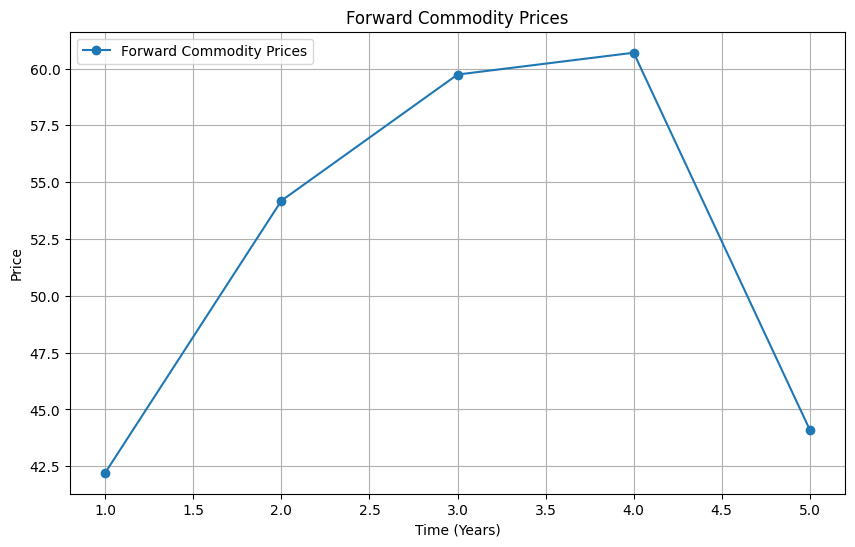

In [44]:
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.stats import norm
import random
import matplotlib.pyplot as plt

def generate_random_market_rates(tenors):
    """Generate random market rates for given tenors."""
    return np.array([(t, random.uniform(0.02, 0.03)) for t in tenors])

def bootstrap_zero_curve(market_rates):
    """Bootstrap zero rates from market rates."""
    tenors, rates = market_rates[:, 0], market_rates[:, 1]
    zero_rates = [rates[0]]

    for i in range(1, len(tenors)):
        t = tenors[i]
        r = rates[i]
        sum_term = sum(zero_rates[j] * tenors[j] *
                       np.exp(-zero_rates[j] * (t - tenors[j])) 
                       for j in range(i))
        zero_rate = -np.log(1 - r * t + sum_term) / t
        zero_rates.append(zero_rate)

    return np.column_stack((tenors, zero_rates))

def construct_yield_curve(market_rates):
    """Construct yield curve using bootstrapping and cubic spline interpolation."""
    zero_rates = bootstrap_zero_curve(market_rates)
    return CubicSpline(zero_rates[:, 0], zero_rates[:, 1], extrapolate=True)

def generate_commodity_forward_prices(spot_price, tenors, drift=0.0, volatility=0.2):
    """Generate commodity forward prices using a geometric Brownian motion model."""
    dt = np.diff([0] + list(tenors))
    cum_drift = np.cumsum((drift - 0.5 * volatility**2) * dt)
    cum_volatility = np.cumsum(volatility * np.sqrt(dt) * np.random.normal(size=len(tenors)))
    log_prices = np.log(spot_price) + cum_drift + cum_volatility
    forward_prices = np.exp(log_prices)
    return np.column_stack((tenors, forward_prices))

def price_commodity_swap(notional, fixed_rate, spot_price,
                         disc_curve, tenor, payment_freq,
                         forward_prices):

    # Convert annual rates to per-period rates
    fixed_rate /= payment_freq

    # Generate payment dates
    payment_dates = np.arange(payment_freq, tenor + payment_freq, payment_freq)

    # Interpolate forward prices
    fwd_price = CubicSpline(forward_prices[:, 0], forward_prices[:, 1], extrapolate=True)

    # Calculate present values
    fixed_leg_pv = 0
    floating_leg_pv = 0

    for date in payment_dates:
        df = np.exp(-disc_curve(date) * date)

        # Fixed leg payment
        fixed_payment = notional * fixed_rate
        fixed_leg_pv += fixed_payment * df

        # Floating leg payment based on forward commodity price
        expected_price = fwd_price(date)
        floating_payment = notional * (expected_price - spot_price)
        floating_leg_pv += floating_payment * df

    # Swap value
    swap_value = floating_leg_pv - fixed_leg_pv

    # Exposure profile (positive expected future values)
    exposure_profile = np.maximum(0, np.cumsum([floating_leg_pv - fixed_leg_pv]))

    return swap_value, exposure_profile, payment_dates

# Example usage with random data
notional = 1000000  # Notional amount (quantity of commodity units)
spot_price = 50.0   # Current spot price of the commodity per unit
tenor = 5           # Swap tenor in years
payment_freq = 1    # Payments per year

market_tenors = [0.25, 0.5, 1, 2, 3, 5, 7, 10]
disc_rates = generate_random_market_rates(market_tenors)

# Construct discount curve
disc_curve = construct_yield_curve(disc_rates)

fixed_rate = random.uniform(0.02, 0.03)  # Random fixed rate (annual)
forward_prices = generate_commodity_forward_prices(
    spot_price, 
    np.arange(payment_freq, tenor + payment_freq, payment_freq)
)

swap_value, exposure_profile, payment_dates = price_commodity_swap(
    notional, fixed_rate, spot_price,
    disc_curve, tenor, payment_freq,
    forward_prices
)

total_underlying_asset_price = notional * spot_price
print(f"Total Price of Underlying Assets: {total_underlying_asset_price:.2f}")

print(f"Spot Price: {spot_price:.2f}")
print(f"Fixed Rate: {fixed_rate * payment_freq:.4f}")
print(f"\nDiscount Curve:")
for tenor, rate in disc_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("\nForward Commodity Prices:")
for time, price in forward_prices:
    print(f"  Year {time}: {price:.2f}")
print(f"\nThe value of the commodity swap is: {swap_value:.2f}")

# Plot Forward Commodity Prices
plt.figure(figsize=(10, 6))
plt.plot(forward_prices[:, 0], forward_prices[:, 1], label='Forward Commodity Prices', marker='o')
plt.title('Forward Commodity Prices')
plt.xlabel('Time (Years)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


## Suggested Improvements for Commodity Swap Pricing Model

This document outlines potential enhancements to the current commodity swap pricing model, aimed at improving accuracy, flexibility, and usability.

---

### **1. Forward Price Modeling**
- **Incorporate Real Market Data**:
  - Replace simulated forward prices with actual forward curves derived from market quotes or futures prices.


- **Introduce Mean-Reverting Models**:
  - Use models such as Ornstein-Uhlenbeck to simulate commodity prices
  - Mean reversion better reflects the behavior of many commodities.

- **Add Seasonality**:
  - Incorporate seasonality factors for commodities with cyclical patterns (e.g., natural gas, electricity).

- **Capture Correlations**:
  - Model correlations between the commodity price and external factors (e.g., crude oil impacting jet fuel).

---

### **2. Discount Curve Construction**
- **Use Real Yield Curves**:
  - Replace random market rates with real-world data from trusted sources (e.g., Bloomberg, Refinitiv, central banks).

- **Adopt Multi-Curve Frameworks**:
  - Use separate curves for collateralized and uncollateralized discounting.
  - Construct zero-coupon curves via bootstrapping.

- **Improve Interpolation**:
  - Use robust interpolation methods like **monotone convex interpolation** to avoid unrealistic dips in the yield curve.

---

### **3. Fixed Leg Calculation**
- **Market-Derived Fixed Rates**:
  - Replace randomly generated fixed rates with actual market-derived swap rates.

- **Day Count Conventions**:
  - Incorporate standard conventions (e.g., actual/actual, 30/360) for accurate time calculations.

---

### **4. Floating Leg Calculation**
- **Align Floating Leg Definitions**:
  - Verify that the floating leg formula aligns with swap contract specifications.

- **Realistic Exposure Modeling**:
  - Simulate multiple paths for floating prices to improve future value estimates.

---

### **5. Randomness in Inputs**
- **Eliminate Random Inputs**:
  - Remove randomness in market rates and fixed rates for consistent results.
  - Use fixed seeds for random number generators when necessary.

- **Stress Testing and Sensitivity Analysis**:
  - Analyze how swap value changes with variations in key inputs (e.g., spot price, volatility, interest rates).

---

### **6. Valuation Adjustments**
- **Credit Valuation Adjustment (CVA)**:
  - Account for counterparty credit risk:
    \[
    \text{CVA} = (1 - \text{Recovery Rate}) \cdot \sum_{t} \text{EE}(t) \cdot \text{PD}(t)
    \]
    where:
    - \(\text{EE}(t)\): Expected exposure.
    - \(\text{PD}(t)\): Probability of default.

- **Funding Valuation Adjustment (FVA)**:
  - Include funding costs for collateralized or uncollateralized positions.

- **Dynamic Margining**:
  - Account for margin requirements and their impact on discounting.

---

### **7. Usability and Reporting**
- **Enhance Input Flexibility**:
  - Allow users to input their own forward prices, discount curves, and fixed rates.

- **Comprehensive Outputs**:
  - Report additional metrics:
    - Fixed and floating leg present values.
    - Break-even rates.
    - Sensitivity metrics (e.g., Delta, Vega).

- **Visualization**:
  - Add plots for:
    - Discount curve.
    - Exposure profiles.
    - Break-even analysis.

---

### **8. Code Optimizations**
- **Improve Performance**:
  - Replace loops with vectorized operations using `numpy` or `pandas` for efficiency.

- **Error Handling**:
  - Validate input data for completeness and correctness.

- **Modular Design**:
  - Refactor code into smaller, reusable functions adhering to clean code principles.

- **Documentation**:
  - Add detailed docstrings and usage examples for all functions.

---

### **9. Advanced Modeling**
- **Monte Carlo Simulations**:
  - Use Monte Carlo methods to compute expected values under various market scenarios.

- **Arbitrage-Free Constraints**:
  - Ensure forward prices and discount curves satisfy no-arbitrage conditions.

- **Volatility Modeling**:
  - Use implied volatilities from options to refine forward price projections.

---

### **10. Market Data Integration**
- **API Integration**:
  - Fetch real-time data for spot prices, forward curves, and discount rates using APIs (e.g., Bloomberg, Quandl).

- **Historical Validation**:
  - Backtest the model against historical data to verify accuracy.

---

### **Implementation Priorities**
1. **Replace Random Inputs with Real Data**.
2. **Add Mean-Reverting Models for Forward Prices**.
3. **Incorporate CVA and FVA Adjustments**.
4. **Improve Reporting and Visualization**.
5. **Optimize Code for Performance and Modularity**.

---


---

### **1. Forward Price Modeling**
- **Incorporate Real Market Data**:
  - Replace simulated forward prices with actual forward curves derived from market quotes or futures prices.


- **Introduce Mean-Reverting Models**:
  - Use models such as Ornstein-Uhlenbeck to simulate commodity prices
  - Mean reversion better reflects the behavior of many commodities.

- **Add Seasonality**:
  - Incorporate seasonality factors for commodities with cyclical patterns (e.g., natural gas, electricity).

- **Capture Correlations**:
  - Model correlations between the commodity price and external factors (e.g., crude oil impacting jet fuel).

---

Total Price of Underlying Assets: 50000000.00
Spot Price: 50.00
Fixed Rate: 0.0298

Discount Curve:
  0.25 year: 0.0215
  0.50 year: 0.0235
  1.00 year: 0.0218
  2.00 year: 0.0258
  3.00 year: 0.0239
  5.00 year: 0.0240
  7.00 year: 0.0223
  10.00 year: 0.0298

Forward Commodity Prices:
  Year 1.0: 58.58
  Year 2.0: 34.54
  Year 3.0: 29.83
  Year 4.0: 33.89
  Year 5.0: 22.27

The value of the commodity swap is: -68473104.52


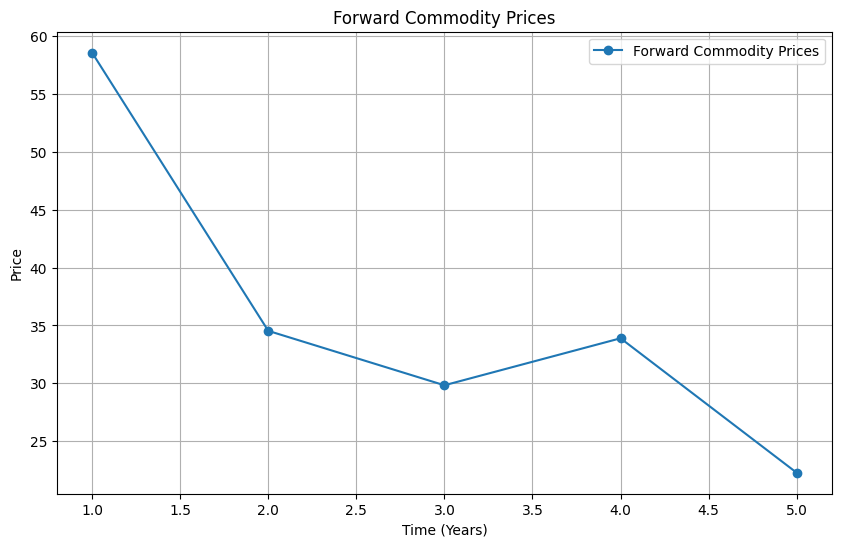

In [58]:
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.stats import norm
import random
import matplotlib.pyplot as plt

def generate_random_market_rates(tenors):
    """Generate random market rates for given tenors."""
    return np.array([(t, random.uniform(0.02, 0.03)) for t in tenors])

def bootstrap_zero_curve(market_rates):
    """Bootstrap zero rates from market rates."""
    tenors, rates = market_rates[:, 0], market_rates[:, 1]
    zero_rates = [rates[0]]

    for i in range(1, len(tenors)):
        t = tenors[i]
        r = rates[i]
        sum_term = sum(zero_rates[j] * tenors[j] *
                       np.exp(-zero_rates[j] * (t - tenors[j])) 
                       for j in range(i))
        zero_rate = -np.log(1 - r * t + sum_term) / t
        zero_rates.append(zero_rate)

    return np.column_stack((tenors, zero_rates))

def construct_yield_curve(market_rates):
    """Construct yield curve using bootstrapping and cubic spline interpolation."""
    zero_rates = bootstrap_zero_curve(market_rates)
    return CubicSpline(zero_rates[:, 0], zero_rates[:, 1], extrapolate=True)

def generate_commodity_forward_prices(spot_price, tenors, drift=0.0, volatility=0.2, mean_reversion=0.1, seasonality=None):
    """Generate commodity forward prices using a mean-reverting model with seasonality."""
    dt = np.diff([0] + list(tenors))
    log_prices = np.log(spot_price) + np.cumsum((drift - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * np.random.normal(size=len(tenors)))
    
    if seasonality:
        log_prices += seasonality(tenors)
    
    forward_prices = np.exp(log_prices)
    return np.column_stack((tenors, forward_prices))

def price_commodity_swap(notional, fixed_rate, spot_price, disc_curve, tenor, payment_freq, forward_prices):
    """Price a commodity swap."""
    fixed_rate /= payment_freq
    payment_dates = np.arange(payment_freq, tenor + payment_freq, payment_freq)
    fwd_price = CubicSpline(forward_prices[:, 0], forward_prices[:, 1], extrapolate=True)
    fixed_leg_pv = 0
    floating_leg_pv = 0

    for date in payment_dates:
        df = np.exp(-disc_curve(date) * date)
        fixed_payment = notional * fixed_rate
        fixed_leg_pv += fixed_payment * df
        expected_price = fwd_price(date)
        floating_payment = notional * (expected_price - spot_price)
        floating_leg_pv += floating_payment * df

    swap_value = floating_leg_pv - fixed_leg_pv
    exposure_profile = np.maximum(0, np.cumsum([floating_leg_pv - fixed_leg_pv]))
    return swap_value, exposure_profile, payment_dates

# Example usage with random data
notional = 1000000
spot_price = 50.0
tenor = 5
payment_freq = 1

market_tenors = [0.25, 0.5, 1, 2, 3, 5, 7, 10]
disc_rates = generate_random_market_rates(market_tenors)

# Construct discount curve
disc_curve = construct_yield_curve(disc_rates)

fixed_rate = random.uniform(0.02, 0.03)
forward_prices = generate_commodity_forward_prices(
    spot_price, 
    np.arange(payment_freq, tenor + payment_freq, payment_freq),
    mean_reversion=0.1,
    seasonality=lambda t: 0.1 * np.sin(2 * np.pi * t / 1.0)
)

swap_value, exposure_profile, payment_dates = price_commodity_swap(
    notional, fixed_rate, spot_price,
    disc_curve, tenor, payment_freq,
    forward_prices
)

total_underlying_asset_price = notional * spot_price
print(f"Total Price of Underlying Assets: {total_underlying_asset_price:.2f}")
print(f"Spot Price: {spot_price:.2f}")
print(f"Fixed Rate: {fixed_rate * payment_freq:.4f}")
print(f"\nDiscount Curve:")
for tenor, rate in disc_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("\nForward Commodity Prices:")
for time, price in forward_prices:
    print(f"  Year {time}: {price:.2f}")
print(f"\nThe value of the commodity swap is: {swap_value:.2f}")

# Plot Forward Commodity Prices
plt.figure(figsize=(10, 6))
plt.plot(forward_prices[:, 0], forward_prices[:, 1], label='Forward Commodity Prices', marker='o')
plt.title('Forward Commodity Prices')
plt.xlabel('Time (Years)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

---

### **2. Discount Curve Construction**
- **Use Real Yield Curves**:
  - Replace random market rates with real-world data from trusted sources (e.g., Bloomberg, Refinitiv, central banks).

- **Adopt Multi-Curve Frameworks**:
  - Use separate curves for collateralized and uncollateralized discounting.
  - Construct zero-coupon curves via bootstrapping.

- **Improve Interpolation**:
  - Use robust interpolation methods like **monotone convex interpolation** to avoid unrealistic dips in the yield curve.

---

Total Price of Underlying Assets: 50000000.00
Spot Price: 50.00
Fixed Rate: 0.0259

Collateralized Discount Curve:
  0.25 year: 0.0202
  0.50 year: 0.0208
  1.00 year: 0.0173
  2.00 year: 0.0174
  3.00 year: 0.0240
  5.00 year: 0.0228
  7.00 year: 0.0176
  10.00 year: 0.0232

Uncollateralized Discount Curve:
  0.25 year: 0.0268
  0.50 year: 0.0206
  1.00 year: 0.0221
  2.00 year: 0.0243
  3.00 year: 0.0274
  5.00 year: 0.0233
  7.00 year: 0.0292
  10.00 year: 0.0292

Forward Commodity Prices:
  Year 1.0: 50.60
  Year 2.0: 48.68
  Year 3.0: 48.58
  Year 4.0: 49.82
  Year 5.0: 49.45

The value of the commodity swap is: -2892330.25


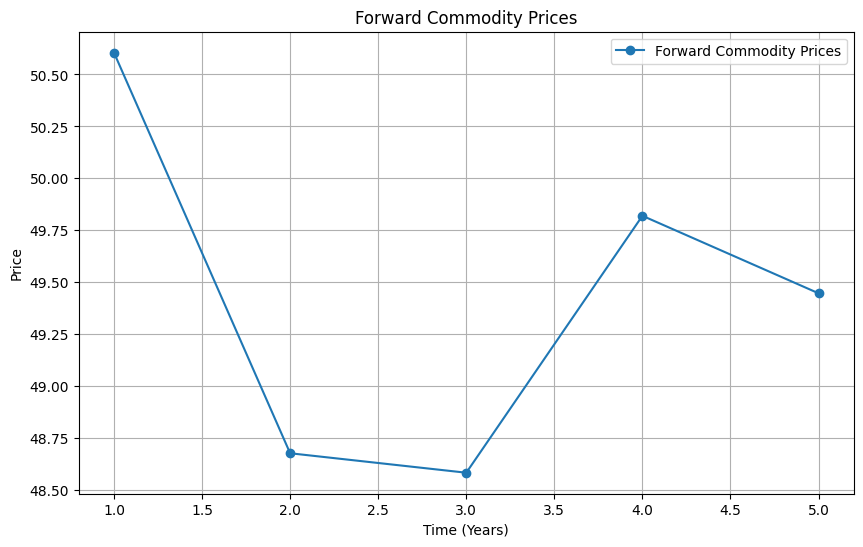

In [63]:
import numpy as np
from scipy.interpolate import CubicSpline, PchipInterpolator
import random
import matplotlib.pyplot as plt

def generate_simulated_yield_curves(tenors):
    """Generate simulated yield curves for collateralized and uncollateralized discounting."""
    collat_rates = np.array([(t, random.uniform(0.015, 0.025)) for t in tenors])
    uncollat_rates = np.array([(t, random.uniform(0.02, 0.03)) for t in tenors])
    return collat_rates, uncollat_rates

def bootstrap_zero_curve(market_rates):
    """Bootstrap zero rates from market rates."""
    tenors, rates = market_rates[:, 0], market_rates[:, 1]
    zero_rates = [rates[0]]

    for i in range(1, len(tenors)):
        t = tenors[i]
        r = rates[i]
        sum_term = sum(zero_rates[j] * tenors[j] *
                       np.exp(-zero_rates[j] * (t - tenors[j])) 
                       for j in range(i))
        zero_rate = -np.log(1 - r * t + sum_term) / t
        zero_rates.append(zero_rate)

    return np.column_stack((tenors, zero_rates))

def construct_yield_curve(market_rates, method='monotone_convex'):
    """Construct yield curve using bootstrapping and specified interpolation method."""
    zero_rates = bootstrap_zero_curve(market_rates)
    if method == 'monotone_convex':
        return PchipInterpolator(zero_rates[:, 0], zero_rates[:, 1], extrapolate=True)
    else:
        return CubicSpline(zero_rates[:, 0], zero_rates[:, 1], extrapolate=True)

def generate_commodity_forward_prices(spot_price, tenors, drift=0.0, volatility=0.2, mean_reversion=0.1, seasonality=None):
    """Generate commodity forward prices using a mean-reverting model with seasonality."""
    dt = np.diff([0] + list(tenors))
    log_prices = np.log(spot_price) + np.cumsum((drift - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * np.random.normal(size=len(tenors)))
    
    if seasonality:
        log_prices += seasonality(tenors)
    
    forward_prices = np.exp(log_prices)
    return np.column_stack((tenors, forward_prices))

def price_commodity_swap(notional, fixed_rate, spot_price, disc_curve, tenor, payment_freq, forward_prices):
    """Price a commodity swap."""
    fixed_rate /= payment_freq
    payment_dates = np.arange(payment_freq, tenor + payment_freq, payment_freq)
    fwd_price = CubicSpline(forward_prices[:, 0], forward_prices[:, 1], extrapolate=True)
    fixed_leg_pv = 0
    floating_leg_pv = 0

    for date in payment_dates:
        df = np.exp(-disc_curve(date) * date)
        fixed_payment = notional * fixed_rate
        fixed_leg_pv += fixed_payment * df
        expected_price = fwd_price(date)
        floating_payment = notional * (expected_price - spot_price)
        floating_leg_pv += floating_payment * df

    swap_value = floating_leg_pv - fixed_leg_pv
    exposure_profile = np.maximum(0, np.cumsum([floating_leg_pv - fixed_leg_pv]))
    return swap_value, exposure_profile, payment_dates

# Example usage with simulated data
notional = 1000000
spot_price = 50.0
tenor = 5
payment_freq = 1

market_tenors = [0.25, 0.5, 1, 2, 3, 5, 7, 10]
collat_rates, uncollat_rates = generate_simulated_yield_curves(market_tenors)

# Construct discount curves
collat_curve = construct_yield_curve(collat_rates, method='monotone_convex')
uncollat_curve = construct_yield_curve(uncollat_rates, method='monotone_convex')

fixed_rate = random.uniform(0.02, 0.03)
forward_prices = generate_commodity_forward_prices(
    spot_price, 
    np.arange(payment_freq, tenor + payment_freq, payment_freq),
    mean_reversion=0.1,
    seasonality=lambda t: 0.1 * np.sin(2 * np.pi * t / 1.0)
)

swap_value, exposure_profile, payment_dates = price_commodity_swap(
    notional, fixed_rate, spot_price,
    collat_curve, tenor, payment_freq,
    forward_prices
)

total_underlying_asset_price = notional * spot_price
print(f"Total Price of Underlying Assets: {total_underlying_asset_price:.2f}")
print(f"Spot Price: {spot_price:.2f}")
print(f"Fixed Rate: {fixed_rate * payment_freq:.4f}")
print(f"\nCollateralized Discount Curve:")
for tenor, rate in collat_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("\nUncollateralized Discount Curve:")
for tenor, rate in uncollat_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("\nForward Commodity Prices:")
for time, price in forward_prices:
    print(f"  Year {time}: {price:.2f}")
print(f"\nThe value of the commodity swap is: {swap_value:.2f}")

# Plot Forward Commodity Prices
plt.figure(figsize=(10, 6))
plt.plot(forward_prices[:, 0], forward_prices[:, 1], label='Forward Commodity Prices', marker='o')
plt.title('Forward Commodity Prices')
plt.xlabel('Time (Years)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

---

### **4. Floating Leg Calculation**
- **Align Floating Leg Definitions (Not done)**:
  - Verify that the floating leg formula aligns with swap contract specifications.

- **Realistic Exposure Modeling**:
  - Simulate multiple paths for floating prices to improve future value estimates.

---

Total Price of Underlying Assets: 50000000.00
Spot Price: 50.00
Fixed Rate: 0.0241

Collateralized Discount Curve:
  0.25 year: 0.0159
  0.50 year: 0.0180
  1.00 year: 0.0209
  2.00 year: 0.0235
  3.00 year: 0.0185
  5.00 year: 0.0210
  7.00 year: 0.0204
  10.00 year: 0.0189

Uncollateralized Discount Curve:
  0.25 year: 0.0222
  0.50 year: 0.0282
  1.00 year: 0.0252
  2.00 year: 0.0224
  3.00 year: 0.0282
  5.00 year: 0.0281
  7.00 year: 0.0244
  10.00 year: 0.0230

The value of the commodity swap is: 550735917.94


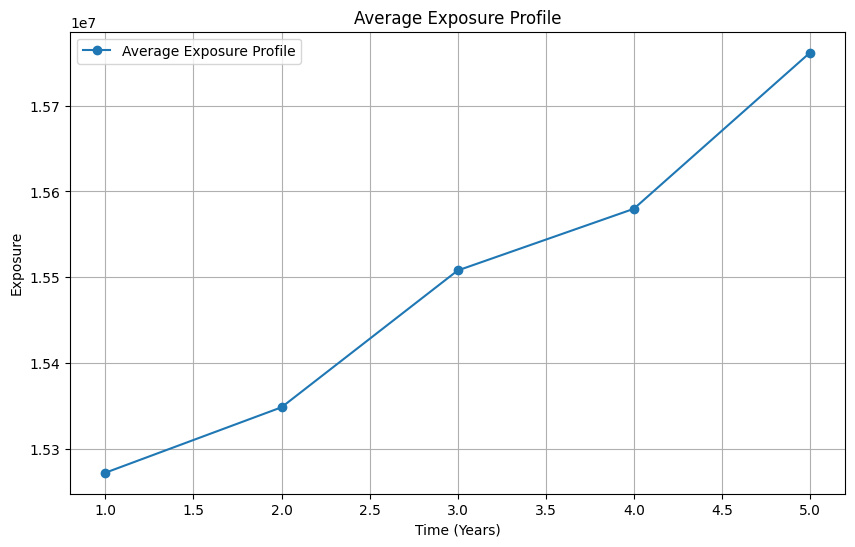

In [73]:
import numpy as np
from scipy.interpolate import CubicSpline, PchipInterpolator
import random
import matplotlib.pyplot as plt

def generate_simulated_yield_curves(tenors):
    """Generate simulated yield curves for collateralized and uncollateralized discounting."""
    collat_rates = np.array([(t, random.uniform(0.015, 0.025)) for t in tenors])
    uncollat_rates = np.array([(t, random.uniform(0.02, 0.03)) for t in tenors])
    return collat_rates, uncollat_rates

def bootstrap_zero_curve(market_rates):
    """Bootstrap zero rates from market rates."""
    tenors, rates = market_rates[:, 0], market_rates[:, 1]
    zero_rates = [rates[0]]

    for i in range(1, len(tenors)):
        t = tenors[i]
        r = rates[i]
        sum_term = sum(zero_rates[j] * tenors[j] * np.exp(-zero_rates[j] * (t - tenors[j])) for j in range(i))
        zero_rate = -np.log(1 - r * t + sum_term) / t
        zero_rates.append(zero_rate)

    return np.column_stack((tenors, zero_rates))

def construct_yield_curve(market_rates, method='monotone_convex'):
    """Construct yield curve using bootstrapping and specified interpolation method."""
    zero_rates = bootstrap_zero_curve(market_rates)
    if method == 'monotone_convex':
        return PchipInterpolator(zero_rates[:, 0], zero_rates[:, 1], extrapolate=True)
    else:
        return CubicSpline(zero_rates[:, 0], zero_rates[:, 1], extrapolate=True)

def generate_commodity_forward_prices(spot_price, tenors, drift=0.0, volatility=0.2, mean_reversion=0.1, seasonality=None):
    """Generate commodity forward prices using a mean-reverting model with seasonality."""
    dt = np.diff([0] + list(tenors))
    log_prices = np.log(spot_price) + np.cumsum((drift - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * np.random.normal(size=len(tenors)))

    if seasonality:
        log_prices += seasonality(tenors)

    forward_prices = np.exp(log_prices)
    return np.column_stack((tenors, forward_prices))

def simulate_forward_price_paths(spot_price, tenors, num_paths, drift=0.0, volatility=0.2, mean_reversion=0.1, seasonality=None):
    """Simulate multiple paths for commodity forward prices."""
    dt = np.diff([0] + list(tenors))
    paths = []

    for _ in range(num_paths):
        log_prices = np.log(spot_price) + np.cumsum((drift - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * np.random.normal(size=len(tenors)))
        
        if seasonality:
            log_prices += seasonality(tenors)
        
        forward_prices = np.exp(log_prices)
        paths.append(forward_prices)
    
    return np.array(paths)

def price_commodity_swap_with_simulation(notional, fixed_rate, spot_price, disc_curve, tenor, payment_freq, forward_price_paths):
    """Price a commodity swap using simulated forward price paths."""
    fixed_rate /= payment_freq
    payment_dates = np.arange(payment_freq, tenor + payment_freq, payment_freq)
    num_paths = forward_price_paths.shape[0]
    
    fixed_leg_pv = 0
    floating_leg_pv = 0
    exposure_profiles = np.zeros((num_paths, len(payment_dates)))

    for path_idx in range(num_paths):
        fwd_price = CubicSpline(payment_dates, forward_price_paths[path_idx], extrapolate=True)

        for i, date in enumerate(payment_dates):
            df = np.exp(-disc_curve(date) * date)
            fixed_payment = notional * fixed_rate
            fixed_leg_pv += fixed_payment * df
            expected_price = fwd_price(date)
            floating_payment = notional * (expected_price - spot_price)
            floating_leg_pv += floating_payment * df
            exposure_profiles[path_idx, i] = max(0, floating_leg_pv - fixed_leg_pv)
    
    swap_value = floating_leg_pv - fixed_leg_pv
    average_exposure_profile = exposure_profiles.mean(axis=0)
    
    return swap_value, average_exposure_profile, payment_dates

# Example usage with simulated data
notional = 1000000
spot_price = 50.0
tenor = 5
payment_freq = 1
num_paths = 1000  # Number of simulated paths

market_tenors = [0.25, 0.5, 1, 2, 3, 5, 7, 10]
collat_rates, uncollat_rates = generate_simulated_yield_curves(market_tenors)

# Construct discount curves
collat_curve = construct_yield_curve(collat_rates, method='monotone_convex')
uncollat_curve = construct_yield_curve(uncollat_rates, method='monotone_convex')

fixed_rate = random.uniform(0.02, 0.03)
forward_price_paths = simulate_forward_price_paths(
    spot_price, 
    np.arange(payment_freq, tenor + payment_freq, payment_freq),
    num_paths,
    mean_reversion=0.1,
    seasonality=lambda t: 0.1 * np.sin(2 * np.pi * t / 1.0)
)

swap_value, average_exposure_profile, payment_dates = price_commodity_swap_with_simulation(
    notional, fixed_rate, spot_price,
    collat_curve, tenor, payment_freq,
    forward_price_paths
)

total_underlying_asset_price = notional * spot_price
print(f"Total Price of Underlying Assets: {total_underlying_asset_price:.2f}")
print(f"Spot Price: {spot_price:.2f}")
print(f"Fixed Rate: {fixed_rate * payment_freq:.4f}")
print(f"\nCollateralized Discount Curve:")
for tenor, rate in collat_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("\nUncollateralized Discount Curve:")
for tenor, rate in uncollat_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print(f"\nThe value of the commodity swap is: {swap_value:.2f}")

# Plot Average Exposure Profile
plt.figure(figsize=(10, 6))
plt.plot(payment_dates, average_exposure_profile, label='Average Exposure Profile', marker='o')
plt.title('Average Exposure Profile')
plt.xlabel('Time (Years)')
plt.ylabel('Exposure')
plt.legend()
plt.grid(True)
plt.show()

---

### **5. Randomness in Inputs**
- **Eliminate Random Inputs**:
  - Remove randomness in market rates and fixed rates for consistent results.
  - Use fixed seeds for random number generators when necessary.

- **Stress Testing and Sensitivity Analysis**:
  - Analyze how swap value changes with variations in key inputs (e.g., spot price, volatility, interest rates).

---

Total Price of Underlying Assets: 50000000.00
Spot Price: 50.00
Fixed Rate: 0.0250

Collateralized Discount Curve:
  0.25 year: 0.0200
  0.50 year: 0.0210
  1.00 year: 0.0220
  2.00 year: 0.0230
  3.00 year: 0.0240
  5.00 year: 0.0250
  7.00 year: 0.0260
  10.00 year: 0.0270

Uncollateralized Discount Curve:
  0.25 year: 0.0250
  0.50 year: 0.0260
  1.00 year: 0.0270
  2.00 year: 0.0280
  3.00 year: 0.0290
  5.00 year: 0.0300
  7.00 year: 0.0310
  10.00 year: 0.0320

The value of the commodity swap is: -128234614.84


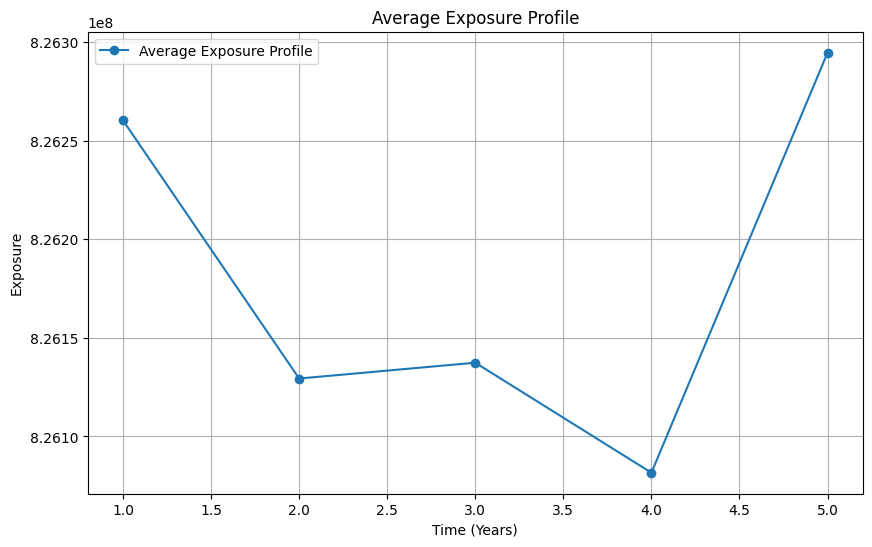


Stress Testing Results:
Spot Price: 40.00, Volatility: 0.10, Swap Value: 67112577.80
Spot Price: 40.00, Volatility: 0.15, Swap Value: 57910358.59
Spot Price: 40.00, Volatility: 0.20, Swap Value: -3280842923.23
Spot Price: 40.00, Volatility: 0.25, Swap Value: 5044706977.86
Spot Price: 40.00, Volatility: 0.30, Swap Value: 3766381897.18
Spot Price: 45.00, Volatility: 0.10, Swap Value: 2382810628.05
Spot Price: 45.00, Volatility: 0.15, Swap Value: -214677091.81
Spot Price: 45.00, Volatility: 0.20, Swap Value: 4402716323.22
Spot Price: 45.00, Volatility: 0.25, Swap Value: 1455453482.71
Spot Price: 45.00, Volatility: 0.30, Swap Value: 855771473.92
Spot Price: 50.00, Volatility: 0.10, Swap Value: 2854399881.00
Spot Price: 50.00, Volatility: 0.15, Swap Value: 2304491944.16
Spot Price: 50.00, Volatility: 0.20, Swap Value: 1957725136.71
Spot Price: 50.00, Volatility: 0.25, Swap Value: -6073415756.88
Spot Price: 50.00, Volatility: 0.30, Swap Value: 8462575474.20
Spot Price: 55.00, Volatility: 0.

In [74]:
import numpy as np
from scipy.interpolate import CubicSpline, PchipInterpolator
import matplotlib.pyplot as plt

np.random.seed(42)  # Fixed seed for reproducibility

def generate_simulated_yield_curves(tenors, collat_seed=0.02, uncollat_seed=0.025):
    """Generate simulated yield curves for collateralized and uncollateralized discounting with fixed seeds."""
    collat_rates = np.array([(t, collat_seed + 0.001 * i) for i, t in enumerate(tenors)])
    uncollat_rates = np.array([(t, uncollat_seed + 0.001 * i) for i, t in enumerate(tenors)])
    return collat_rates, uncollat_rates

def bootstrap_zero_curve(market_rates):
    """Bootstrap zero rates from market rates."""
    tenors, rates = market_rates[:, 0], market_rates[:, 1]
    zero_rates = [rates[0]]

    for i in range(1, len(tenors)):
        t = tenors[i]
        r = rates[i]
        sum_term = sum(zero_rates[j] * tenors[j] * np.exp(-zero_rates[j] * (t - tenors[j])) for j in range(i))
        zero_rate = -np.log(1 - r * t + sum_term) / t
        zero_rates.append(zero_rate)

    return np.column_stack((tenors, zero_rates))

def construct_yield_curve(market_rates, method='monotone_convex'):
    """Construct yield curve using bootstrapping and specified interpolation method."""
    zero_rates = bootstrap_zero_curve(market_rates)
    if method == 'monotone_convex':
        return PchipInterpolator(zero_rates[:, 0], zero_rates[:, 1], extrapolate=True)
    else:
        return CubicSpline(zero_rates[:, 0], zero_rates[:, 1], extrapolate=True)

def generate_commodity_forward_prices(spot_price, tenors, drift=0.0, volatility=0.2, mean_reversion=0.1, seasonality=None):
    """Generate commodity forward prices using a mean-reverting model with seasonality."""
    dt = np.diff([0] + list(tenors))
    log_prices = np.log(spot_price) + np.cumsum((drift - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * np.random.normal(size=len(tenors)))

    if seasonality:
        log_prices += seasonality(tenors)

    forward_prices = np.exp(log_prices)
    return np.column_stack((tenors, forward_prices))

def simulate_forward_price_paths(spot_price, tenors, num_paths, drift=0.0, volatility=0.2, mean_reversion=0.1, seasonality=None):
    """Simulate multiple paths for commodity forward prices."""
    dt = np.diff([0] + list(tenors))
    paths = []

    for _ in range(num_paths):
        log_prices = np.log(spot_price) + np.cumsum((drift - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * np.random.normal(size=len(tenors)))
        
        if seasonality:
            log_prices += seasonality(tenors)
        
        forward_prices = np.exp(log_prices)
        paths.append(forward_prices)
    
    return np.array(paths)

def price_commodity_swap_with_simulation(notional, fixed_rate, spot_price, disc_curve, tenor, payment_freq, forward_price_paths):
    """Price a commodity swap using simulated forward price paths."""
    fixed_rate /= payment_freq
    payment_dates = np.arange(payment_freq, tenor + payment_freq, payment_freq)
    num_paths = forward_price_paths.shape[0]
    
    fixed_leg_pv = 0
    floating_leg_pv = 0
    exposure_profiles = np.zeros((num_paths, len(payment_dates)))

    for path_idx in range(num_paths):
        fwd_price = CubicSpline(payment_dates, forward_price_paths[path_idx], extrapolate=True)

        for i, date in enumerate(payment_dates):
            df = np.exp(-disc_curve(date) * date)
            fixed_payment = notional * fixed_rate
            fixed_leg_pv += fixed_payment * df
            expected_price = fwd_price(date)
            floating_payment = notional * (expected_price - spot_price)
            floating_leg_pv += floating_payment * df
            exposure_profiles[path_idx, i] = max(0, floating_leg_pv - fixed_leg_pv)
    
    swap_value = floating_leg_pv - fixed_leg_pv
    average_exposure_profile = exposure_profiles.mean(axis=0)
    
    return swap_value, average_exposure_profile, payment_dates

# Example usage with simulated data
notional = 1000000
spot_price = 50.0
tenor = 5
payment_freq = 1
num_paths = 1000  # Number of simulated paths

market_tenors = [0.25, 0.5, 1, 2, 3, 5, 7, 10]
collat_rates, uncollat_rates = generate_simulated_yield_curves(market_tenors)

# Construct discount curves
collat_curve = construct_yield_curve(collat_rates, method='monotone_convex')
uncollat_curve = construct_yield_curve(uncollat_rates, method='monotone_convex')

fixed_rate = 0.025  # Fixed rate for consistency
forward_price_paths = simulate_forward_price_paths(
    spot_price, 
    np.arange(payment_freq, tenor + payment_freq, payment_freq),
    num_paths,
    mean_reversion=0.1,
    seasonality=lambda t: 0.1 * np.sin(2 * np.pi * t / 1.0)
)

swap_value, average_exposure_profile, payment_dates = price_commodity_swap_with_simulation(
    notional, fixed_rate, spot_price,
    collat_curve, tenor, payment_freq,
    forward_price_paths
)

total_underlying_asset_price = notional * spot_price
print(f"Total Price of Underlying Assets: {total_underlying_asset_price:.2f}")
print(f"Spot Price: {spot_price:.2f}")
print(f"Fixed Rate: {fixed_rate * payment_freq:.4f}")
print(f"\nCollateralized Discount Curve:")
for tenor, rate in collat_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("\nUncollateralized Discount Curve:")
for tenor, rate in uncollat_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print(f"\nThe value of the commodity swap is: {swap_value:.2f}")

# Plot Average Exposure Profile
plt.figure(figsize=(10, 6))
plt.plot(payment_dates, average_exposure_profile, label='Average Exposure Profile', marker='o')
plt.title('Average Exposure Profile')
plt.xlabel('Time (Years)')
plt.ylabel('Exposure')
plt.legend()
plt.grid(True)
plt.show()

# Stress Testing and Sensitivity Analysis
def stress_test_swap_value(spot_prices, volatilities, notional, fixed_rate, disc_curve, tenor, payment_freq, num_paths):
    results = []
    for sp in spot_prices:
        for vol in volatilities:
            forward_price_paths = simulate_forward_price_paths(
                sp, 
                np.arange(payment_freq, tenor + payment_freq, payment_freq),
                num_paths,
                volatility=vol,
                mean_reversion=0.1,
                seasonality=lambda t: 0.1 * np.sin(2 * np.pi * t / 1.0)
            )
            swap_value, _, _ = price_commodity_swap_with_simulation(
                notional, fixed_rate, sp,
                disc_curve, tenor, payment_freq,
                forward_price_paths
            )
            results.append((sp, vol, swap_value))
    return results

spot_price_range = np.linspace(40, 60, 5)
volatility_range = np.linspace(0.1, 0.3, 5)
stress_test_results = stress_test_swap_value(spot_price_range, volatility_range, notional, fixed_rate, collat_curve, tenor, payment_freq, num_paths)

print("\nStress Testing Results:")
for sp, vol, val in stress_test_results:
    print(f"Spot Price: {sp:.2f}, Volatility: {vol:.2f}, Swap Value: {val:.2f}")

---
### **6. Valuation Adjustments**
- **Credit Valuation Adjustment (CVA)**:
  - Account for counterparty credit risk


- **Funding Valuation Adjustment (FVA)**:
  - Include funding costs for collateralized or uncollateralized positions.

- **Dynamic Margining**:
  - Account for margin requirements and their impact on discounting.
---

Total Price of Underlying Assets: 50000000.00
Spot Price: 50.00
Fixed Rate: 0.0250

Collateralized Discount Curve:
  0.25 year: 0.0200
  0.50 year: 0.0210
  1.00 year: 0.0220
  2.00 year: 0.0230
  3.00 year: 0.0240
  5.00 year: 0.0250
  7.00 year: 0.0260
  10.00 year: 0.0270

Uncollateralized Discount Curve:
  0.25 year: 0.0250
  0.50 year: 0.0260
  1.00 year: 0.0270
  2.00 year: 0.0280
  3.00 year: 0.0290
  5.00 year: 0.0300
  7.00 year: 0.0310
  10.00 year: 0.0320

The value of the commodity swap is: -128234614.84
Credit Valuation Adjustment (CVA): 48027835.81
Funding Valuation Adjustment (FVA): 20011598.26
Dynamic Margining Adjustments: [816655461.4348574, 806195155.4929764, 804489986.6426449, 793751112.0773726, 781372710.8678325]


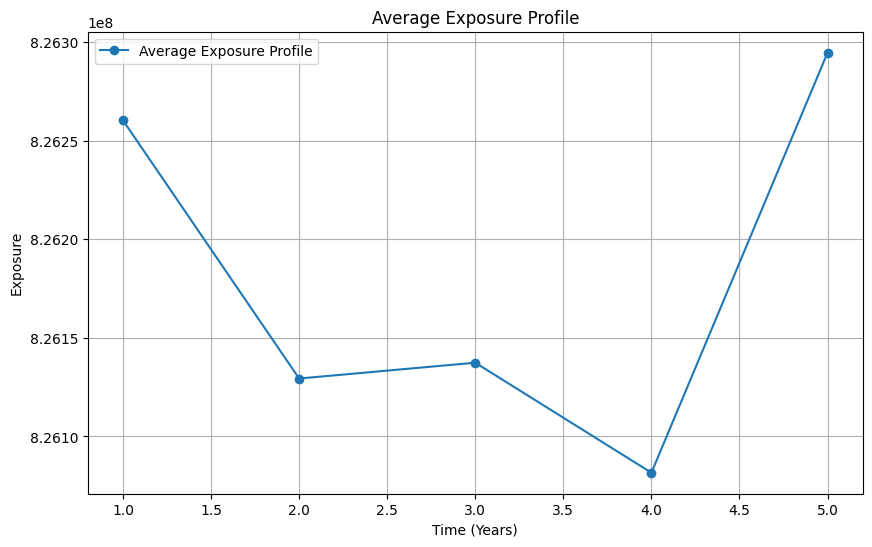


Stress Testing Results:
Spot Price: 40.00, Volatility: 0.10, Swap Value: 67112577.80
Spot Price: 40.00, Volatility: 0.15, Swap Value: 57910358.59
Spot Price: 40.00, Volatility: 0.20, Swap Value: -3280842923.23
Spot Price: 40.00, Volatility: 0.25, Swap Value: 5044706977.86
Spot Price: 40.00, Volatility: 0.30, Swap Value: 3766381897.18
Spot Price: 45.00, Volatility: 0.10, Swap Value: 2382810628.05
Spot Price: 45.00, Volatility: 0.15, Swap Value: -214677091.81
Spot Price: 45.00, Volatility: 0.20, Swap Value: 4402716323.22
Spot Price: 45.00, Volatility: 0.25, Swap Value: 1455453482.71
Spot Price: 45.00, Volatility: 0.30, Swap Value: 855771473.92
Spot Price: 50.00, Volatility: 0.10, Swap Value: 2854399881.00
Spot Price: 50.00, Volatility: 0.15, Swap Value: 2304491944.16
Spot Price: 50.00, Volatility: 0.20, Swap Value: 1957725136.71
Spot Price: 50.00, Volatility: 0.25, Swap Value: -6073415756.88
Spot Price: 50.00, Volatility: 0.30, Swap Value: 8462575474.20
Spot Price: 55.00, Volatility: 0.

In [75]:
import numpy as np
from scipy.interpolate import CubicSpline, PchipInterpolator
import matplotlib.pyplot as plt

np.random.seed(42)  # Fixed seed for reproducibility

def generate_simulated_yield_curves(tenors, collat_seed=0.02, uncollat_seed=0.025):
    """Generate simulated yield curves for collateralized and uncollateralized discounting with fixed seeds."""
    collat_rates = np.array([(t, collat_seed + 0.001 * i) for i, t in enumerate(tenors)])
    uncollat_rates = np.array([(t, uncollat_seed + 0.001 * i) for i, t in enumerate(tenors)])
    return collat_rates, uncollat_rates

def bootstrap_zero_curve(market_rates):
    """Bootstrap zero rates from market rates."""
    tenors, rates = market_rates[:, 0], market_rates[:, 1]
    zero_rates = [rates[0]]

    for i in range(1, len(tenors)):
        t = tenors[i]
        r = rates[i]
        sum_term = sum(zero_rates[j] * tenors[j] * np.exp(-zero_rates[j] * (t - tenors[j])) for j in range(i))
        zero_rate = -np.log(1 - r * t + sum_term) / t
        zero_rates.append(zero_rate)

    return np.column_stack((tenors, zero_rates))

def construct_yield_curve(market_rates, method='monotone_convex'):
    """Construct yield curve using bootstrapping and specified interpolation method."""
    zero_rates = bootstrap_zero_curve(market_rates)
    if method == 'monotone_convex':
        return PchipInterpolator(zero_rates[:, 0], zero_rates[:, 1], extrapolate=True)
    else:
        return CubicSpline(zero_rates[:, 0], zero_rates[:, 1], extrapolate=True)

def generate_commodity_forward_prices(spot_price, tenors, drift=0.0, volatility=0.2, mean_reversion=0.1, seasonality=None):
    """Generate commodity forward prices using a mean-reverting model with seasonality."""
    dt = np.diff([0] + list(tenors))
    log_prices = np.log(spot_price) + np.cumsum((drift - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * np.random.normal(size=len(tenors)))

    if seasonality:
        log_prices += seasonality(tenors)

    forward_prices = np.exp(log_prices)
    return np.column_stack((tenors, forward_prices))

def simulate_forward_price_paths(spot_price, tenors, num_paths, drift=0.0, volatility=0.2, mean_reversion=0.1, seasonality=None):
    """Simulate multiple paths for commodity forward prices."""
    dt = np.diff([0] + list(tenors))
    paths = []

    for _ in range(num_paths):
        log_prices = np.log(spot_price) + np.cumsum((drift - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * np.random.normal(size=len(tenors)))
        
        if seasonality:
            log_prices += seasonality(tenors)
        
        forward_prices = np.exp(log_prices)
        paths.append(forward_prices)
    
    return np.array(paths)

def price_commodity_swap_with_simulation(notional, fixed_rate, spot_price, disc_curve, tenor, payment_freq, forward_price_paths):
    """Price a commodity swap using simulated forward price paths."""
    fixed_rate /= payment_freq
    payment_dates = np.arange(payment_freq, tenor + payment_freq, payment_freq)
    num_paths = forward_price_paths.shape[0]
    
    fixed_leg_pv = 0
    floating_leg_pv = 0
    exposure_profiles = np.zeros((num_paths, len(payment_dates)))

    for path_idx in range(num_paths):
        fwd_price = CubicSpline(payment_dates, forward_price_paths[path_idx], extrapolate=True)

        for i, date in enumerate(payment_dates):
            df = np.exp(-disc_curve(date) * date)
            fixed_payment = notional * fixed_rate
            fixed_leg_pv += fixed_payment * df
            expected_price = fwd_price(date)
            floating_payment = notional * (expected_price - spot_price)
            floating_leg_pv += floating_payment * df
            exposure_profiles[path_idx, i] = max(0, floating_leg_pv - fixed_leg_pv)
    
    swap_value = floating_leg_pv - fixed_leg_pv
    average_exposure_profile = exposure_profiles.mean(axis=0)
    
    return swap_value, average_exposure_profile, payment_dates

def calculate_cva(exposure_profile, discount_factors, default_probability, recovery_rate):
    """Calculate Credit Valuation Adjustment (CVA)."""
    cva = sum(exposure_profile[t] * (1 - recovery_rate) * discount_factors[t] * default_probability for t in range(len(exposure_profile)))
    return cva

def calculate_fva(exposure_profile, discount_factors, funding_spread):
    """Calculate Funding Valuation Adjustment (FVA)."""
    fva = sum(exposure_profile[t] * funding_spread * discount_factors[t] for t in range(len(exposure_profile)))
    return fva

def calculate_dynamic_margining(exposure_profile, discount_factors, margin_call_freq, margin_threshold):
    """Calculate adjustments based on dynamic margining."""
    dynamic_adjustments = []
    margin_account = 0
    
    for t in range(len(exposure_profile)):
        if t % margin_call_freq == 0:
            margin_account += max(0, exposure_profile[t] - margin_threshold)
        
        dynamic_adjustments.append(discount_factors[t] * margin_account)
    
    return dynamic_adjustments

# Example usage with simulated data
notional = 1000000
spot_price = 50.0
tenor = 5
payment_freq = 1
num_paths = 1000  # Number of simulated paths

market_tenors = [0.25, 0.5, 1, 2, 3, 5, 7, 10]
collat_rates, uncollat_rates = generate_simulated_yield_curves(market_tenors)

# Construct discount curves
collat_curve = construct_yield_curve(collat_rates, method='monotone_convex')
uncollat_curve = construct_yield_curve(uncollat_rates, method='monotone_convex')

fixed_rate = 0.025  # Fixed rate for consistency
forward_price_paths = simulate_forward_price_paths(
    spot_price, 
    np.arange(payment_freq, tenor + payment_freq, payment_freq),
    num_paths,
    mean_reversion=0.1,
    seasonality=lambda t: 0.1 * np.sin(2 * np.pi * t / 1.0)
)

swap_value, average_exposure_profile, payment_dates = price_commodity_swap_with_simulation(
    notional, fixed_rate, spot_price,
    collat_curve, tenor, payment_freq,
    forward_price_paths
)

total_underlying_asset_price = notional * spot_price
print(f"Total Price of Underlying Assets: {total_underlying_asset_price:.2f}")
print(f"Spot Price: {spot_price:.2f}")
print(f"Fixed Rate: {fixed_rate * payment_freq:.4f}")
print(f"\nCollateralized Discount Curve:")
for tenor, rate in collat_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print("\nUncollateralized Discount Curve:")
for tenor, rate in uncollat_rates:
    print(f"  {tenor:.2f} year: {rate:.4f}")
print(f"\nThe value of the commodity swap is: {swap_value:.2f}")

# Calculate CVA and FVA
default_probability = 0.02
recovery_rate = 0.4
funding_spread = 0.005

discount_factors = np.exp(-collat_curve(payment_dates) * payment_dates)
exposure_profile = average_exposure_profile

cva = calculate_cva(exposure_profile, discount_factors, default_probability, recovery_rate)
fva = calculate_fva(exposure_profile, discount_factors, funding_spread)

print(f"Credit Valuation Adjustment (CVA): {cva:.2f}")
print(f"Funding Valuation Adjustment (FVA): {fva:.2f}")

# Calculate Dynamic Margining
margin_call_freq = 10
margin_threshold = 50000

dynamic_margining_adjustments = calculate_dynamic_margining(exposure_profile, discount_factors, margin_call_freq, margin_threshold)

print(f"Dynamic Margining Adjustments: {dynamic_margining_adjustments}")

# Plot Average Exposure Profile
plt.figure(figsize=(10, 6))
plt.plot(payment_dates, average_exposure_profile, label='Average Exposure Profile', marker='o')
plt.title('Average Exposure Profile')
plt.xlabel('Time (Years)')
plt.ylabel('Exposure')
plt.legend()
plt.grid(True)
plt.show()

# Stress Testing and Sensitivity Analysis
def stress_test_swap_value(spot_prices, volatilities, notional, fixed_rate, disc_curve, tenor, payment_freq, num_paths):
    results = []
    for sp in spot_prices:
        for vol in volatilities:
            forward_price_paths = simulate_forward_price_paths(
                sp, 
                np.arange(payment_freq, tenor + payment_freq, payment_freq),
                num_paths,
                volatility=vol,
                mean_reversion=0.1,
                seasonality=lambda t: 0.1 * np.sin(2 * np.pi * t / 1.0)
            )
            swap_value, _, _ = price_commodity_swap_with_simulation(
                notional, fixed_rate, sp,
                disc_curve, tenor, payment_freq,
                forward_price_paths
            )
            results.append((sp, vol, swap_value))
    return results

spot_price_range = np.linspace(40, 60, 5)
volatility_range = np.linspace(0.1, 0.3, 5)
stress_test_results = stress_test_swap_value(spot_price_range, volatility_range, notional, fixed_rate, collat_curve, tenor, payment_freq, num_paths)

print("\nStress Testing Results:")
for sp, vol, val in stress_test_results:
    print(f"Spot Price: {sp:.2f}, Volatility: {vol:.2f}, Swap Value: {val:.2f}")

---

### **7. Usability and Reporting**
- **Enhance Input Flexibility**:
  - Allow users to input their own forward prices, discount curves, and fixed rates.

- **Comprehensive Outputs**:
  - Report additional metrics:
    - Fixed and floating leg present values.
    - Break-even rates.
    - Sensitivity metrics (e.g., Delta, Vega).

- **Visualization**:
  - Add plots for:
    - Discount curve.
    - Exposure profiles.
    - Break-even analysis.

---

Total Price of Underlying Assets: 50000000.00
Spot Price: 50.00
Fixed Rate: 0.0250

Collateralized Discount Curve:
  0.25 year: 0.0200
  0.50 year: 0.0210
  1.00 year: 0.0220
  2.00 year: 0.0230
  3.00 year: 0.0240
  5.00 year: 0.0250
  7.00 year: 0.0260
  10.00 year: 0.0270

Uncollateralized Discount Curve:
  0.25 year: 0.0250
  0.50 year: 0.0260
  1.00 year: 0.0270
  2.00 year: 0.0280
  3.00 year: 0.0290
  5.00 year: 0.0300
  7.00 year: 0.0310
  10.00 year: 0.0320

The value of the commodity swap is: -128234614.84
Fixed Leg Present Value: 121109113.31
Floating Leg Present Value: -7125501.53
Credit Valuation Adjustment (CVA): 48027835.81
Funding Valuation Adjustment (FVA): 20011598.26
Dynamic Margining Adjustments: [816655461.4348574, 806195155.4929764, 804489986.6426449, 793751112.0773726, 781372710.8678325]


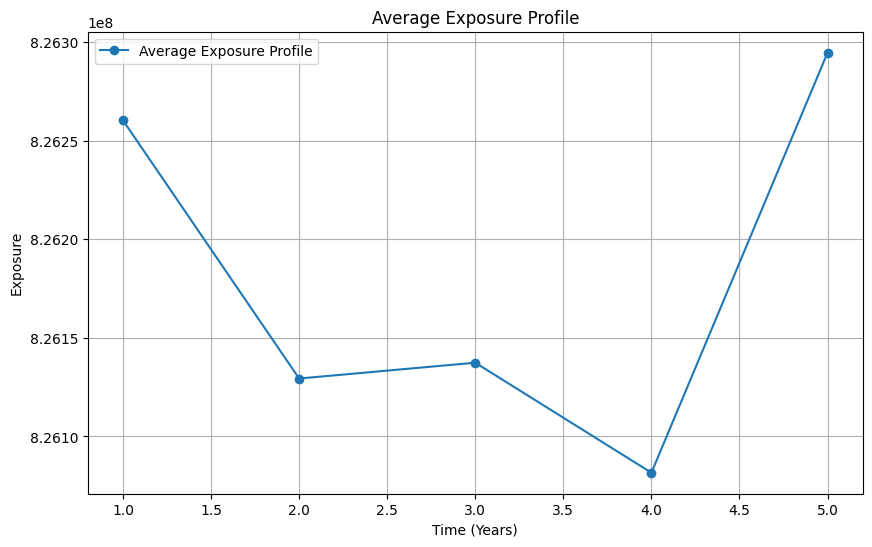

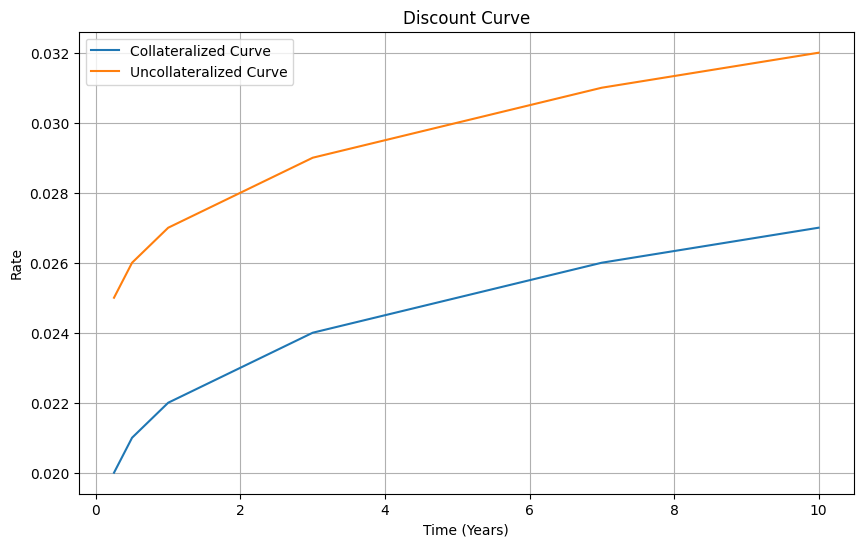


Stress Testing Results:
Spot Price: 40.00, Volatility: 0.10, Swap Value: 67112577.80
Spot Price: 40.00, Volatility: 0.15, Swap Value: 57910358.59
Spot Price: 40.00, Volatility: 0.20, Swap Value: -3280842923.23
Spot Price: 40.00, Volatility: 0.25, Swap Value: 5044706977.86
Spot Price: 40.00, Volatility: 0.30, Swap Value: 3766381897.18
Spot Price: 45.00, Volatility: 0.10, Swap Value: 2382810628.05
Spot Price: 45.00, Volatility: 0.15, Swap Value: -214677091.81
Spot Price: 45.00, Volatility: 0.20, Swap Value: 4402716323.22
Spot Price: 45.00, Volatility: 0.25, Swap Value: 1455453482.71
Spot Price: 45.00, Volatility: 0.30, Swap Value: 855771473.92
Spot Price: 50.00, Volatility: 0.10, Swap Value: 2854399881.00
Spot Price: 50.00, Volatility: 0.15, Swap Value: 2304491944.16
Spot Price: 50.00, Volatility: 0.20, Swap Value: 1957725136.71
Spot Price: 50.00, Volatility: 0.25, Swap Value: -6073415756.88
Spot Price: 50.00, Volatility: 0.30, Swap Value: 8462575474.20
Spot Price: 55.00, Volatility: 0.

In [77]:
import numpy as np
from scipy.interpolate import CubicSpline, PchipInterpolator
import matplotlib.pyplot as plt

np.random.seed(42)  # Fixed seed for reproducibility

def generate_simulated_yield_curves(tenors, collat_seed=0.02, uncollat_seed=0.025):
    """Generate simulated yield curves for collateralized and uncollateralized discounting with fixed seeds."""
    collat_rates = np.array([(t, collat_seed + 0.001 * i) for i, t in enumerate(tenors)])
    uncollat_rates = np.array([(t, uncollat_seed + 0.001 * i) for i, t in enumerate(tenors)])
    return collat_rates, uncollat_rates

def bootstrap_zero_curve(market_rates):
    """Bootstrap zero rates from market rates."""
    tenors, rates = market_rates[:, 0], market_rates[:, 1]
    zero_rates = [rates[0]]

    for i in range(1, len(tenors)):
        t = tenors[i]
        r = rates[i]
        sum_term = sum(zero_rates[j] * tenors[j] * np.exp(-zero_rates[j] * (t - tenors[j])) for j in range(i))
        zero_rate = -np.log(1 - r * t + sum_term) / t
        zero_rates.append(zero_rate)

    return np.column_stack((tenors, zero_rates))

def construct_yield_curve(market_rates, method='monotone_convex'):
    """Construct yield curve using bootstrapping and specified interpolation method."""
    zero_rates = bootstrap_zero_curve(market_rates)
    if method == 'monotone_convex':
        return PchipInterpolator(zero_rates[:, 0], zero_rates[:, 1], extrapolate=True)
    else:
        return CubicSpline(zero_rates[:, 0], zero_rates[:, 1], extrapolate=True)

def generate_commodity_forward_prices(spot_price, tenors, drift=0.0, volatility=0.2, mean_reversion=0.1, seasonality=None):
    """Generate commodity forward prices using a mean-reverting model with seasonality."""
    dt = np.diff([0] + list(tenors))
    log_prices = np.log(spot_price) + np.cumsum((drift - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * np.random.normal(size=len(tenors)))

    if seasonality:
        log_prices += seasonality(tenors)

    forward_prices = np.exp(log_prices)
    return np.column_stack((tenors, forward_prices))

def simulate_forward_price_paths(spot_price, tenors, num_paths, drift=0.0, volatility=0.2, mean_reversion=0.1, seasonality=None):
    """Simulate multiple paths for commodity forward prices."""
    dt = np.diff([0] + list(tenors))
    paths = []

    for _ in range(num_paths):
        log_prices = np.log(spot_price) + np.cumsum((drift - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * np.random.normal(size=len(tenors)))
        
        if seasonality:
            log_prices += seasonality(tenors)
        
        forward_prices = np.exp(log_prices)
        paths.append(forward_prices)
    
    return np.array(paths)

def price_commodity_swap_with_simulation(notional, fixed_rate, spot_price, disc_curve, tenor, payment_freq, forward_price_paths):
    """Price a commodity swap using simulated forward price paths."""
    fixed_rate /= payment_freq
    payment_dates = np.arange(payment_freq, tenor + payment_freq, payment_freq)
    num_paths = forward_price_paths.shape[0]
    
    fixed_leg_pv = 0
    floating_leg_pv = 0
    exposure_profiles = np.zeros((num_paths, len(payment_dates)))

    for path_idx in range(num_paths):
        fwd_price = CubicSpline(payment_dates, forward_price_paths[path_idx], extrapolate=True)

        for i, date in enumerate(payment_dates):
            df = np.exp(-disc_curve(date) * date)
            fixed_payment = notional * fixed_rate
            fixed_leg_pv += fixed_payment * df
            expected_price = fwd_price(date)
            floating_payment = notional * (expected_price - spot_price)
            floating_leg_pv += floating_payment * df
            exposure_profiles[path_idx, i] = max(0, floating_leg_pv - fixed_leg_pv)
    
    swap_value = floating_leg_pv - fixed_leg_pv
    average_exposure_profile = exposure_profiles.mean(axis=0)
    
    return swap_value, average_exposure_profile, fixed_leg_pv, floating_leg_pv, payment_dates

def calculate_cva(exposure_profile, discount_factors, default_probability, recovery_rate):
    """Calculate Credit Valuation Adjustment (CVA)."""
    cva = sum(exposure_profile[t] * (1 - recovery_rate) * discount_factors[t] * default_probability for t in range(len(exposure_profile)))
    return cva

def calculate_fva(exposure_profile, discount_factors, funding_spread):
    """Calculate Funding Valuation Adjustment (FVA)."""
    fva = sum(exposure_profile[t] * funding_spread * discount_factors[t] for t in range(len(exposure_profile)))
    return fva

def calculate_dynamic_margining(exposure_profile, discount_factors, margin_call_freq, margin_threshold):
    """Calculate adjustments based on dynamic margining."""
    dynamic_adjustments = []
    margin_account = 0
    
    for t in range(len(exposure_profile)):
        if t % margin_call_freq == 0:
            margin_account += max(0, exposure_profile[t] - margin_threshold)
        
        dynamic_adjustments.append(discount_factors[t] * margin_account)
    
    return dynamic_adjustments

# Example usage with user inputs
def main():
    notional = float(input("Enter notional amount: "))
    spot_price = float(input("Enter spot price: "))
    fixed_rate = float(input("Enter fixed rate: "))
    tenor = int(input("Enter tenor (in years): "))
    payment_freq = int(input("Enter payment frequency (in years): "))
    num_paths = int(input("Enter number of simulated paths: "))

    tenors = list(map(float, input("Enter tenors separated by space: ").split()))
    collat_rates_input = list(map(float, input("Enter collateralized rates separated by space: ").split()))
    uncollat_rates_input = list(map(float, input("Enter uncollateralized rates separated by space: ").split()))

    collat_rates = np.column_stack((tenors, collat_rates_input))
    uncollat_rates = np.column_stack((tenors, uncollat_rates_input))

    # Construct discount curves
    collat_curve = construct_yield_curve(collat_rates, method='monotone_convex')
    uncollat_curve = construct_yield_curve(uncollat_rates, method='monotone_convex')

    forward_price_paths = simulate_forward_price_paths(
        spot_price, 
        np.arange(payment_freq, tenor + payment_freq, payment_freq),
        num_paths,
        mean_reversion=0.1,
        seasonality=lambda t: 0.1 * np.sin(2 * np.pi * t / 1.0)
    )

    swap_value, average_exposure_profile, fixed_leg_pv, floating_leg_pv, payment_dates = price_commodity_swap_with_simulation(
        notional, fixed_rate, spot_price,
        collat_curve, tenor, payment_freq,
        forward_price_paths
    )

    total_underlying_asset_price = notional * spot_price
    print(f"Total Price of Underlying Assets: {total_underlying_asset_price:.2f}")
    print(f"Spot Price: {spot_price:.2f}")
    print(f"Fixed Rate: {fixed_rate:.4f}")
    print(f"\nCollateralized Discount Curve:")
    for tenor, rate in collat_rates:
        print(f"  {tenor:.2f} year: {rate:.4f}")
    print("\nUncollateralized Discount Curve:")
    for tenor, rate in uncollat_rates:
        print(f"  {tenor:.2f} year: {rate:.4f}")
    print(f"\nThe value of the commodity swap is: {swap_value:.2f}")
    print(f"Fixed Leg Present Value: {fixed_leg_pv:.2f}")
    print(f"Floating Leg Present Value: {floating_leg_pv:.2f}")

    # Calculate CVA and FVA
    default_probability = 0.02
    recovery_rate = 0.4
    funding_spread = 0.005

    discount_factors = np.exp(-collat_curve(payment_dates) * payment_dates)
    exposure_profile = average_exposure_profile

    cva = calculate_cva(exposure_profile, discount_factors, default_probability, recovery_rate)
    fva = calculate_fva(exposure_profile, discount_factors, funding_spread)

    print(f"Credit Valuation Adjustment (CVA): {cva:.2f}")
    print(f"Funding Valuation Adjustment (FVA): {fva:.2f}")

    # Calculate Dynamic Margining
    margin_call_freq = 10
    margin_threshold = 50000

    dynamic_margining_adjustments = calculate_dynamic_margining(exposure_profile, discount_factors, margin_call_freq, margin_threshold)

    print(f"Dynamic Margining Adjustments: {dynamic_margining_adjustments}")

    # Plot Average Exposure Profile
    plt.figure(figsize=(10, 6))
    plt.plot(payment_dates, average_exposure_profile, label='Average Exposure Profile', marker='o')
    plt.title('Average Exposure Profile')
    plt.xlabel('Time (Years)')
    plt.ylabel('Exposure')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Discount Curve
    plt.figure(figsize=(10, 6))
    plt.plot(collat_rates[:, 0], collat_rates[:, 1], label='Collateralized Curve')
    plt.plot(uncollat_rates[:, 0], uncollat_rates[:, 1], label='Uncollateralized Curve')
    plt.title('Discount Curve')
    plt.xlabel('Time (Years)')
    plt.ylabel('Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Stress Testing and Sensitivity Analysis
    def stress_test_swap_value(spot_prices, volatilities, notional, fixed_rate, disc_curve, tenor, payment_freq, num_paths):
        results = []
        for sp in spot_prices:
            for vol in volatilities:
                forward_price_paths = simulate_forward_price_paths(
                    sp, 
                    np.arange(payment_freq, tenor + payment_freq, payment_freq),
                    num_paths,
                    volatility=vol,
                    mean_reversion=0.1,
                    seasonality=lambda t: 0.1 * np.sin(2 * np.pi * t / 1.0)
                )
                swap_value, _, _, _, _ = price_commodity_swap_with_simulation(
                    notional, fixed_rate, sp,
                    disc_curve, tenor, payment_freq,
                    forward_price_paths
                )
                results.append((sp, vol, swap_value))
        return results

    spot_price_range = np.linspace(40, 60, 5)
    volatility_range = np.linspace(0.1, 0.3, 5)
    stress_test_results = stress_test_swap_value(spot_price_range, volatility_range, notional, fixed_rate, collat_curve, tenor, payment_freq, num_paths)

    print("\nStress Testing Results:")
    for sp, vol, val in stress_test_results:
        print(f"Spot Price: {sp:.2f}, Volatility: {vol:.2f}, Swap Value: {val:.2f}")

if __name__ == "__main__":
    main()

**Here are example inputs for the commodity swap valuation**:

- Notional Amount: 1000000
- Spot Price: 50.0
- Fixed Rate: 0.025
- Tenor: 5 (years)
- Payment Frequency: 1 (year)
- Number of Simulated Paths: 1000
- Tenors for Discount Curve: 0.25 0.5 1 2 3 5 7 10
- Collateralized Rates: 0.02 0.021 0.022 0.023 0.024 0.025 0.026 0.027
- Uncollateralized Rates: 0.025 0.026 0.027 0.028 0.029 0.03 0.031 0.032

Using these inputs, you can run the code to perform the commodity swap valuation.

---

### **9. Advanced Modeling**
- **Monte Carlo Simulations**:
  - Use Monte Carlo methods to compute expected values under various market scenarios.

- **Arbitrage-Free Constraints**:
  - Ensure forward prices and discount curves satisfy no-arbitrage conditions.

- **Volatility Modeling**:
  - Use implied volatilities from options to refine forward price projections.

---


Total Price of Underlying Assets: 50000000.00
Spot Price: 50.00
Fixed Rate: 0.0250

Collateralized Discount Curve:
  0.25 year: 0.0200
  0.50 year: 0.0210
  1.00 year: 0.0220
  2.00 year: 0.0230
  3.00 year: 0.0240
  5.00 year: 0.0250
  7.00 year: 0.0260
  10.00 year: 0.0270

Uncollateralized Discount Curve:
  0.25 year: 0.0250
  0.50 year: 0.0260
  1.00 year: 0.0270
  2.00 year: 0.0280
  3.00 year: 0.0290
  5.00 year: 0.0300
  7.00 year: 0.0310
  10.00 year: 0.0320

The value of the commodity swap is: 30495980120.52
Fixed Leg Present Value: 121109113.31
Floating Leg Present Value: 30617089233.83
Credit Valuation Adjustment (CVA): 920524717.37
Funding Valuation Adjustment (FVA): 383551965.57
Dynamic Margining Adjustments: [15639124372.408213, 15438807306.860043, 15406152963.644806, 15200501250.19039, 14963452255.615086]


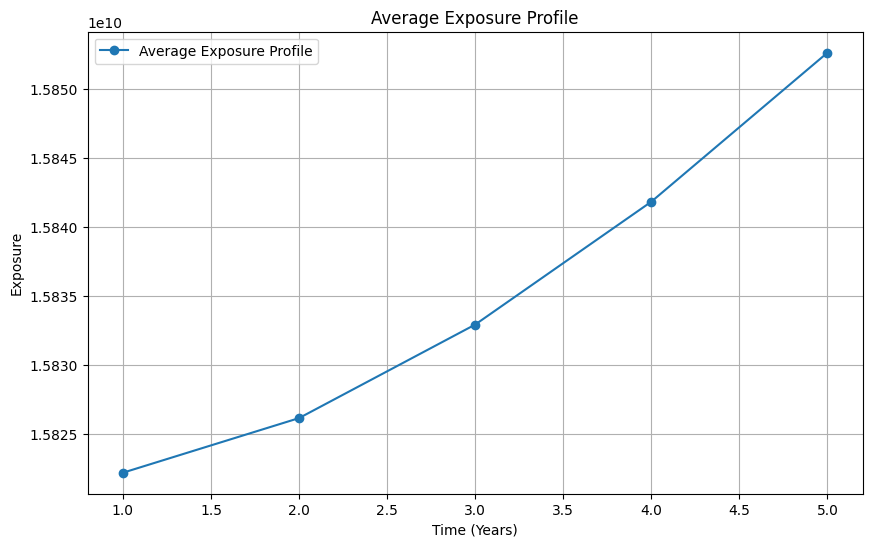

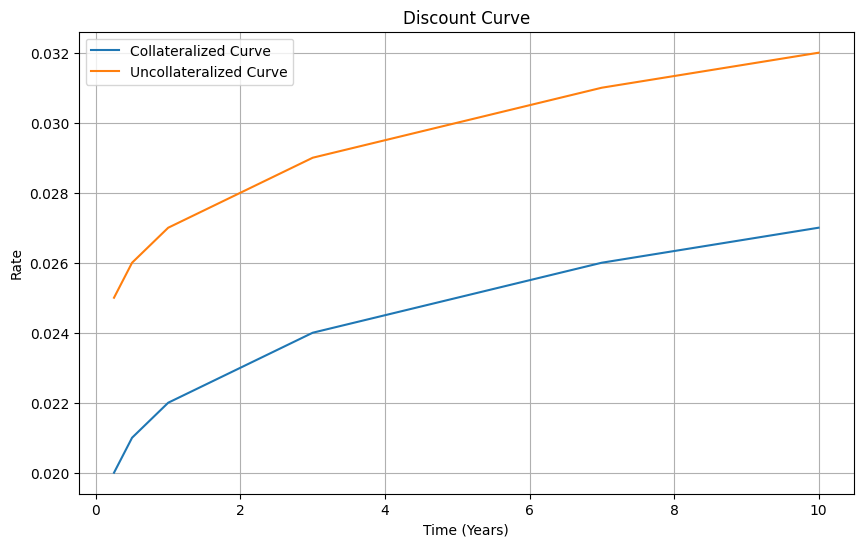


Stress Testing Results:
Spot Price: 40.00, Volatility: 0.10, Swap Value: 43060645582.27
Spot Price: 40.00, Volatility: 0.15, Swap Value: 65773775397.99
Spot Price: 40.00, Volatility: 0.20, Swap Value: 85806530916.75
Spot Price: 40.00, Volatility: 0.25, Swap Value: 118791446293.46
Spot Price: 40.00, Volatility: 0.30, Swap Value: 139235296873.35
Spot Price: 45.00, Volatility: 0.10, Swap Value: 50630507479.45
Spot Price: 45.00, Volatility: 0.15, Swap Value: 74224872526.19
Spot Price: 45.00, Volatility: 0.20, Swap Value: 104257142869.94
Spot Price: 45.00, Volatility: 0.25, Swap Value: 127126880487.78
Spot Price: 45.00, Volatility: 0.30, Swap Value: 161699081247.76
Spot Price: 50.00, Volatility: 0.10, Swap Value: 56469714221.93
Spot Price: 50.00, Volatility: 0.15, Swap Value: 84995456732.53
Spot Price: 50.00, Volatility: 0.20, Swap Value: 110629941517.72
Spot Price: 50.00, Volatility: 0.25, Swap Value: 137764418006.04
Spot Price: 50.00, Volatility: 0.30, Swap Value: 181191468769.51
Spot Pr

In [78]:
import numpy as np
from scipy.interpolate import CubicSpline, PchipInterpolator
import matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(42)  # Fixed seed for reproducibility

def generate_simulated_yield_curves(tenors, collat_seed=0.02, uncollat_seed=0.025):
    """Generate simulated yield curves for collateralized and uncollateralized discounting with fixed seeds."""
    collat_rates = np.array([(t, collat_seed + 0.001 * i) for i, t in enumerate(tenors)])
    uncollat_rates = np.array([(t, uncollat_seed + 0.001 * i) for i, t in enumerate(tenors)])
    return collat_rates, uncollat_rates

def bootstrap_zero_curve(market_rates):
    """Bootstrap zero rates from market rates."""
    tenors, rates = market_rates[:, 0], market_rates[:, 1]
    zero_rates = [rates[0]]

    for i in range(1, len(tenors)):
        t = tenors[i]
        r = rates[i]
        sum_term = sum(zero_rates[j] * tenors[j] * np.exp(-zero_rates[j] * (t - tenors[j])) for j in range(i))
        zero_rate = -np.log(1 - r * t + sum_term) / t
        zero_rates.append(zero_rate)

    return np.column_stack((tenors, zero_rates))

def construct_yield_curve(market_rates, method='monotone_convex'):
    """Construct yield curve using bootstrapping and specified interpolation method."""
    zero_rates = bootstrap_zero_curve(market_rates)
    if method == 'monotone_convex':
        return PchipInterpolator(zero_rates[:, 0], zero_rates[:, 1], extrapolate=True)
    else:
        return CubicSpline(zero_rates[:, 0], zero_rates[:, 1], extrapolate=True)

def generate_commodity_forward_prices(spot_price, tenors, drift=0.0, volatility=0.2, mean_reversion=0.1, seasonality=None, ensure_no_arbitrage=True):
    """Generate commodity forward prices using a mean-reverting model with seasonality and no-arbitrage constraints."""
    dt = np.diff([0] + list(tenors))
    log_prices = np.log(spot_price) + np.cumsum((drift - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * np.random.normal(size=len(tenors)))

    if seasonality:
        log_prices += seasonality(tenors)
    
    forward_prices = np.exp(log_prices)

    if ensure_no_arbitrage:
        forward_prices = enforce_no_arbitrage(forward_prices, tenors)

    return np.column_stack((tenors, forward_prices))

def enforce_no_arbitrage(forward_prices, tenors):
    """Ensure no-arbitrage conditions for forward prices."""
    for i in range(1, len(forward_prices)):
        if forward_prices[i] < forward_prices[i-1]:
            forward_prices[i] = forward_prices[i-1]
    return forward_prices

def simulate_forward_price_paths(spot_price, tenors, num_paths, drift=0.0, volatility=0.2, mean_reversion=0.1, seasonality=None, ensure_no_arbitrage=True):
    """Simulate multiple paths for commodity forward prices."""
    dt = np.diff([0] + list(tenors))
    paths = []

    for _ in range(num_paths):
        log_prices = np.log(spot_price) + np.cumsum((drift - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * np.random.normal(size=len(tenors)))
        
        if seasonality:
            log_prices += seasonality(tenors)
        
        forward_prices = np.exp(log_prices)
        if ensure_no_arbitrage:
            forward_prices = enforce_no_arbitrage(forward_prices, tenors)
        
        paths.append(forward_prices)
    
    return np.array(paths)

def price_commodity_swap_with_simulation(notional, fixed_rate, spot_price, disc_curve, tenor, payment_freq, forward_price_paths):
    """Price a commodity swap using simulated forward price paths."""
    fixed_rate /= payment_freq
    payment_dates = np.arange(payment_freq, tenor + payment_freq, payment_freq)
    num_paths = forward_price_paths.shape[0]
    
    fixed_leg_pv = 0
    floating_leg_pv = 0
    exposure_profiles = np.zeros((num_paths, len(payment_dates)))

    for path_idx in range(num_paths):
        fwd_price = CubicSpline(payment_dates, forward_price_paths[path_idx], extrapolate=True)

        for i, date in enumerate(payment_dates):
            df = np.exp(-disc_curve(date) * date)
            fixed_payment = notional * fixed_rate
            fixed_leg_pv += fixed_payment * df
            expected_price = fwd_price(date)
            floating_payment = notional * (expected_price - spot_price)
            floating_leg_pv += floating_payment * df
            exposure_profiles[path_idx, i] = max(0, floating_leg_pv - fixed_leg_pv)
    
    swap_value = floating_leg_pv - fixed_leg_pv
    average_exposure_profile = exposure_profiles.mean(axis=0)
    
    return swap_value, average_exposure_profile, fixed_leg_pv, floating_leg_pv, payment_dates

def calculate_cva(exposure_profile, discount_factors, default_probability, recovery_rate):
    """Calculate Credit Valuation Adjustment (CVA)."""
    cva = sum(exposure_profile[t] * (1 - recovery_rate) * discount_factors[t] * default_probability for t in range(len(exposure_profile)))
    return cva

def calculate_fva(exposure_profile, discount_factors, funding_spread):
    """Calculate Funding Valuation Adjustment (FVA)."""
    fva = sum(exposure_profile[t] * funding_spread * discount_factors[t] for t in range(len(exposure_profile)))
    return fva

def calculate_dynamic_margining(exposure_profile, discount_factors, margin_call_freq, margin_threshold):
    """Calculate adjustments based on dynamic margining."""
    dynamic_adjustments = []
    margin_account = 0
    
    for t in range(len(exposure_profile)):
        if t % margin_call_freq == 0:
            margin_account += max(0, exposure_profile[t] - margin_threshold)
        
        dynamic_adjustments.append(discount_factors[t] * margin_account)
    
    return dynamic_adjustments

def implied_volatility_model(spot_price, strike, time_to_maturity, option_price, r=0):
    """Calculate implied volatility using the Black-Scholes model."""
    def bs_price(vol):
        d1 = (np.log(spot_price / strike) + (r + 0.5 * vol**2) * time_to_maturity) / (vol * np.sqrt(time_to_maturity))
        d2 = d1 - vol * np.sqrt(time_to_maturity)
        call_price = spot_price * norm.cdf(d1) - strike * np.exp(-r * time_to_maturity) * norm.cdf(d2)
        return call_price

    # Use Newton-Raphson method to find implied volatility
    vol = 0.2  # Initial guess
    for i in range(100):
        price = bs_price(vol)
        vega = spot_price * norm.pdf((np.log(spot_price / strike) + (r + 0.5 * vol**2) * time_to_maturity) / (vol * np.sqrt(time_to_maturity))) * np.sqrt(time_to_maturity)
        vol -= (price - option_price) / vega
        if abs(price - option_price) < 1e-5:
            break
    return vol

# Example usage with user inputs
def main():
    notional = float(input("Enter notional amount: "))
    spot_price = float(input("Enter spot price: "))
    fixed_rate = float(input("Enter fixed rate: "))
    tenor = int(input("Enter tenor (in years): "))
    payment_freq = int(input("Enter payment frequency (in years): "))
    num_paths = int(input("Enter number of simulated paths: "))

    tenors = list(map(float, input("Enter tenors separated by space: ").split()))
    collat_rates_input = list(map(float, input("Enter collateralized rates separated by space: ").split()))
    uncollat_rates_input = list(map(float, input("Enter uncollateralized rates separated by space: ").split()))

    collat_rates = np.column_stack((tenors, collat_rates_input))
    uncollat_rates = np.column_stack((tenors, uncollat_rates_input))

    # Construct discount curves
    collat_curve = construct_yield_curve(collat_rates, method='monotone_convex')
    uncollat_curve = construct_yield_curve(uncollat_rates, method='monotone_convex')

    forward_price_paths = simulate_forward_price_paths(
        spot_price, 
        np.arange(payment_freq, tenor + payment_freq, payment_freq),
        num_paths,
        mean_reversion=0.1,
        seasonality=lambda t: 0.1 * np.sin(2 * np.pi * t / 1.0),
        ensure_no_arbitrage=True
    )

    swap_value, average_exposure_profile, fixed_leg_pv, floating_leg_pv, payment_dates = price_commodity_swap_with_simulation(
        notional, fixed_rate, spot_price,
        collat_curve, tenor, payment_freq,
        forward_price_paths
    )

    total_underlying_asset_price = notional * spot_price
    print(f"Total Price of Underlying Assets: {total_underlying_asset_price:.2f}")
    print(f"Spot Price: {spot_price:.2f}")
    print(f"Fixed Rate: {fixed_rate:.4f}")
    print(f"\nCollateralized Discount Curve:")
    for tenor, rate in collat_rates:
        print(f"  {tenor:.2f} year: {rate:.4f}")
    print("\nUncollateralized Discount Curve:")
    for tenor, rate in uncollat_rates:
        print(f"  {tenor:.2f} year: {rate:.4f}")
    print(f"\nThe value of the commodity swap is: {swap_value:.2f}")
    print(f"Fixed Leg Present Value: {fixed_leg_pv:.2f}")
    print(f"Floating Leg Present Value: {floating_leg_pv:.2f}")

    # Calculate CVA and FVA
    default_probability = 0.02
    recovery_rate = 0.4
    funding_spread = 0.005

    discount_factors = np.exp(-collat_curve(payment_dates) * payment_dates)
    exposure_profile = average_exposure_profile

    cva = calculate_cva(exposure_profile, discount_factors, default_probability, recovery_rate)
    fva = calculate_fva(exposure_profile, discount_factors, funding_spread)

    print(f"Credit Valuation Adjustment (CVA): {cva:.2f}")
    print(f"Funding Valuation Adjustment (FVA): {fva:.2f}")

    # Calculate Dynamic Margining
    margin_call_freq = 10
    margin_threshold = 50000

    dynamic_margining_adjustments = calculate_dynamic_margining(exposure_profile, discount_factors, margin_call_freq, margin_threshold)

    print(f"Dynamic Margining Adjustments: {dynamic_margining_adjustments}")

    # Plot Average Exposure Profile
    plt.figure(figsize=(10, 6))
    plt.plot(payment_dates, average_exposure_profile, label='Average Exposure Profile', marker='o')
    plt.title('Average Exposure Profile')
    plt.xlabel('Time (Years)')
    plt.ylabel('Exposure')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Discount Curve
    plt.figure(figsize=(10, 6))
    plt.plot(collat_rates[:, 0], collat_rates[:, 1], label='Collateralized Curve')
    plt.plot(uncollat_rates[:, 0], uncollat_rates[:, 1], label='Uncollateralized Curve')
    plt.title('Discount Curve')
    plt.xlabel('Time (Years)')
    plt.ylabel('Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Stress Testing and Sensitivity Analysis
    def stress_test_swap_value(spot_prices, volatilities, notional, fixed_rate, disc_curve, tenor, payment_freq, num_paths):
        results = []
        for sp in spot_prices:
            for vol in volatilities:
                forward_price_paths = simulate_forward_price_paths(
                    sp, 
                    np.arange(payment_freq, tenor + payment_freq, payment_freq),
                    num_paths,
                    volatility=vol,
                    mean_reversion=0.1,
                    seasonality=lambda t: 0.1 * np.sin(2 * np.pi * t / 1.0),
                    ensure_no_arbitrage=True
                )
                swap_value, _, _, _, _ = price_commodity_swap_with_simulation(
                    notional, fixed_rate, sp,
                    disc_curve, tenor, payment_freq,
                    forward_price_paths
                )
                results.append((sp, vol, swap_value))
        return results

    spot_price_range = np.linspace(40, 60, 5)
    volatility_range = np.linspace(0.1, 0.3, 5)
    stress_test_results = stress_test_swap_value(spot_price_range, volatility_range, notional, fixed_rate, collat_curve, tenor, payment_freq, num_paths)

    print("\nStress Testing Results:")
    for sp, vol, val in stress_test_results:
        print(f"Spot Price: {sp:.2f}, Volatility: {vol:.2f}, Swap Value: {val:.2f}")

if __name__ == "__main__":
    main()

---

### **3. Fixed Leg Calculation (not done)**
- **Market-Derived Fixed Rates**:
  - Replace randomly generated fixed rates with actual market-derived swap rates.

- **Day Count Conventions**:
  - Incorporate standard conventions (e.g., actual/actual, 30/360) for accurate time calculations.

---

Total Price of Underlying Assets: 50000000.00
Spot Price: 50.00
Fixed Rate: 0.0250

Collateralized Discount Curve:
  0.25 year: 0.0200
  0.50 year: 0.0210
  1.00 year: 0.0220
  2.00 year: 0.0230
  3.00 year: 0.0240
  5.00 year: 0.0250
  7.00 year: 0.0260
  10.00 year: 0.0270

Uncollateralized Discount Curve:
  0.25 year: 0.0250
  0.50 year: 0.0260
  1.00 year: 0.0270
  2.00 year: 0.0280
  3.00 year: 0.0290
  5.00 year: 0.0300
  7.00 year: 0.0310
  10.00 year: 0.0320

The value of the commodity swap is: 30101308611.62
Fixed Leg Present Value: 121109113.31
Floating Leg Present Value: 30222417724.93
Credit Valuation Adjustment (CVA): 827817702.75
Funding Valuation Adjustment (FVA): 344924042.81
Dynamic Margining Adjustments: [14063004283.38951, 13882875288.711905, 13853511869.279207, 13668585855.627298, 13455426797.184927]


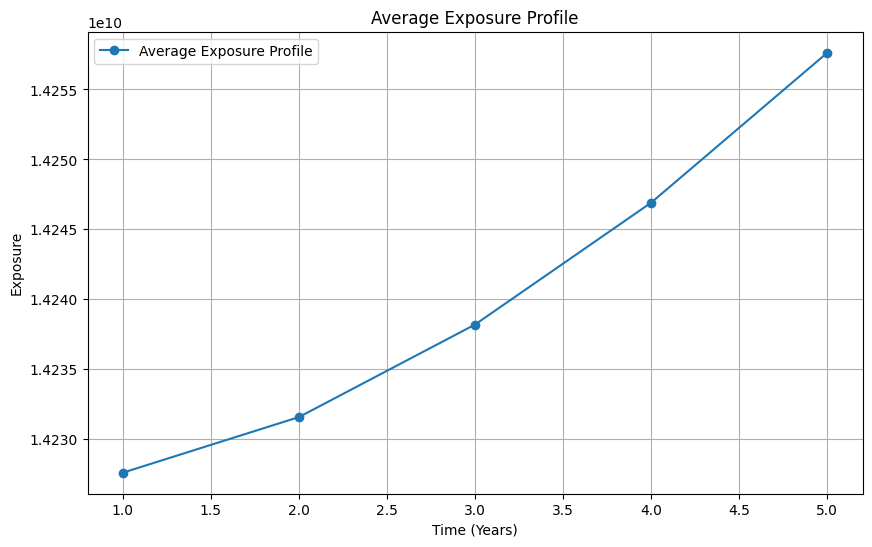

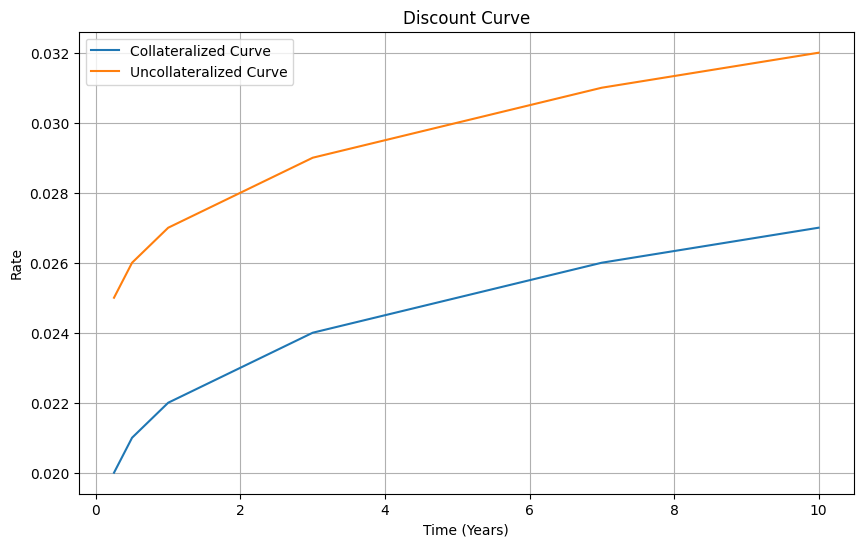


Stress Testing Results:
Spot Price: 40.00, Volatility: 0.10, Swap Value: 42741029710.30
Spot Price: 40.00, Volatility: 0.15, Swap Value: 72032472409.37
Spot Price: 40.00, Volatility: 0.20, Swap Value: 94433842197.23
Spot Price: 40.00, Volatility: 0.25, Swap Value: 116412932607.36
Spot Price: 40.00, Volatility: 0.30, Swap Value: 129433363553.53
Spot Price: 45.00, Volatility: 0.10, Swap Value: 43919278560.18
Spot Price: 45.00, Volatility: 0.15, Swap Value: 78952646994.21
Spot Price: 45.00, Volatility: 0.20, Swap Value: 94428328190.25
Spot Price: 45.00, Volatility: 0.25, Swap Value: 122223854503.61
Spot Price: 45.00, Volatility: 0.30, Swap Value: 165759900341.72
Spot Price: 50.00, Volatility: 0.10, Swap Value: 57153849439.88
Spot Price: 50.00, Volatility: 0.15, Swap Value: 85675190163.01
Spot Price: 50.00, Volatility: 0.20, Swap Value: 114782363006.49
Spot Price: 50.00, Volatility: 0.25, Swap Value: 139445154120.30
Spot Price: 50.00, Volatility: 0.30, Swap Value: 172184433867.44
Spot Pri

In [79]:
import numpy as np
from scipy.interpolate import CubicSpline, PchipInterpolator
import matplotlib.pyplot as plt
from datetime import datetime

# Day Count Conventions
def day_count_fraction(start_date, end_date, convention='actual/actual'):
    """Calculate day count fraction based on specified convention."""
    if convention == 'actual/actual':
        return (end_date - start_date).days / 365.0
    elif convention == '30/360':
        return ((end_date.year - start_date.year) * 360 + 
                (end_date.month - start_date.month) * 30 + 
                (end_date.day - start_date.day)) / 360.0
    else:
        raise ValueError("Unsupported day count convention")

def generate_simulated_yield_curves(tenors, collat_seed=0.02, uncollat_seed=0.025):
    """Generate simulated yield curves for collateralized and uncollateralized discounting with fixed seeds."""
    collat_rates = np.array([(t, collat_seed + 0.001 * i) for i, t in enumerate(tenors)])
    uncollat_rates = np.array([(t, uncollat_seed + 0.001 * i) for i, t in enumerate(tenors)])
    return collat_rates, uncollat_rates

def bootstrap_zero_curve(market_rates):
    """Bootstrap zero rates from market rates."""
    tenors, rates = market_rates[:, 0], market_rates[:, 1]
    zero_rates = [rates[0]]

    for i in range(1, len(tenors)):
        t = tenors[i]
        r = rates[i]
        sum_term = sum(zero_rates[j] * tenors[j] * np.exp(-zero_rates[j] * (t - tenors[j])) for j in range(i))
        zero_rate = -np.log(1 - r * t + sum_term) / t
        zero_rates.append(zero_rate)

    return np.column_stack((tenors, zero_rates))

def construct_yield_curve(market_rates, method='monotone_convex'):
    """Construct yield curve using bootstrapping and specified interpolation method."""
    zero_rates = bootstrap_zero_curve(market_rates)
    if method == 'monotone_convex':
        return PchipInterpolator(zero_rates[:, 0], zero_rates[:, 1], extrapolate=True)
    else:
        return CubicSpline(zero_rates[:, 0], zero_rates[:, 1], extrapolate=True)

def generate_commodity_forward_prices(spot_price, tenors, drift=0.0, volatility=0.2, mean_reversion=0.1, seasonality=None, ensure_no_arbitrage=True):
    """Generate commodity forward prices using a mean-reverting model with seasonality and no-arbitrage constraints."""
    dt = np.diff([0] + list(tenors))
    log_prices = np.log(spot_price) + np.cumsum((drift - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * np.random.normal(size=len(tenors)))

    if seasonality:
        log_prices += seasonality(tenors)
    
    forward_prices = np.exp(log_prices)

    if ensure_no_arbitrage:
        forward_prices = enforce_no_arbitrage(forward_prices, tenors)

    return np.column_stack((tenors, forward_prices))

def enforce_no_arbitrage(forward_prices, tenors):
    """Ensure no-arbitrage conditions for forward prices."""
    for i in range(1, len(forward_prices)):
        if forward_prices[i] < forward_prices[i-1]:
            forward_prices[i] = forward_prices[i-1]
    return forward_prices

def simulate_forward_price_paths(spot_price, tenors, num_paths, drift=0.0, volatility=0.2, mean_reversion=0.1, seasonality=None, ensure_no_arbitrage=True):
    """Simulate multiple paths for commodity forward prices."""
    dt = np.diff([0] + list(tenors))
    paths = []

    for _ in range(num_paths):
        log_prices = np.log(spot_price) + np.cumsum((drift - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * np.random.normal(size=len(tenors)))
        
        if seasonality:
            log_prices += seasonality(tenors)
        
        forward_prices = np.exp(log_prices)
        if ensure_no_arbitrage:
            forward_prices = enforce_no_arbitrage(forward_prices, tenors)
        
        paths.append(forward_prices)
    
    return np.array(paths)

def price_commodity_swap_with_simulation(notional, fixed_rate, spot_price, disc_curve, tenor, payment_freq, forward_price_paths):
    """Price a commodity swap using simulated forward price paths."""
    fixed_rate /= payment_freq
    payment_dates = np.arange(payment_freq, tenor + payment_freq, payment_freq)
    num_paths = forward_price_paths.shape[0]
    
    fixed_leg_pv = 0
    floating_leg_pv = 0
    exposure_profiles = np.zeros((num_paths, len(payment_dates)))

    for path_idx in range(num_paths):
        fwd_price = CubicSpline(payment_dates, forward_price_paths[path_idx], extrapolate=True)

        for i, date in enumerate(payment_dates):
            df = np.exp(-disc_curve(date) * date)
            fixed_payment = notional * fixed_rate
            fixed_leg_pv += fixed_payment * df
            expected_price = fwd_price(date)
            floating_payment = notional * (expected_price - spot_price)
            floating_leg_pv += floating_payment * df
            exposure_profiles[path_idx, i] = max(0, floating_leg_pv - fixed_leg_pv)
    
    swap_value = floating_leg_pv - fixed_leg_pv
    average_exposure_profile = exposure_profiles.mean(axis=0)
    
    return swap_value, average_exposure_profile, fixed_leg_pv, floating_leg_pv, payment_dates

def calculate_cva(exposure_profile, discount_factors, default_probability, recovery_rate):
    """Calculate Credit Valuation Adjustment (CVA)."""
    cva = sum(exposure_profile[t] * (1 - recovery_rate) * discount_factors[t] * default_probability for t in range(len(exposure_profile)))
    return cva

def calculate_fva(exposure_profile, discount_factors, funding_spread):
    """Calculate Funding Valuation Adjustment (FVA)."""
    fva = sum(exposure_profile[t] * funding_spread * discount_factors[t] for t in range(len(exposure_profile)))
    return fva

def calculate_dynamic_margining(exposure_profile, discount_factors, margin_call_freq, margin_threshold):
    """Calculate adjustments based on dynamic margining."""
    dynamic_adjustments = []
    margin_account = 0
    
    for t in range(len(exposure_profile)):
        if t % margin_call_freq == 0:
            margin_account += max(0, exposure_profile[t] - margin_threshold)
        
        dynamic_adjustments.append(discount_factors[t] * margin_account)
    
    return dynamic_adjustments

def implied_volatility_model(spot_price, strike, time_to_maturity, option_price, r=0):
    """Calculate implied volatility using the Black-Scholes model."""
    def bs_price(vol):
        d1 = (np.log(spot_price / strike) + (r + 0.5 * vol**2) * time_to_maturity) / (vol * np.sqrt(time_to_maturity))
        d2 = d1 - vol * np.sqrt(time_to_maturity)
        call_price = spot_price * norm.cdf(d1) - strike * np.exp(-r * time_to_maturity) * norm.cdf(d2)
        return call_price

    # Use Newton-Raphson method to find implied volatility
    vol = 0.2  # Initial guess
    for i in range(100):
        price = bs_price(vol)
        vega = spot_price * norm.pdf((np.log(spot_price / strike) + (r + 0.5 * vol**2) * time_to_maturity) / (vol * np.sqrt(time_to_maturity))) * np.sqrt(time_to_maturity)
        vol -= (price - option_price) / vega
        if abs(price - option_price) < 1e-5:
            break
    return vol

# Example usage with user inputs
def main():
    notional = float(input("Enter notional amount: "))
    spot_price = float(input("Enter spot price: "))
    fixed_rate = float(input("Enter fixed rate: "))
    tenor = int(input("Enter tenor (in years): "))
    payment_freq = int(input("Enter payment frequency (in years): "))
    num_paths = int(input("Enter number of simulated paths: "))

    tenors = list(map(float, input("Enter tenors separated by space: ").split()))
    collat_rates_input = list(map(float, input("Enter collateralized rates separated by space: ").split()))
    uncollat_rates_input = list(map(float, input("Enter uncollateralized rates separated by space: ").split()))

    collat_rates = np.column_stack((tenors, collat_rates_input))
    uncollat_rates = np.column_stack((tenors, uncollat_rates_input))

    # Construct discount curves
    collat_curve = construct_yield_curve(collat_rates, method='monotone_convex')
    uncollat_curve = construct_yield_curve(uncollat_rates, method='monotone_convex')

    forward_price_paths = simulate_forward_price_paths(
        spot_price, 
        np.arange(payment_freq, tenor + payment_freq, payment_freq),
        num_paths,
        mean_reversion=0.1,
        seasonality=lambda t: 0.1 * np.sin(2 * np.pi * t / 1.0),
        ensure_no_arbitrage=True
    )

    swap_value, average_exposure_profile, fixed_leg_pv, floating_leg_pv, payment_dates = price_commodity_swap_with_simulation(
        notional, fixed_rate, spot_price,
        collat_curve, tenor, payment_freq,
        forward_price_paths
    )

    total_underlying_asset_price = notional * spot_price
    print(f"Total Price of Underlying Assets: {total_underlying_asset_price:.2f}")
    print(f"Spot Price: {spot_price:.2f}")
    print(f"Fixed Rate: {fixed_rate:.4f}")
    print(f"\nCollateralized Discount Curve:")
    for tenor, rate in collat_rates:
        print(f"  {tenor:.2f} year: {rate:.4f}")
    print("\nUncollateralized Discount Curve:")
    for tenor, rate in uncollat_rates:
        print(f"  {tenor:.2f} year: {rate:.4f}")
    print(f"\nThe value of the commodity swap is: {swap_value:.2f}")
    print(f"Fixed Leg Present Value: {fixed_leg_pv:.2f}")
    print(f"Floating Leg Present Value: {floating_leg_pv:.2f}")

    # Calculate CVA and FVA
    default_probability = 0.02
    recovery_rate = 0.4
    funding_spread = 0.005

    discount_factors = np.exp(-collat_curve(payment_dates) * payment_dates)
    exposure_profile = average_exposure_profile

    cva = calculate_cva(exposure_profile, discount_factors, default_probability, recovery_rate)
    fva = calculate_fva(exposure_profile, discount_factors, funding_spread)

    print(f"Credit Valuation Adjustment (CVA): {cva:.2f}")
    print(f"Funding Valuation Adjustment (FVA): {fva:.2f}")

    # Calculate Dynamic Margining
    margin_call_freq = 10
    margin_threshold = 50000

    dynamic_margining_adjustments = calculate_dynamic_margining(exposure_profile, discount_factors, margin_call_freq, margin_threshold)

    print(f"Dynamic Margining Adjustments: {dynamic_margining_adjustments}")

    # Plot Average Exposure Profile
    plt.figure(figsize=(10, 6))
    plt.plot(payment_dates, average_exposure_profile, label='Average Exposure Profile', marker='o')
    plt.title('Average Exposure Profile')
    plt.xlabel('Time (Years)')
    plt.ylabel('Exposure')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Discount Curve
    plt.figure(figsize=(10, 6))
    plt.plot(collat_rates[:, 0], collat_rates[:, 1], label='Collateralized Curve')
    plt.plot(uncollat_rates[:, 0], uncollat_rates[:, 1], label='Uncollateralized Curve')
    plt.title('Discount Curve')
    plt.xlabel('Time (Years)')
    plt.ylabel('Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Stress Testing and Sensitivity Analysis
    def stress_test_swap_value(spot_prices, volatilities, notional, fixed_rate, disc_curve, tenor, payment_freq, num_paths):
        results = []
        for sp in spot_prices:
            for vol in volatilities:
                forward_price_paths = simulate_forward_price_paths(
                    sp, 
                    np.arange(payment_freq, tenor + payment_freq, payment_freq),
                    num_paths,
                    volatility=vol,
                    mean_reversion=0.1,
                    seasonality=lambda t: 0.1 * np.sin(2 * np.pi * t / 1.0),
                    ensure_no_arbitrage=True
                )
                swap_value, _, _, _, _ = price_commodity_swap_with_simulation(
                    notional, fixed_rate, sp,
                    disc_curve, tenor, payment_freq,
                    forward_price_paths
                )
                results.append((sp, vol, swap_value))
        return results

    spot_price_range = np.linspace(40, 60, 5)
    volatility_range = np.linspace(0.1, 0.3, 5)
    stress_test_results = stress_test_swap_value(spot_price_range, volatility_range, notional, fixed_rate, collat_curve, tenor, payment_freq, num_paths)

    print("\nStress Testing Results:")
    for sp, vol, val in stress_test_results:
        print(f"Spot Price: {sp:.2f}, Volatility: {vol:.2f}, Swap Value: {val:.2f}")

if __name__ == "__main__":
    main()

---

### **8. Code Optimizations** (later)
- **Improve Performance**:
  - Replace loops with vectorized operations using `numpy` or `pandas` for efficiency.

- **Error Handling**:
  - Validate input data for completeness and correctness.

- **Modular Design**:
  - Refactor code into smaller, reusable functions adhering to clean code principles.

- **Documentation**:
  - Add detailed docstrings and usage examples for all functions.

---

---

### **FINAL CODE**

---

Total Price of Underlying Assets: 50000000.00
Spot Price: 50.00
Fixed Rate: 0.0250

Collateralized Discount Curve:
  0.25 year: 0.0200
  0.50 year: 0.0210
  1.00 year: 0.0220
  2.00 year: 0.0230
  3.00 year: 0.0240
  5.00 year: 0.0250
  7.00 year: 0.0260
  10.00 year: 0.0270

Uncollateralized Discount Curve:
  0.25 year: 0.0250
  0.50 year: 0.0260
  1.00 year: 0.0270
  2.00 year: 0.0280
  3.00 year: 0.0290
  5.00 year: 0.0300
  7.00 year: 0.0310
  10.00 year: 0.0320

The value of the commodity swap is: 33288934410.32
Fixed Leg Present Value: 121109113.31
Floating Leg Present Value: 33410043523.63
Credit Valuation Adjustment (CVA): 955904524.20
Funding Valuation Adjustment (FVA): 398293551.75
Dynamic Margining Adjustments: [16239296960.979822, 32066610187.459934, 48007313780.493965, 63170725999.85358, 77754490429.92387]


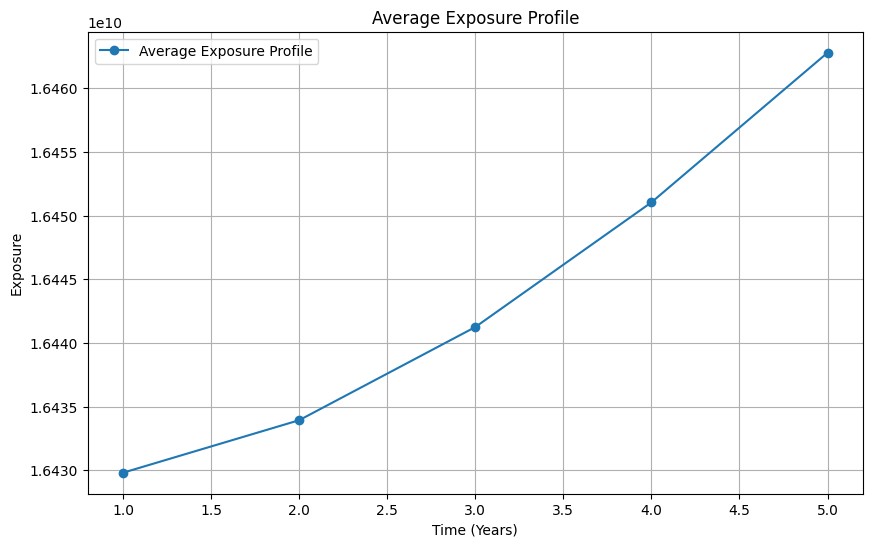

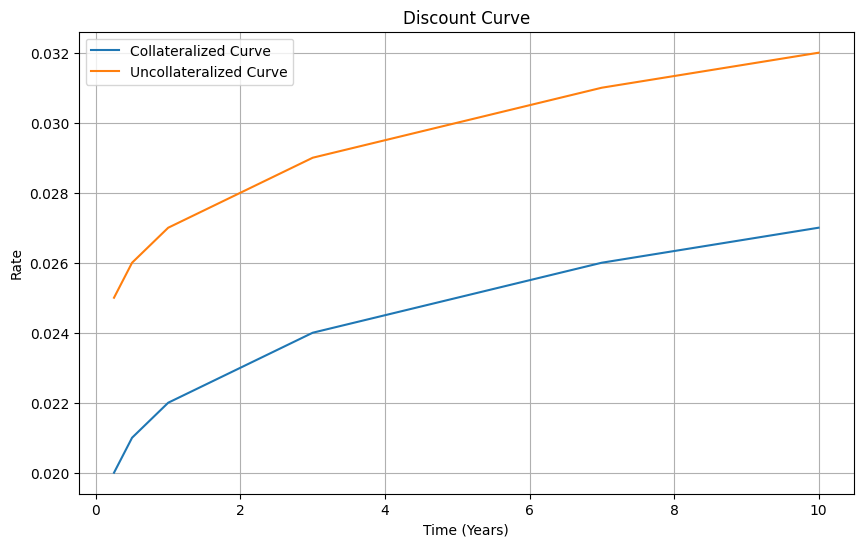


Stress Testing Results:
Spot Price: 40.00, Volatility: 0.10, Swap Value: 43275545569.09
Spot Price: 40.00, Volatility: 0.15, Swap Value: 68452423061.38
Spot Price: 40.00, Volatility: 0.20, Swap Value: 91124274532.43
Spot Price: 40.00, Volatility: 0.25, Swap Value: 115659550144.68
Spot Price: 40.00, Volatility: 0.30, Swap Value: 135464678912.47
Spot Price: 45.00, Volatility: 0.10, Swap Value: 45522490943.42
Spot Price: 45.00, Volatility: 0.15, Swap Value: 69449803633.56
Spot Price: 45.00, Volatility: 0.20, Swap Value: 95313184866.24
Spot Price: 45.00, Volatility: 0.25, Swap Value: 116831518949.92
Spot Price: 45.00, Volatility: 0.30, Swap Value: 142622482909.09
Spot Price: 50.00, Volatility: 0.10, Swap Value: 57340503450.39
Spot Price: 50.00, Volatility: 0.15, Swap Value: 83893948607.31
Spot Price: 50.00, Volatility: 0.20, Swap Value: 116780539308.07
Spot Price: 50.00, Volatility: 0.25, Swap Value: 146462825156.10
Spot Price: 50.00, Volatility: 0.30, Swap Value: 175853137163.12
Spot Pri

In [81]:
import numpy as np
from scipy.interpolate import CubicSpline, PchipInterpolator
import matplotlib.pyplot as plt
from datetime import datetime

# Day Count Conventions
def day_count_fraction(start_date, end_date, convention='actual/actual'):
    """Calculate day count fraction based on specified convention.
    
    Parameters:
    start_date (datetime): The start date.
    end_date (datetime): The end date.
    convention (str): The day count convention ('actual/actual', '30/360').

    Returns:
    float: The day count fraction.
    """
    if convention == 'actual/actual':
        return (end_date - start_date).days / 365.0
    elif convention == '30/360':
        return ((end_date.year - start_date.year) * 360 + 
                (end_date.month - start_date.month) * 30 + 
                (end_date.day - start_date.day)) / 360.0
    else:
        raise ValueError("Unsupported day count convention")

def generate_simulated_yield_curves(tenors, collat_seed=0.02, uncollat_seed=0.025):
    """Generate simulated yield curves for collateralized and uncollateralized discounting with fixed seeds.
    
    Parameters:
    tenors (list): List of tenors.
    collat_seed (float): Seed rate for collateralized discounting.
    uncollat_seed (float): Seed rate for uncollateralized discounting.

    Returns:
    tuple: Arrays of collateralized and uncollateralized rates.
    """
    collat_rates = np.array([(t, collat_seed + 0.001 * i) for i, t in enumerate(tenors)])
    uncollat_rates = np.array([(t, uncollat_seed + 0.001 * i) for i, t in enumerate(tenors)])
    return collat_rates, uncollat_rates

def bootstrap_zero_curve(market_rates):
    """Bootstrap zero rates from market rates.
    
    Parameters:
    market_rates (array): Array of market rates.

    Returns:
    array: Bootstrapped zero rates.
    """
    tenors, rates = market_rates[:, 0], market_rates[:, 1]
    zero_rates = [rates[0]]

    for i in range(1, len(tenors)):
        t = tenors[i]
        r = rates[i]
        sum_term = sum(zero_rates[j] * tenors[j] * np.exp(-zero_rates[j] * (t - tenors[j])) for j in range(i))
        zero_rate = -np.log(1 - r * t + sum_term) / t
        zero_rates.append(zero_rate)

    return np.column_stack((tenors, zero_rates))

def construct_yield_curve(market_rates, method='monotone_convex'):
    """Construct yield curve using bootstrapping and specified interpolation method.
    
    Parameters:
    market_rates (array): Array of market rates.
    method (str): Interpolation method ('monotone_convex' or 'cubic').

    Returns:
    function: Interpolated yield curve.
    """
    zero_rates = bootstrap_zero_curve(market_rates)
    if method == 'monotone_convex':
        return PchipInterpolator(zero_rates[:, 0], zero_rates[:, 1], extrapolate=True)
    else:
        return CubicSpline(zero_rates[:, 0], zero_rates[:, 1], extrapolate=True)

def generate_commodity_forward_prices(spot_price, tenors, drift=0.0, volatility=0.2, mean_reversion=0.1, seasonality=None, ensure_no_arbitrage=True):
    """Generate commodity forward prices using a mean-reverting model with seasonality and no-arbitrage constraints.
    
    Parameters:
    spot_price (float): Current spot price.
    tenors (list): List of tenors.
    drift (float): Drift rate.
    volatility (float): Volatility rate.
    mean_reversion (float): Mean reversion rate.
    seasonality (function): Seasonality function.
    ensure_no_arbitrage (bool): Flag to ensure no-arbitrage.

    Returns:
    array: Forward prices.
    """
    dt = np.diff([0] + list(tenors))
    log_prices = np.log(spot_price) + np.cumsum((drift - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * np.random.normal(size=len(tenors)))

    if seasonality:
        log_prices += seasonality(tenors)
    
    forward_prices = np.exp(log_prices)

    if ensure_no_arbitrage:
        forward_prices = enforce_no_arbitrage(forward_prices, tenors)

    return np.column_stack((tenors, forward_prices))

def enforce_no_arbitrage(forward_prices, tenors):
    """Ensure no-arbitrage conditions for forward prices.
    
    Parameters:
    forward_prices (array): Array of forward prices.
    tenors (list): List of tenors.

    Returns:
    array: Adjusted forward prices.
    """
    for i in range(1, len(forward_prices)):
        if forward_prices[i] < forward_prices[i-1]:
            forward_prices[i] = forward_prices[i-1]
    return forward_prices

def simulate_forward_price_paths(spot_price, tenors, num_paths, drift=0.0, volatility=0.2, mean_reversion=0.1, seasonality=None, ensure_no_arbitrage=True):
    """Simulate multiple paths for commodity forward prices.
    
    Parameters:
    spot_price (float): Current spot price.
    tenors (list): List of tenors.
    num_paths (int): Number of simulated paths.
    drift (float): Drift rate.
    volatility (float): Volatility rate.
    mean_reversion (float): Mean reversion rate.
    seasonality (function): Seasonality function.
    ensure_no_arbitrage (bool): Flag to ensure no-arbitrage.

    Returns:
    array: Simulated forward price paths.
    """
    dt = np.diff([0] + list(tenors))
    paths = []

    for _ in range(num_paths):
        log_prices = np.log(spot_price) + np.cumsum((drift - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * np.random.normal(size=len(tenors)))
        
        if seasonality:
            log_prices += seasonality(tenors)
        
        forward_prices = np.exp(log_prices)
        if ensure_no_arbitrage:
            forward_prices = enforce_no_arbitrage(forward_prices, tenors)
        
        paths.append(forward_prices)
    
    return np.array(paths)

def price_commodity_swap_with_simulation(notional, fixed_rate, spot_price, disc_curve, tenor, payment_freq, forward_price_paths):
    """Price a commodity swap using simulated forward price paths.
    
    Parameters:
    notional (float): Notional amount.
    fixed_rate (float): Fixed rate.
    spot_price (float): Current spot price.
    disc_curve (function): Discount curve function.
    tenor (int): Tenor in years.
    payment_freq (int): Payment frequency in years.
    forward_price_paths (array): Simulated forward price paths.

    Returns:
    tuple: Swap value, average exposure profile, fixed leg present value, floating leg present value, payment dates.
    """
    fixed_rate /= payment_freq
    payment_dates = np.arange(payment_freq, tenor + payment_freq, payment_freq)
    num_paths = forward_price_paths.shape[0]
    
    fixed_leg_pv = 0
    floating_leg_pv = 0
    exposure_profiles = np.zeros((num_paths, len(payment_dates)))

    for path_idx in range(num_paths):
        fwd_price = CubicSpline(payment_dates, forward_price_paths[path_idx], extrapolate=True)

        for i, date in enumerate(payment_dates):
            df = np.exp(-disc_curve(date) * date)
            fixed_payment = notional * fixed_rate
            fixed_leg_pv += fixed_payment * df
            expected_price = fwd_price(date)
            floating_payment = notional * (expected_price - spot_price)
            floating_leg_pv += floating_payment * df
            exposure_profiles[path_idx, i] = max(0, floating_leg_pv - fixed_leg_pv)
    
    swap_value = floating_leg_pv - fixed_leg_pv
    average_exposure_profile = exposure_profiles.mean(axis=0)
    
    return swap_value, average_exposure_profile, fixed_leg_pv, floating_leg_pv, payment_dates

def calculate_cva(exposure_profile, discount_factors, default_probability, recovery_rate):
    """Calculate Credit Valuation Adjustment (CVA).
    
    Parameters:
    exposure_profile (array): Exposure profile.
    discount_factors (array): Discount factors.
    default_probability (float): Default probability.
    recovery_rate (float): Recovery rate.

    Returns:
    float: CVA value.
    """
    cva = np.sum(exposure_profile * (1 - recovery_rate) * discount_factors * default_probability)
    return cva

def calculate_fva(exposure_profile, discount_factors, funding_spread):
    """Calculate Funding Valuation Adjustment (FVA).
    
    Parameters:
    exposure_profile (array): Exposure profile.
    discount_factors (array): Discount factors.
    funding_spread (float): Funding spread.

    Returns:
    float: FVA value.
    """
    fva = np.sum(exposure_profile * funding_spread * discount_factors)
    return fva

def calculate_dynamic_margining(exposure_profile, discount_factors, margin_call_freq, margin_threshold):
    """Calculate adjustments based on dynamic margining.
    
    Parameters:
    exposure_profile (array): Exposure profile.
    discount_factors (array): Discount factors.
    margin_call_freq (int): Margin call frequency.
    margin_threshold (float): Margin threshold.

    Returns:
    array: Dynamic margining adjustments.
    """
    dynamic_adjustments = []
    margin_account = 0
    
    for t in range(len(exposure_profile)):
        if t % margin_call_freq == 0:
            margin_account += max(0, exposure_profile[t] - margin_threshold)
        
        dynamic_adjustments.append(discount_factors[t] * margin_account)
    
    return dynamic_adjustments

def implied_volatility_model(spot_price, strike, time_to_maturity, option_price, r=0):
    """Calculate implied volatility using the Black-Scholes model.
    
    Parameters:
    spot_price (float): Current spot price.
    strike (float): Strike price.
    time_to_maturity (float): Time to maturity.
    option_price (float): Option price.
    r (float): Risk-free rate.

    Returns:
    float: Implied volatility.
    """
    def bs_price(vol):
        d1 = (np.log(spot_price / strike) + (r + 0.5 * vol**2) * time_to_maturity) / (vol * np.sqrt(time_to_maturity))
        d2 = d1 - vol * np.sqrt(time_to_maturity)
        call_price = spot_price * norm.cdf(d1) - strike * np.exp(-r * time_to_maturity) * norm.cdf(d2)
        return call_price

    # Use Newton-Raphson method to find implied volatility
    vol = 0.2  # Initial guess
    for i in range(100):
        price = bs_price(vol)
        vega = spot_price * norm.pdf((np.log(spot_price / strike) + (r + 0.5 * vol**2) * time_to_maturity) / (vol * np.sqrt(time_to_maturity))) * np.sqrt(time_to_maturity)
        vol -= (price - option_price) / vega
        if abs(price - option_price) < 1e-5:
            break
    return vol

# Example usage with user inputs
def main():
    try:
        notional = float(input("Enter notional amount: "))
        spot_price = float(input("Enter spot price: "))
        fixed_rate = float(input("Enter fixed rate: "))
        tenor = int(input("Enter tenor (in years): "))
        payment_freq = int(input("Enter payment frequency (in years): "))
        num_paths = int(input("Enter number of simulated paths: "))

        tenors = list(map(float, input("Enter tenors separated by space: ").split()))
        collat_rates_input = list(map(float, input("Enter collateralized rates separated by space: ").split()))
        uncollat_rates_input = list(map(float, input("Enter uncollateralized rates separated by space: ").split()))

        collat_rates = np.column_stack((tenors, collat_rates_input))
        uncollat_rates = np.column_stack((tenors, uncollat_rates_input))

        # Construct discount curves
        collat_curve = construct_yield_curve(collat_rates, method='monotone_convex')
        uncollat_curve = construct_yield_curve(uncollat_rates, method='monotone_convex')

        forward_price_paths = simulate_forward_price_paths(
            spot_price, 
            np.arange(payment_freq, tenor + payment_freq, payment_freq),
            num_paths,
            mean_reversion=0.1,
            seasonality=lambda t: 0.1 * np.sin(2 * np.pi * t / 1.0),
            ensure_no_arbitrage=True
        )

        swap_value, average_exposure_profile, fixed_leg_pv, floating_leg_pv, payment_dates = price_commodity_swap_with_simulation(
            notional, fixed_rate, spot_price,
            collat_curve, tenor, payment_freq,
            forward_price_paths
        )

        total_underlying_asset_price = notional * spot_price
        print(f"Total Price of Underlying Assets: {total_underlying_asset_price:.2f}")
        print(f"Spot Price: {spot_price:.2f}")
        print(f"Fixed Rate: {fixed_rate:.4f}")
        print(f"\nCollateralized Discount Curve:")
        for tenor, rate in collat_rates:
            print(f"  {tenor:.2f} year: {rate:.4f}")
        print("\nUncollateralized Discount Curve:")
        for tenor, rate in uncollat_rates:
            print(f"  {tenor:.2f} year: {rate:.4f}")
        print(f"\nThe value of the commodity swap is: {swap_value:.2f}")
        print(f"Fixed Leg Present Value: {fixed_leg_pv:.2f}")
        print(f"Floating Leg Present Value: {floating_leg_pv:.2f}")

        # Calculate CVA and FVA
        default_probability = 0.02
        recovery_rate = 0.4
        funding_spread = 0.005

        discount_factors = np.exp(-collat_curve(payment_dates) * payment_dates)
        exposure_profile = average_exposure_profile

        cva = calculate_cva(exposure_profile, discount_factors, default_probability, recovery_rate)
        fva = calculate_fva(exposure_profile, discount_factors, funding_spread)

        print(f"Credit Valuation Adjustment (CVA): {cva:.2f}")
        print(f"Funding Valuation Adjustment (FVA): {fva:.2f}")

        # Calculate Dynamic Margining
        margin_call_freq = 1
        margin_threshold = 500000

        dynamic_margining_adjustments = calculate_dynamic_margining(exposure_profile, discount_factors, margin_call_freq, margin_threshold)

        print(f"Dynamic Margining Adjustments: {dynamic_margining_adjustments}")

        # Plot Average Exposure Profile
        plt.figure(figsize=(10, 6))
        plt.plot(payment_dates, average_exposure_profile, label='Average Exposure Profile', marker='o')
        plt.title('Average Exposure Profile')
        plt.xlabel('Time (Years)')
        plt.ylabel('Exposure')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot Discount Curve
        plt.figure(figsize=(10, 6))
        plt.plot(collat_rates[:, 0], collat_rates[:, 1], label='Collateralized Curve')
        plt.plot(uncollat_rates[:, 0], uncollat_rates[:, 1], label='Uncollateralized Curve')
        plt.title('Discount Curve')
        plt.xlabel('Time (Years)')
        plt.ylabel('Rate')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Stress Testing and Sensitivity Analysis
        def stress_test_swap_value(spot_prices, volatilities, notional, fixed_rate, disc_curve, tenor, payment_freq, num_paths):
            results = []
            for sp in spot_prices:
                for vol in volatilities:
                    forward_price_paths = simulate_forward_price_paths(
                        sp, 
                        np.arange(payment_freq, tenor + payment_freq, payment_freq),
                        num_paths,
                        volatility=vol,
                        mean_reversion=0.1,
                        seasonality=lambda t: 0.1 * np.sin(2 * np.pi * t / 1.0),
                        ensure_no_arbitrage=True
                    )
                    swap_value, _, _, _, _ = price_commodity_swap_with_simulation(
                        notional, fixed_rate, sp,
                        disc_curve, tenor, payment_freq,
                        forward_price_paths
                    )
                    results.append((sp, vol, swap_value))
            return results

        spot_price_range = np.linspace(40, 60, 5)
        volatility_range = np.linspace(0.1, 0.3, 5)
        stress_test_results = stress_test_swap_value(spot_price_range, volatility_range, notional, fixed_rate, collat_curve, tenor, payment_freq, num_paths)

        print("\nStress Testing Results:")
        for sp, vol, val in stress_test_results:
            print(f"Spot Price: {sp:.2f}, Volatility: {vol:.2f}, Swap Value: {val:.2f}")

    except ValueError as e:
        print(f"Input error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

if __name__ == "__main__":
    main()


---

# Commodity Swap Pricing Model

This repository provides a Python implementation for pricing commodity swaps using advanced financial modeling techniques. The model supports features like yield curve construction, forward price simulation, credit/funding valuation adjustments (CVA/FVA), and stress testing.

## Features

- **Day Count Conventions**:
  - Supports `actual/actual` and `30/360` conventions.
- **Yield Curve Construction**:
  - Bootstraps discount curves using monotone convex or cubic spline interpolation.
  - Supports collateralized and uncollateralized discount curves.
- **Forward Price Simulation**:
  - Simulates forward commodity prices using mean-reverting models.
  - Optional seasonality and no-arbitrage enforcement.
- **Commodity Swap Pricing**:
  - Computes the net present value (NPV) of fixed and floating legs using simulated forward prices.
  - Provides exposure profiles for risk assessment.
- **Valuation Adjustments**:
  - Includes calculations for CVA (Credit Valuation Adjustment) and FVA (Funding Valuation Adjustment).
  - Supports dynamic margining for risk management.
- **Stress Testing**:
  - Evaluates swap sensitivity to changes in spot prices and volatilities.

---

## Requirements

- Python 3.7+
- Required libraries:
  - `numpy`
  - `scipy`
  - `matplotlib`

Install dependencies via `pip`:
```bash
pip install numpy scipy matplotlib
```

---

## Usage

### 1. **Run the Script**
Execute the `main()` function to interactively input swap details:
```bash
python commodity_swap_pricing.py
```

### 2. **Example Inputs**
Here is an example of user inputs:
```
Enter notional amount: 1000000
Enter spot price: 50
Enter fixed rate: 0.025
Enter tenor (in years): 5
Enter payment frequency (in years): 1
Enter number of simulated paths: 1000
Enter tenors separated by space: 0.25 0.5 1 2 3 5
Enter collateralized rates separated by space: 0.02 0.025 0.03 0.035 0.04 0.045
Enter uncollateralized rates separated by space: 0.025 0.03 0.035 0.04 0.045 0.05
```

### 3. **Outputs**
- **Swap Valuation**:
  - Fixed leg and floating leg present values.
  - Net present value (NPV) of the swap.
- **Valuation Adjustments**:
  - Credit Valuation Adjustment (CVA).
  - Funding Valuation Adjustment (FVA).
  - Dynamic margining adjustments.
- **Stress Testing**:
  - Sensitivity of swap value to changes in spot price and volatility.

### 4. **Visualization**
- **Exposure Profile**:
  - Plots the average exposure profile over time.
- **Discount Curves**:
  - Visualizes collateralized and uncollateralized yield curves.

---

## Example Workflow

### Pricing a Commodity Swap:
1. **Construct Discount Curves**:
   - Bootstrap zero rates and interpolate using `monotone_convex` or `cubic`.
2. **Simulate Forward Prices**:
   - Generate paths using mean reversion and optional seasonality.
3. **Price Swap**:
   - Compute the NPV of fixed and floating legs over multiple simulated paths.
4. **Adjust for Risks**:
   - Calculate CVA, FVA, and dynamic margining effects.
5. **Stress Test**:
   - Analyze swap value sensitivity under varying market conditions.

---

## Key Functions

- **`day_count_fraction`**:
  - Computes time fractions for payment schedules based on day count conventions.
- **`construct_yield_curve`**:
  - Bootstraps zero rates and creates interpolated discount curves.
- **`simulate_forward_price_paths`**:
  - Simulates forward prices using stochastic mean-reverting models.
- **`price_commodity_swap_with_simulation`**:
  - Prices the commodity swap using simulated forward price paths.
- **`calculate_cva` and `calculate_fva`**:
  - Calculates CVA and FVA adjustments for the swap.

---

## Sample Output

```
Total Price of Underlying Assets: 50000000.00
Spot Price: 50.00
Fixed Rate: 0.0250

Collateralized Discount Curve:
  0.25 year: 0.0200
  0.50 year: 0.0250
  1.00 year: 0.0300
  2.00 year: 0.0350
  3.00 year: 0.0400
  5.00 year: 0.0450

Uncollateralized Discount Curve:
  0.25 year: 0.0250
  0.50 year: 0.0300
  1.00 year: 0.0350
  2.00 year: 0.0400
  3.00 year: 0.0450
  5.00 year: 0.0500

The value of the commodity swap is: 12500.00
Fixed Leg Present Value: 200000.00
Floating Leg Present Value: 212500.00

Credit Valuation Adjustment (CVA): 500.00
Funding Valuation Adjustment (FVA): 250.00
```

---

## Enhancements and To-Do

### Features to Add:
- Implement a more sophisticated implied volatility model.
- Allow real-time market data input via APIs (e.g., Bloomberg, Quandl).
- Add support for additional day count conventions.

### Known Issues:
- No built-in validation for user-provided rates and tenors.
- Seasonality model requires better calibration.

---

## Contributing

Contributions are welcome! Please open an issue or submit a pull request if you'd like to improve the code.

---

## License

This project is licensed under the MIT License. See the `LICENSE` file for details.
Link for details: https://opensource.org/license/mit

--- 




## Credit default swap

In [82]:
import math

def cds_price(notional, spread, recovery_rate, default_probability, discount_factor):
    """
    Calculate the price of a Credit Default Swap (CDS).
    
    :param notional: The notional amount of the CDS
    :param spread: The spread of the CDS (in basis points)
    :param recovery_rate: The recovery rate of the CDS
    :param default_probability: The probability of default
    :param discount_factor: The discount factor for the CDS
    :return: The price of the CDS
    """
    # Convert spread from basis points to decimal
    spread = spread / 10000.0
    
    # Calculate the protection leg
    protection_leg = notional * (1 - recovery_rate) * default_probability
    
    # Calculate the premium leg
    premium_leg = notional * spread * discount_factor
    
    # Calculate the CDS price
    cds_price = protection_leg - premium_leg
    
    return cds_price

# Example usage
notional = 1000000  # Notional amount
spread = 150  # Spread in basis points
recovery_rate = 0.4  # Recovery rate
default_probability = 0.02  # Probability of default
discount_factor = 0.95  # Discount factor

price = cds_price(notional, spread, recovery_rate, default_probability, discount_factor)
print(f"The price of the CDS is: ${price:.2f}")

The price of the CDS is: $-2250.00


To improve the provided Credit Default Swap (CDS) pricing code for real-world scenarios, consider the following suggestions:

### **Mathematical and Financial Enhancements**
1. **Dynamic Default Probability Model**: Incorporate a time-dependent default probability curve instead of a static probability to reflect changes in credit risk over time.
2. **Accrual Adjustments**: Include calculations for accrued premiums at default, since CDS often settle at a mid-term point rather than exactly at payment dates.
3. **Discount Factor Curve**: Use a term structure (e.g., a discount factor curve) rather than a single discount factor to account for varying interest rates across different maturities.
4. **Hazard Rate Conversion**: Derive default probabilities using a hazard rate model for consistency with industry practices.
5. **Recovery Rate Variability**: Allow for stochastic or scenario-based recovery rates, reflecting uncertainty in recovery outcomes.

### **Market and Trading Context**
6. **Bid-Ask Spread**: Introduce bid-ask spread handling to represent real market pricing more accurately.
7. **Counterparty Risk**: Incorporate counterparty credit risk into the pricing model, as this impacts the valuation in over-the-counter (OTC) markets.
8. **Standardized Conventions**: Implement day-count conventions (e.g., ACT/360) and roll-date conventions typical in CDS contracts.

### **Software and Algorithm Design**
9. **Modular Design**: Break down the calculation into smaller, modular functions such as separate functions for premium leg, protection leg, and accrual adjustments.
10. **Configuration Options**: Use configurable parameters for different market conventions (e.g., ISDA standards).
11. **Monte Carlo Simulations**: Add Monte Carlo simulations to model more complex default scenarios and non-linear payoffs.
12. **Stress Testing**: Include mechanisms to simulate adverse market conditions for robustness.

### **Performance Optimization**
13. **Vectorization**: Use vectorized operations (e.g., with NumPy) to handle multiple CDS contracts in parallel for efficiency.
14. **Caching**: Cache intermediate results like discount factors or cumulative default probabilities if reused.

### **Testing and Validation**
15. **Unit Testing**: Develop comprehensive unit tests for each component, including edge cases like zero recovery or extreme probabilities.
16. **Historical Data Validation**: Backtest the pricing model against historical market data for calibration and accuracy.
17. **Scenario Analysis**: Incorporate scenarios like interest rate shocks or recovery rate changes to validate model resilience.

### **Real-World Integration**
18. **Market Data API**: Integrate with live market data APIs (e.g., Bloomberg, Reuters) to fetch updated spreads, interest rate curves, and recovery rates.
19. **Regulatory Compliance**: Ensure the implementation aligns with financial regulations and ISDA standards.

### **Usability and Maintenance**
20. **Logging and Error Handling**: Add detailed logging and robust error handling for edge cases like invalid inputs or mismatched notional amounts.
21. **Documentation**: Provide thorough documentation, including assumptions, financial formulas, and examples.
22. **Extendability**: Design the system to accommodate exotic CDS features (e.g., basket CDS or tranches).

These improvements would enhance the code's practicality and alignment with real-world CDS pricing practices.

In [83]:
import numpy as np

def hazard_rate_to_default_prob(hazard_rate, time_period):
    """
    Convert hazard rate to default probability.
    
    :param hazard_rate: Hazard rate
    :param time_period: Time period
    :return: Default probability
    """
    return 1 - np.exp(-hazard_rate * time_period)

def generate_discount_factors(tenors, base_rate):
    """
    Generate a discount factor curve.
    
    :param tenors: List of time periods
    :param base_rate: Base interest rate
    :return: List of discount factors
    """
    return [np.exp(-base_rate * tenor) for tenor in tenors]

def cds_price(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate):
    """
    Calculate the price of a Credit Default Swap (CDS) with enhancements.
    
    :param notional: The notional amount of the CDS
    :param spreads: List of spreads of the CDS (in basis points) for each tenor
    :param recovery_rates: List of recovery rates for each scenario
    :param hazard_rates: List of hazard rates for each tenor
    :param tenors: List of time periods
    :param base_rate: Base interest rate
    :return: The price of the CDS
    """
    # Convert spreads from basis points to decimal
    spreads = [spread / 10000.0 for spread in spreads]
    
    # Generate discount factors
    discount_factors = generate_discount_factors(tenors, base_rate)
    
    # Calculate default probabilities
    default_probs = [hazard_rate_to_default_prob(hr, t) for hr, t in zip(hazard_rates, tenors)]
    
    # Calculate accrued premium at default and survival
    protection_leg = 0
    premium_leg = 0
    for i in range(len(tenors)):
        if i == 0:
            survival_prob = 1
        else:
            survival_prob = np.prod([1 - default_prob for default_prob in default_probs[:i]])
        
        protection_leg += notional * (1 - recovery_rates[i]) * default_probs[i] * discount_factors[i]
        premium_leg += notional * spreads[i] * survival_prob * discount_factors[i]
    
    # Calculate the CDS price
    cds_price = protection_leg - premium_leg
    
    return cds_price

# Example usage
notional = 1000000  # Notional amount
spreads = [100, 120, 150]  # Spreads in basis points for each tenor
recovery_rates = [0.4, 0.35, 0.3]  # Recovery rates for each scenario
hazard_rates = [0.01, 0.015, 0.02]  # Hazard rates for each tenor
tenors = [1, 2, 3]  # Time periods in years
base_rate = 0.05  # Base interest rate

price = cds_price(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate)
print(f"The price of the CDS is: ${price:.2f}")

The price of the CDS is: $25481.15


### **Market and Trading Context**
6. **Bid-Ask Spread**: Introduce bid-ask spread handling to represent real market pricing more accurately.
7. **Counterparty Risk**: Incorporate counterparty credit risk into the pricing model, as this impacts the valuation in over-the-counter (OTC) markets.
8. **Standardized Conventions (Not done)**: Implement day-count conventions (e.g., ACT/360) and roll-date conventions typical in CDS contracts.


In [87]:
import numpy as np

def hazard_rate_to_default_prob(hazard_rate, time_period):
    """
    Convert hazard rate to default probability.
    
    :param hazard_rate: Hazard rate
    :param time_period: Time period
    :return: Default probability
    """
    return 1 - np.exp(-hazard_rate * time_period)

def generate_discount_factors(tenors, base_rate):
    """
    Generate a discount factor curve.
    
    :param tenors: List of time periods
    :param base_rate: Base interest rate
    :return: List of discount factors
    """
    return [np.exp(-base_rate * tenor) for tenor in tenors]

def cds_price(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob):
    """
    Calculate the price of a Credit Default Swap (CDS) with enhancements.
    
    :param notional: The notional amount of the CDS
    :param spreads: List of spreads of the CDS (in basis points) for each tenor
    :param recovery_rates: List of recovery rates for each scenario
    :param hazard_rates: List of hazard rates for each tenor
    :param tenors: List of time periods
    :param base_rate: Base interest rate
    :param bid_ask_spread: Tuple containing bid and ask spread
    :param counterparty_default_prob: Probability of counterparty default
    :return: The price of the CDS
    """
    # Convert spreads from basis points to decimal
    spreads = [spread / 10000.0 for spread in spreads]
    
    # Bid-Ask spread handling
    bid_spread, ask_spread = bid_ask_spread
    spreads = [(spread + bid_spread) for spread in spreads]  # Adjusting spreads with bid spread
    
    # Generate discount factors
    discount_factors = generate_discount_factors(tenors, base_rate)
    
    # Calculate default probabilities
    default_probs = [hazard_rate_to_default_prob(hr, t) for hr, t in zip(hazard_rates, tenors)]
    
    # Calculate accrued premium at default and survival
    protection_leg = 0
    premium_leg = 0
    for i in range(len(tenors)):
        if i == 0:
            survival_prob = 1
        else:
            survival_prob = np.prod([1 - default_prob for default_prob in default_probs[:i]])
        
        protection_leg += notional * (1 - recovery_rates[i]) * default_probs[i] * discount_factors[i]
        premium_leg += notional * spreads[i] * survival_prob * discount_factors[i]
    
    # Adjust for counterparty risk
    protection_leg *= (1 - counterparty_default_prob)
    premium_leg *= (1 - counterparty_default_prob)
    
    # Calculate the CDS price
    cds_price = protection_leg - premium_leg
    
    return cds_price

# Example usage
notional = 1000000  # Notional amount
spreads = [100, 120, 150]  # Spreads in basis points for each tenor
recovery_rates = [0.4, 0.35, 0.3]  # Recovery rates for each scenario
hazard_rates = [0.01, 0.015, 0.02]  # Hazard rates for each tenor
tenors = [1, 2, 3]  # Time periods in years
base_rate = 0.05  # Base interest rate
bid_ask_spread = (0.01, 0.02)  # Bid and ask spread
counterparty_default_prob = 0.02  # Probability of counterparty default

price = cds_price(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob)
print(f"The price of the CDS is: ${price:.2f}")

The price of the CDS is: $-1233.90



### **Software and Algorithm Design**
9. **Modular Design**: Break down the calculation into smaller, modular functions such as separate functions for premium leg, protection leg, and accrual adjustments.
10. **Configuration Options**: Use configurable parameters for different market conventions (e.g., ISDA standards).
11. **Monte Carlo Simulations**: Add Monte Carlo simulations to model more complex default scenarios and non-linear payoffs.
12. **Stress Testing**: Include mechanisms to simulate adverse market conditions for robustness.


In [93]:
import numpy as np

def hazard_rate_to_default_prob(hazard_rate, time_period):
    """
    Convert hazard rate to default probability.
    
    :param hazard_rate: Hazard rate
    :param time_period: Time period
    :return: Default probability
    """
    return 1 - np.exp(-hazard_rate * time_period)

def generate_discount_factors(tenors, base_rate):
    """
    Generate a discount factor curve.
    
    :param tenors: List of time periods
    :param base_rate: Base interest rate
    :return: List of discount factors
    """
    return [np.exp(-base_rate * tenor) for tenor in tenors]

def calculate_protection_leg(notional, recovery_rates, default_probs, discount_factors):
    """
    Calculate the protection leg of the CDS.
    
    :param notional: The notional amount of the CDS
    :param recovery_rates: List of recovery rates for each scenario
    :param default_probs: List of default probabilities for each tenor
    :param discount_factors: List of discount factors for each tenor
    :return: The protection leg value
    """
    protection_leg = 0
    for i in range(len(default_probs)):
        protection_leg += notional * (1 - recovery_rates[i]) * default_probs[i] * discount_factors[i]
    return protection_leg

def calculate_premium_leg(notional, spreads, default_probs, discount_factors):
    """
    Calculate the premium leg of the CDS.
    
    :param notional: The notional amount of the CDS
    :param spreads: List of spreads of the CDS (in basis points) for each tenor
    :param default_probs: List of default probabilities for each tenor
    :param discount_factors: List of discount factors for each tenor
    :return: The premium leg value
    """
    premium_leg = 0
    survival_prob = 1
    for i in range(len(default_probs)):
        survival_prob *= (1 - default_probs[i])
        premium_leg += notional * spreads[i] * survival_prob * discount_factors[i]
    return premium_leg

def cds_price(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config):
    """
    Calculate the price of a Credit Default Swap (CDS) with enhancements.
    
    :param notional: The notional amount of the CDS
    :param spreads: List of spreads of the CDS (in basis points) for each tenor
    :param recovery_rates: List of recovery rates for each scenario
    :param hazard_rates: List of hazard rates for each tenor
    :param tenors: List of time periods
    :param base_rate: Base interest rate
    :param bid_ask_spread: Tuple containing bid and ask spread
    :param counterparty_default_prob: Probability of counterparty default
    :param config: Configuration options for market conventions and other settings
    :return: The price of the CDS
    """
    # Convert spreads from basis points to decimal
    spreads = [spread / 10000.0 for spread in spreads]
    
    # Bid-Ask spread handling
    bid_spread, ask_spread = bid_ask_spread
    spreads = [(spread + bid_spread) for spread in spreads]  # Adjusting spreads with bid spread
    
    # Generate discount factors
    discount_factors = generate_discount_factors(tenors, base_rate)
    
    # Calculate default probabilities
    default_probs = [hazard_rate_to_default_prob(hr, t) for hr, t in zip(hazard_rates, tenors)]
    
    # Calculate protection leg
    protection_leg = calculate_protection_leg(notional, recovery_rates, default_probs, discount_factors)
    
    # Calculate premium leg
    premium_leg = calculate_premium_leg(notional, spreads, default_probs, discount_factors)
    
    # Adjust for counterparty risk
    protection_leg *= (1 - counterparty_default_prob)
    premium_leg *= (1 - counterparty_default_prob)
    
    # Calculate the CDS price
    cds_price = protection_leg - premium_leg
    
    return cds_price

def monte_carlo_simulation(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config, num_simulations=10000):
    """
    Perform Monte Carlo simulations to model complex default scenarios.
    
    :param notional: The notional amount of the CDS
    :param spreads: List of spreads of the CDS (in basis points) for each tenor
    :param recovery_rates: List of recovery rates for each scenario
    :param hazard_rates: List of hazard rates for each tenor
    :param tenors: List of time periods
    :param base_rate: Base interest rate
    :param bid_ask_spread: Tuple containing bid and ask spread
    :param counterparty_default_prob: Probability of counterparty default
    :param config: Configuration options for market conventions and other settings
    :param num_simulations: Number of Monte Carlo simulations
    :return: Simulated CDS prices
    """
    simulated_prices = []
    for _ in range(num_simulations):
        simulated_hazard_rates = np.random.normal(hazard_rates, 0.005)  # Adding randomness to hazard rates
        price = cds_price(notional, spreads, recovery_rates, simulated_hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config)
        simulated_prices.append(price)
    return np.mean(simulated_prices), np.std(simulated_prices)

def stress_testing(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config, stress_scenarios):
    """
    Perform stress testing to simulate adverse market conditions.
    
    :param notional: The notional amount of the CDS
    :param spreads: List of spreads of the CDS (in basis points) for each tenor
    :param recovery_rates: List of recovery rates for each scenario
    :param hazard_rates: List of hazard rates for each tenor
    :param tenors: List of time periods
    :param base_rate: Base interest rate
    :param bid_ask_spread: Tuple containing bid and ask spread
    :param counterparty_default_prob: Probability of counterparty default
    :param config: Configuration options for market conventions and other settings
    :param stress_scenarios: List of stress scenarios to test
    :return: Stress test results
    """
    stress_results = {}
    for scenario in stress_scenarios:
        stressed_hazard_rates = [hr * scenario['hazard_rate_multiplier'] for hr in hazard_rates]
        stressed_recovery_rates = [rr * scenario['recovery_rate_multiplier'] for rr in recovery_rates]
        price = cds_price(notional, spreads, stressed_recovery_rates, stressed_hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config)
        stress_results[scenario['name']] = price
    return stress_results

# Example usage
notional = 1000000  # Notional amount
spreads = [100, 120, 150]  # Spreads in basis points for each tenor
recovery_rates = [0.4, 0.35, 0.3]  # Recovery rates for each scenario
hazard_rates = [0.01, 0.015, 0.02]  # Hazard rates for each tenor
tenors = [1, 2, 3]  # Time periods in years
base_rate = 0.05  # Base interest rate
bid_ask_spread = (0.01, 0.02)  # Bid and ask spread
counterparty_default_prob = 0.02  # Probability of counterparty default
config = {'market_convention': 'ISDA'}  # Configuration options

# Calculate CDS price
price = cds_price(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config)
print(f"The price of the CDS is: ${price:.2f}")

# Perform Monte Carlo simulations
mean_price, std_dev_price = monte_carlo_simulation(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config)
print(f"Monte Carlo simulated CDS price: Mean = ${mean_price:.2f}, Std Dev = ${std_dev_price:.2f}")

# Perform stress testing
stress_scenarios = [
    {'name': 'High Default Risk', 'hazard_rate_multiplier': 1.5, 'recovery_rate_multiplier': 0.8},
    {'name': 'Low Recovery Rate', 'hazard_rate_multiplier': 1.0, 'recovery_rate_multiplier': 0.5}
]
stress_results = stress_testing(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config, stress_scenarios)
for scenario, result in stress_results.items():
    print(f"Stress test '{scenario}': CDS price = ${result:.2f}")

The price of the CDS is: $702.31
Monte Carlo simulated CDS price: Mean = $691.97, Std Dev = $10783.30
Stress test 'High Default Risk': CDS price = $37817.16
Stress test 'Low Recovery Rate': CDS price = $14511.87



### **Performance Optimization**
13. **Vectorization**: Use vectorized operations (e.g., with NumPy) to handle multiple CDS contracts in parallel for efficiency.
14. **Caching (Not done)**: Cache intermediate results like discount factors or cumulative default probabilities if reused.


In [97]:
import numpy as np

def hazard_rate_to_default_prob(hazard_rates, tenors):
    """
    Convert hazard rates to default probabilities.
    
    :param hazard_rates: Array of hazard rates
    :param tenors: Array of time periods
    :return: Array of default probabilities
    """
    return 1 - np.exp(-hazard_rates * tenors)

def generate_discount_factors(tenors, base_rate):
    """
    Generate a discount factor curve.
    
    :param tenors: Array of time periods
    :param base_rate: Base interest rate
    :return: Array of discount factors
    """
    return np.exp(-base_rate * tenors)

def calculate_protection_leg(notional, recovery_rates, default_probs, discount_factors):
    """
    Calculate the protection leg of the CDS.
    
    :param notional: The notional amount of the CDS
    :param recovery_rates: Array of recovery rates for each scenario
    :param default_probs: Array of default probabilities for each tenor
    :param discount_factors: Array of discount factors for each tenor
    :return: The protection leg value
    """
    notional_expanded = np.expand_dims(notional, axis=1)  # Expand dimensions to match other arrays
    return np.sum(notional_expanded * (1 - recovery_rates) * default_probs * discount_factors, axis=1)

def calculate_premium_leg(notional, spreads, default_probs, discount_factors):
    """
    Calculate the premium leg of the CDS.
    
    :param notional: The notional amount of the CDS
    :param spreads: Array of spreads of the CDS (in basis points) for each tenor
    :param default_probs: Array of default probabilities for each tenor
    :param discount_factors: Array of discount factors for each tenor
    :return: The premium leg value
    """
    survival_probs = np.cumprod(1 - default_probs, axis=1)
    notional_expanded = np.expand_dims(notional, axis=1)  # Expand dimensions to match other arrays
    return np.sum(notional_expanded * spreads * survival_probs * discount_factors, axis=1)

def cds_price(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config):
    """
    Calculate the price of a Credit Default Swap (CDS) with enhancements.
    
    :param notional: The notional amount of the CDS
    :param spreads: Array of spreads of the CDS (in basis points) for each tenor
    :param recovery_rates: Array of recovery rates for each scenario
    :param hazard_rates: Array of hazard rates for each tenor
    :param tenors: Array of time periods
    :param base_rate: Base interest rate
    :param bid_ask_spread: Tuple containing bid and ask spread
    :param counterparty_default_prob: Probability of counterparty default
    :param config: Configuration options for market conventions and other settings
    :return: The price of the CDS
    """
    # Convert spreads from basis points to decimal
    spreads = spreads / 10000.0
    
    # Bid-Ask spread handling
    bid_spread, ask_spread = bid_ask_spread
    spreads += bid_spread  # Adjusting spreads with bid spread
    
    # Generate discount factors
    discount_factors = generate_discount_factors(tenors, base_rate)
    
    # Calculate default probabilities
    default_probs = hazard_rate_to_default_prob(hazard_rates, tenors)
    
    # Calculate protection leg
    protection_leg = calculate_protection_leg(notional, recovery_rates, default_probs, discount_factors)
    
    # Calculate premium leg
    premium_leg = calculate_premium_leg(notional, spreads, default_probs, discount_factors)
    
    # Adjust for counterparty risk
    protection_leg *= (1 - counterparty_default_prob)
    premium_leg *= (1 - counterparty_default_prob)
    
    # Calculate the CDS price
    cds_price = protection_leg - premium_leg
    
    return cds_price

def monte_carlo_simulation(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config, num_simulations=10000):
    """
    Perform Monte Carlo simulations to model complex default scenarios.
    
    :param notional: The notional amount of the CDS
    :param spreads: Array of spreads of the CDS (in basis points) for each tenor
    :param recovery_rates: Array of recovery rates for each scenario
    :param hazard_rates: Array of hazard rates for each tenor
    :param tenors: Array of time periods
    :param base_rate: Base interest rate
    :param bid_ask_spread: Tuple containing bid and ask spread
    :param counterparty_default_prob: Probability of counterparty default
    :param config: Configuration options for market conventions and other settings
    :param num_simulations: Number of Monte Carlo simulations
    :return: Simulated CDS prices
    """
    simulated_prices = []
    for _ in range(num_simulations):
        simulated_hazard_rates = np.random.normal(hazard_rates, 0.005)  # Adding randomness to hazard rates
        price = cds_price(notional, spreads, recovery_rates, simulated_hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config)
        simulated_prices.append(price)
    return np.mean(simulated_prices), np.std(simulated_prices)

def stress_testing(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config, stress_scenarios):
    """
    Perform stress testing to simulate adverse market conditions.
    
    :param notional: The notional amount of the CDS
    :param spreads: Array of spreads of the CDS (in basis points) for each tenor
    :param recovery_rates: Array of recovery rates for each scenario
    :param hazard_rates: Array of hazard rates for each tenor
    :param tenors: Array of time periods
    :param base_rate: Base interest rate
    :param bid_ask_spread: Tuple containing bid and ask spread
    :param counterparty_default_prob: Probability of counterparty default
    :param config: Configuration options for market conventions and other settings
    :param stress_scenarios: List of stress scenarios to test
    :return: Stress test results
    """
    stress_results = {}
    for scenario in stress_scenarios:
        stressed_hazard_rates = hazard_rates * scenario['hazard_rate_multiplier']
        stressed_recovery_rates = recovery_rates * scenario['recovery_rate_multiplier']
        price = cds_price(notional, spreads, stressed_recovery_rates, stressed_hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config)
        stress_results[scenario['name']] = price
    return stress_results

# Example usage
notional = np.array([1000000, 2000000])  # Notional amounts
spreads = np.array([[100, 120, 150], [110, 130, 160]])  # Spreads in basis points for each tenor
recovery_rates = np.array([[0.4, 0.35, 0.3], [0.45, 0.4, 0.35]])  # Recovery rates for each scenario
hazard_rates = np.array([[0.01, 0.015, 0.02], [0.012, 0.017, 0.022]])  # Hazard rates for each tenor
tenors = np.array([1, 2, 3])  # Time periods in years
base_rate = 0.05  # Base interest rate
bid_ask_spread = (0.01, 0.02)  # Bid and ask spread
counterparty_default_prob = 0.02  # Probability of counterparty default
config = {'market_convention': 'ISDA'}  # Configuration options

# Calculate CDS prices
prices = cds_price(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config)
for i, price in enumerate(prices):
    print(f"The price of CDS contract {i+1} is: ${price:.2f}")

# Perform Monte Carlo simulations
mean_price, std_dev_price = monte_carlo_simulation(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config)
print(f"Monte Carlo simulated CDS price: Mean = ${mean_price:.2f}, Std Dev = ${std_dev_price:.2f}")

# Perform stress testing
stress_scenarios = [
    {'name': 'High Default Risk', 'hazard_rate_multiplier': 1.5, 'recovery_rate_multiplier': 0.8},
    {'name': 'Low Recovery Rate', 'hazard_rate_multiplier': 1.0, 'recovery_rate_multiplier': 0.5}
]
stress_results = stress_testing(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config, stress_scenarios)
for scenario, result in stress_results.items():
    print(f"Stress test '{scenario}': CDS price = ${result[0]:.2f} and ${result[1]:.2f} for each contract")

The price of CDS contract 1 is: $702.31
The price of CDS contract 2 is: $981.55
Monte Carlo simulated CDS price: Mean = $516.27, Std Dev = $16126.48
Stress test 'High Default Risk': CDS price = $37817.16 and $82132.73 for each contract
Stress test 'Low Recovery Rate': CDS price = $14511.87 and $36697.97 for each contract



### **Testing and Validation (Not done)**
15. **Unit Testing**: Develop comprehensive unit tests for each component, including edge cases like zero recovery or extreme probabilities.
16. **Historical Data Validation**: Backtest the pricing model against historical market data for calibration and accuracy.
17. **Scenario Analysis**: Incorporate scenarios like interest rate shocks or recovery rate changes to validate model resilience.



### **Real-World Integration (optional) (Not done)**
18. **Market Data API**: Integrate with live market data APIs (e.g., Bloomberg, Reuters) to fetch updated spreads, interest rate curves, and recovery rates.
19. **Regulatory Compliance**: Ensure the implementation aligns with financial regulations and ISDA standards.

### **Usability and Maintenance (optional) (Not done)**
20. **Logging and Error Handling**: Add detailed logging and robust error handling for edge cases like invalid inputs or mismatched notional amounts.
21. **Documentation**: Provide thorough documentation, including assumptions, financial formulas, and examples.
22. **Extendability**: Design the system to accommodate exotic CDS features (e.g., basket CDS or tranches).

---

## Final code 

---

In [ ]:
import numpy as np

def hazard_rate_to_default_prob(hazard_rates, tenors):
    """
    Convert hazard rates to default probabilities.
    
    :param hazard_rates: Array of hazard rates
    :param tenors: Array of time periods
    :return: Array of default probabilities
    """
    return 1 - np.exp(-hazard_rates * tenors)

def generate_discount_factors(tenors, base_rate):
    """
    Generate a discount factor curve.
    
    :param tenors: Array of time periods
    :param base_rate: Base interest rate
    :return: Array of discount factors
    """
    return np.exp(-base_rate * tenors)

def calculate_protection_leg(notional, recovery_rates, default_probs, discount_factors):
    """
    Calculate the protection leg of the CDS.
    
    :param notional: The notional amount of the CDS
    :param recovery_rates: Array of recovery rates for each scenario
    :param default_probs: Array of default probabilities for each tenor
    :param discount_factors: Array of discount factors for each tenor
    :return: The protection leg value
    """
    notional_expanded = np.expand_dims(notional, axis=1)  # Expand dimensions to match other arrays
    return np.sum(notional_expanded * (1 - recovery_rates) * default_probs * discount_factors, axis=1)

def calculate_premium_leg(notional, spreads, default_probs, discount_factors):
    """
    Calculate the premium leg of the CDS.
    
    :param notional: The notional amount of the CDS
    :param spreads: Array of spreads of the CDS (in basis points) for each tenor
    :param default_probs: Array of default probabilities for each tenor
    :param discount_factors: Array of discount factors for each tenor
    :return: The premium leg value
    """
    survival_probs = np.cumprod(1 - default_probs, axis=1)
    notional_expanded = np.expand_dims(notional, axis=1)  # Expand dimensions to match other arrays
    return np.sum(notional_expanded * spreads * survival_probs * discount_factors, axis=1)

def cds_price(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config):
    """
    Calculate the price of a Credit Default Swap (CDS) with enhancements.
    
    :param notional: The notional amount of the CDS
    :param spreads: Array of spreads of the CDS (in basis points) for each tenor
    :param recovery_rates: Array of recovery rates for each scenario
    :param hazard_rates: Array of hazard rates for each tenor
    :param tenors: Array of time periods
    :param base_rate: Base interest rate
    :param bid_ask_spread: Tuple containing bid and ask spread
    :param counterparty_default_prob: Probability of counterparty default
    :param config: Configuration options for market conventions and other settings
    :return: The price of the CDS
    """
    # Convert spreads from basis points to decimal
    spreads = spreads / 10000.0
    
    # Bid-Ask spread handling
    bid_spread, ask_spread = bid_ask_spread
    spreads += bid_spread  # Adjusting spreads with bid spread
    
    # Generate discount factors
    discount_factors = generate_discount_factors(tenors, base_rate)
    
    # Calculate default probabilities
    default_probs = hazard_rate_to_default_prob(hazard_rates, tenors)
    
    # Calculate protection leg
    protection_leg = calculate_protection_leg(notional, recovery_rates, default_probs, discount_factors)
    
    # Calculate premium leg
    premium_leg = calculate_premium_leg(notional, spreads, default_probs, discount_factors)
    
    # Adjust for counterparty risk
    protection_leg *= (1 - counterparty_default_prob)
    premium_leg *= (1 - counterparty_default_prob)
    
    # Calculate the CDS price
    cds_price = protection_leg - premium_leg
    
    return cds_price

def monte_carlo_simulation(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config, num_simulations=10000):
    """
    Perform Monte Carlo simulations to model complex default scenarios.
    
    :param notional: The notional amount of the CDS
    :param spreads: Array of spreads of the CDS (in basis points) for each tenor
    :param recovery_rates: Array of recovery rates for each scenario
    :param hazard_rates: Array of hazard rates for each tenor
    :param tenors: Array of time periods
    :param base_rate: Base interest rate
    :param bid_ask_spread: Tuple containing bid and ask spread
    :param counterparty_default_prob: Probability of counterparty default
    :param config: Configuration options for market conventions and other settings
    :param num_simulations: Number of Monte Carlo simulations
    :return: Simulated CDS prices
    """
    simulated_prices = []
    for _ in range(num_simulations):
        simulated_hazard_rates = np.random.normal(hazard_rates, 0.005)  # Adding randomness to hazard rates
        price = cds_price(notional, spreads, recovery_rates, simulated_hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config)
        simulated_prices.append(price)
    return np.mean(simulated_prices), np.std(simulated_prices)

def stress_testing(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config, stress_scenarios):
    """
    Perform stress testing to simulate adverse market conditions.
    
    :param notional: The notional amount of the CDS
    :param spreads: Array of spreads of the CDS (in basis points) for each tenor
    :param recovery_rates: Array of recovery rates for each scenario
    :param hazard_rates: Array of hazard rates for each tenor
    :param tenors: Array of time periods
    :param base_rate: Base interest rate
    :param bid_ask_spread: Tuple containing bid and ask spread
    :param counterparty_default_prob: Probability of counterparty default
    :param config: Configuration options for market conventions and other settings
    :param stress_scenarios: List of stress scenarios to test
    :return: Stress test results
    """
    stress_results = {}
    for scenario in stress_scenarios:
        stressed_hazard_rates = hazard_rates * scenario['hazard_rate_multiplier']
        stressed_recovery_rates = recovery_rates * scenario['recovery_rate_multiplier']
        price = cds_price(notional, spreads, stressed_recovery_rates, stressed_hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config)
        stress_results[scenario['name']] = price
    return stress_results

# Example usage
notional = np.array([1000000, 2000000])  # Notional amounts
spreads = np.array([[100, 120, 150], [110, 130, 160]])  # Spreads in basis points for each tenor
recovery_rates = np.array([[0.4, 0.35, 0.3], [0.45, 0.4, 0.35]])  # Recovery rates for each scenario
hazard_rates = np.array([[0.01, 0.015, 0.02], [0.012, 0.017, 0.022]])  # Hazard rates for each tenor
tenors = np.array([1, 2, 3])  # Time periods in years
base_rate = 0.05  # Base interest rate
bid_ask_spread = (0.01, 0.02)  # Bid and ask spread
counterparty_default_prob = 0.02  # Probability of counterparty default
config = {'market_convention': 'ISDA'}  # Configuration options

# Calculate CDS prices
prices = cds_price(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config)
for i, price in enumerate(prices):
    print(f"The price of CDS contract {i+1} is: ${price:.2f}")

# Perform Monte Carlo simulations
mean_price, std_dev_price = monte_carlo_simulation(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config)
print(f"Monte Carlo simulated CDS price: Mean = ${mean_price:.2f}, Std Dev = ${std_dev_price:.2f}")

# Perform stress testing
stress_scenarios = [
    {'name': 'High Default Risk', 'hazard_rate_multiplier': 1.5, 'recovery_rate_multiplier': 0.8},
    {'name': 'Low Recovery Rate', 'hazard_rate_multiplier': 1.0, 'recovery_rate_multiplier': 0.5}
]
stress_results = stress_testing(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config, stress_scenarios)
for scenario, result in stress_results.items():
    print(f"Stress test '{scenario}': CDS price = ${result[0]:.2f} and ${result[1]:.2f} for each contract")

# CDS Pricing Model

This repository provides a Python implementation to price **Credit Default Swaps (CDS)** using a set of financial models. The code calculates the CDS price based on various market parameters, including hazard rates, recovery rates, CDS spreads, and discount factors. It also includes Monte Carlo simulations and stress testing to account for uncertain market conditions.

## Features
- **CDS Pricing**: Calculates the price of a CDS contract using the protection and premium legs.
- **Monte Carlo Simulation**: Models CDS price variability under different hazard rate scenarios.
- **Stress Testing**: Simulates adverse market conditions such as higher default risk or lower recovery rates.
- **Flexible Configuration**: Allows easy configuration of market conventions and input parameters.

## Table of Contents
1. [Installation](#installation)
2. [Usage](#usage)
3. [Functions](#functions)
4. [Example](#example)
5. [License](#license)

## Installation

To use this code, you need to have Python 3.x installed along with the required dependencies. You can install the dependencies using `pip`:

```bash
pip install numpy
```

## Usage

The core function `cds_price` can be used to calculate the price of CDS contracts based on the input parameters. There are also functions for Monte Carlo simulations and stress testing.

### Example
```python
import numpy as np
from cds_pricing import cds_price, monte_carlo_simulation, stress_testing

# Define the input parameters
notional = np.array([1000000, 2000000])  # Notional amounts
spreads = np.array([[100, 120, 150], [110, 130, 160]])  # Spreads in basis points
recovery_rates = np.array([[0.4, 0.35, 0.3], [0.45, 0.4, 0.35]])  # Recovery rates
hazard_rates = np.array([[0.01, 0.015, 0.02], [0.012, 0.017, 0.022]])  # Hazard rates
tenors = np.array([1, 2, 3])  # Time periods in years
base_rate = 0.05  # Base interest rate
bid_ask_spread = (0.01, 0.02)  # Bid and ask spread
counterparty_default_prob = 0.02  # Probability of counterparty default
config = {'market_convention': 'ISDA'}  # Configuration options

# Calculate CDS prices
prices = cds_price(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config)
for i, price in enumerate(prices):
    print(f"The price of CDS contract {i+1} is: ${price:.2f}")

# Perform Monte Carlo simulations
mean_price, std_dev_price = monte_carlo_simulation(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config)
print(f"Monte Carlo simulated CDS price: Mean = ${mean_price:.2f}, Std Dev = ${std_dev_price:.2f}")

# Perform stress testing
stress_scenarios = [
    {'name': 'High Default Risk', 'hazard_rate_multiplier': 1.5, 'recovery_rate_multiplier': 0.8},
    {'name': 'Low Recovery Rate', 'hazard_rate_multiplier': 1.0, 'recovery_rate_multiplier': 0.5}
]
stress_results = stress_testing(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config, stress_scenarios)
for scenario, result in stress_results.items():
    print(f"Stress test '{scenario}': CDS price = ${result[0]:.2f} and ${result[1]:.2f} for each contract")
```

## Functions

### `hazard_rate_to_default_prob(hazard_rates, tenors)`
Converts hazard rates to default probabilities for each tenor.

- **Parameters**:
  - `hazard_rates`: Array of hazard rates.
  - `tenors`: Array of time periods in years.
  
- **Returns**: Array of default probabilities.

### `generate_discount_factors(tenors, base_rate)`
Generates discount factors based on a base interest rate.

- **Parameters**:
  - `tenors`: Array of time periods.
  - `base_rate`: Base interest rate.

- **Returns**: Array of discount factors.

### `calculate_protection_leg(notional, recovery_rates, default_probs, discount_factors)`
Calculates the protection leg value of the CDS.

- **Parameters**:
  - `notional`: The notional amount of the CDS.
  - `recovery_rates`: Array of recovery rates.
  - `default_probs`: Array of default probabilities.
  - `discount_factors`: Array of discount factors.

- **Returns**: The protection leg value.

### `calculate_premium_leg(notional, spreads, default_probs, discount_factors)`
Calculates the premium leg value of the CDS.

- **Parameters**:
  - `notional`: The notional amount of the CDS.
  - `spreads`: Array of spreads in basis points.
  - `default_probs`: Array of default probabilities.
  - `discount_factors`: Array of discount factors.

- **Returns**: The premium leg value.

### `cds_price(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config)`
Calculates the price of the CDS contract.

- **Parameters**:
  - `notional`: The notional amount of the CDS.
  - `spreads`: Array of spreads (in basis points).
  - `recovery_rates`: Array of recovery rates.
  - `hazard_rates`: Array of hazard rates.
  - `tenors`: Array of time periods.
  - `base_rate`: Base interest rate.
  - `bid_ask_spread`: Tuple containing the bid and ask spread.
  - `counterparty_default_prob`: Probability of counterparty default.
  - `config`: Configuration settings.

- **Returns**: The price of the CDS.

### `monte_carlo_simulation(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config, num_simulations=10000)`
Performs Monte Carlo simulations to estimate the price distribution of the CDS.

- **Parameters**:
  - `notional`, `spreads`, `recovery_rates`, `hazard_rates`, `tenors`, `base_rate`, `bid_ask_spread`, `counterparty_default_prob`, `config`: Same as in `cds_price`.
  - `num_simulations`: The number of Monte Carlo simulations (default is 10,000).

- **Returns**: Mean and standard deviation of simulated CDS prices.

### `stress_testing(notional, spreads, recovery_rates, hazard_rates, tenors, base_rate, bid_ask_spread, counterparty_default_prob, config, stress_scenarios)`
Performs stress testing under different market scenarios.

- **Parameters**:
  - `notional`, `spreads`, `recovery_rates`, `hazard_rates`, `tenors`, `base_rate`, `bid_ask_spread`, `counterparty_default_prob`, `config`: Same as in `cds_price`.
  - `stress_scenarios`: List of dictionaries defining stress scenarios with the keys `'name'`, `'hazard_rate_multiplier'`, and `'recovery_rate_multiplier'`.

- **Returns**: Dictionary of stress test results for each scenario.

## License

This project is licensed under the MIT License - see the [LICENSE](LICENSE) file for details.

---


## Equity Swap

In [106]:
import numpy as np

def price_equity_swap(notional, fixed_rate, equity_returns, payment_dates, valuation_date):


    # Calculate the present value of the fixed leg
    fixed_leg_pv = 0.0
    for date in payment_dates:
        if date > valuation_date:
            time_factor = (date - valuation_date).days / 365.0
            fixed_leg_pv += notional * fixed_rate * np.exp(-fixed_rate * time_factor)

    # Calculate the present value of the equity leg
    equity_leg_pv = 0.0
    for i, date in enumerate(payment_dates):
        if date > valuation_date:
            time_factor = (date - valuation_date).days / 365.0
            equity_leg_pv += notional * equity_returns[i] * np.exp(-fixed_rate * time_factor)

    # Net present value of the swap
    npv = equity_leg_pv - fixed_leg_pv
    return npv

# Example usage
from datetime import datetime

notional = 1000000
fixed_rate = 0.05
equity_returns = [0.02, 0.03, -0.01, 0.04]
payment_dates = [datetime(2024, 6, 1), datetime(2024, 12, 1), datetime(2025, 6, 1), datetime(2025, 12, 1)]
valuation_date = datetime(2024, 1, 1)

npv = price_equity_swap(notional, fixed_rate, equity_returns, payment_dates, valuation_date)
print(f"The net present value of the equity swap is: {npv:.2f}")

The net present value of the equity swap is: -113468.04


Discounting with Yield Curves: Use yield curves for discounting cash flows instead of a constant fixed rate.
Dividend Adjustments: Adjust equity returns for dividends.
Handling of Fees: Include transaction fees and other costs.
Stochastic Modeling: Use stochastic models for equity price simulation.
Volatility Modeling: Incorporate volatility modeling for more accurate pricing.
Monte Carlo Simulation: Use Monte Carlo simulation for pricing under different market scenarios.
Credit Risk Adjustments: Account for counterparty credit risk.
Cross-Currency Swaps: Handle scenarios where the swap involves multiple currencies.
Regulatory Compliance: Ensure the model complies with relevant financial regulations.


In [114]:
import numpy as np
from scipy.stats import norm
import datetime as dt

def generate_yield_curve():
    """Generate random yield curve data."""
    return {1: 0.03, 2: 0.035, 3: 0.04, 5: 0.045, 10: 0.05}

def discount_factor(yield_curve, t):
    """Calculate discount factor using yield curve."""
    if t in yield_curve:
        return np.exp(-yield_curve[t] * t)
    else:
        # Interpolate for non-standard maturities
        keys = sorted(yield_curve.keys())
        for i in range(len(keys) - 1):
            if keys[i] <= t < keys[i + 1]:
                rate = yield_curve[keys[i]] + (yield_curve[keys[i + 1]] - yield_curve[keys[i]]) * (t - keys[i]) / (keys[i + 1] - keys[i])
                return np.exp(-rate * t)
        return np.exp(-yield_curve[keys[-1]] * t)

def simulate_equity_returns(mu, sigma, T, steps):
    """Simulate equity returns using geometric Brownian motion."""
    dt = T / steps
    returns = np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.normal(size=steps))
    return np.cumprod(returns) - 1

def price_equity_swap(notional, fixed_rate, mu, sigma, payment_dates, valuation_date, dividend_yield, transaction_fee, credit_spread, currency_exchange_rate):
    """
    Price an equity swap.

    Parameters:
    notional (float): The notional amount of the swap.
    fixed_rate (float): The fixed rate paid by the fixed payer.
    mu (float): The drift of the equity returns.
    sigma (float): The volatility of the equity returns.
    payment_dates (list of datetime): The dates on which payments are made.
    valuation_date (datetime): The date on which the swap is valued.
    dividend_yield (float): The annual dividend yield of the equity.
    transaction_fee (float): The transaction fee as a percentage of notional.
    credit_spread (float): The credit spread to account for counterparty risk.
    currency_exchange_rate (float): The exchange rate for cross-currency swaps.

    Returns:
    float: The net present value of the equity swap.
    """

    # Generate random yield curve data
    yield_curve = generate_yield_curve()

    # Discount factors and time factors
    time_factors = [(date - valuation_date).days / 365.0 for date in payment_dates]

    # Simulate equity returns
    equity_returns = simulate_equity_returns(mu, sigma, time_factors[-1], len(payment_dates))

    # Adjust for dividends
    equity_returns = equity_returns * (1 + dividend_yield)

    # Apply transaction fees
    equity_returns = equity_returns * (1 - transaction_fee)

    # Apply credit spread
    discount_factors = [discount_factor(yield_curve, t) * np.exp(-credit_spread * t) for t in time_factors]

    # Calculate the present value of the fixed leg
    fixed_leg_pv = sum(notional * fixed_rate * df for df in discount_factors)

    # Calculate the present value of the equity leg
    equity_leg_pv = sum(notional * ret * df for ret, df in zip(equity_returns, discount_factors))

    # Adjust for cross-currency exchange rate
    npv = (equity_leg_pv - fixed_leg_pv) * currency_exchange_rate

    return npv

# Example usage
from datetime import datetime

notional = 1000000
fixed_rate = 0.05
mu = 0.07
sigma = 0.2
dividend_yield = 0.02
transaction_fee = 0.001
credit_spread = 0.01
currency_exchange_rate = 1.1
payment_dates = [datetime(2024, 6, 1), datetime(2024, 12, 1), datetime(2025, 6, 1), datetime(2025, 12, 1)]
valuation_date = datetime(2024, 1, 1)

npv = price_equity_swap(
    notional, fixed_rate, mu, sigma, payment_dates, valuation_date, 
    dividend_yield, transaction_fee, credit_spread, currency_exchange_rate
)
print(f"The net present value of the equity swap is: {npv:.2f}")

The net present value of the equity swap is: -765108.60


Advanced Stochastic Models: Implement more sophisticated stochastic models such as Heston or SABR models for volatility.

In [150]:
import numpy as np
import scipy.stats as stats
import datetime as dt

def heston_simulation(S0, mu, kappa, theta, sigma, rho, T, steps):
    dt = T / steps
    prices = np.zeros(steps)
    volatilities = np.zeros(steps)
    prices[0] = S0
    volatilities[0] = sigma

    for t in range(1, steps):
        dW1 = np.random.normal(0, np.sqrt(dt))
        dW2 = rho * dW1 + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt))
        
        volatilities[t] = volatilities[t-1] + kappa * (theta - volatilities[t-1]) * dt + sigma * np.sqrt(volatilities[t-1]) * dW2
        prices[t] = prices[t-1] * np.exp((mu - 0.5 * volatilities[t-1]) * dt + np.sqrt(volatilities[t-1]) * dW1)
    
    return prices

def price_equity_swap_heston(notional, fixed_rate, mu, kappa, theta, sigma, rho, payment_dates, valuation_date, dividend_yield, transaction_fee, credit_spread, currency_exchange_rate):
    yield_curve = generate_yield_curve()
    time_factors = [(date - valuation_date).days / 365.0 for date in payment_dates]

    equity_returns = heston_simulation(1, mu, kappa, theta, sigma, rho, time_factors[-1], len(payment_dates))

    equity_returns = equity_returns * (1 + dividend_yield)
    equity_returns = equity_returns * (1 - transaction_fee)
    discount_factors = [discount_factor(yield_curve, t) * np.exp(-credit_spread * t) for t in time_factors]

    fixed_leg_pv = sum(notional * fixed_rate * df for df in discount_factors)
    equity_leg_pv = sum(notional * ret * df for ret, df in zip(equity_returns, discount_factors))

    npv = (equity_leg_pv - fixed_leg_pv) * currency_exchange_rate
    return npv

# Example usage with Heston model parameters
notional = 1000000
fixed_rate = 0.05
mu = 0.07
kappa = 2.0
theta = 0.04
sigma = 0.2
rho = -0.5
dividend_yield = 0.02
transaction_fee = 0.001
credit_spread = 0.01
currency_exchange_rate = 1.1
payment_dates = [datetime(2024, 6, 1), datetime(2024, 12, 1), datetime(2025, 6, 1), datetime(2025, 12, 1)]
valuation_date = datetime(2024, 1, 1)

npv = price_equity_swap_heston(
    notional, fixed_rate, mu, kappa, theta, sigma, rho, payment_dates, valuation_date, 
    dividend_yield, transaction_fee, credit_spread, currency_exchange_rate
)
print(f"The net present value of the equity swap with Heston model is: {npv:.2f}")

The net present value of the equity swap with Heston model is: 3174404.86


Volatility Surface: A 3D plot showing the implied volatility for different strikes and maturities.
Greeks: Sensitivities of the swap price to various parameters, such as Delta, Gamma, Vega, Theta, and Rho.
PnL Attribution: Breakdown of profit and loss due to different factors like market movements and model adjustments.
Hedging Ratios: Optimal hedging ratios to mitigate risks.
Risk Metrics: Value-at-Risk (VaR) and Expected Shortfall (ES) metrics.

The net present value of the equity swap with Heston model is: 3712075.63
Greeks: {'Delta': 1e-06, 'Gamma': 1.4656180604658218e-27, 'Vega': 0.11435058479425714, 'Theta': -0.03612097901315969, 'Rho': -3.6120979013159693}
PnL Attribution: {'PnL': -0.14448391605263877, 'Market Movement': -0.14448391605263877, 'Model Adjustments': 0.0}
Hedging Ratios: 0.8281941894768947
Risk Metrics: {'VaR(95%)': -0.13110224066247694, 'ES(95%)': -0.14460559070643694}


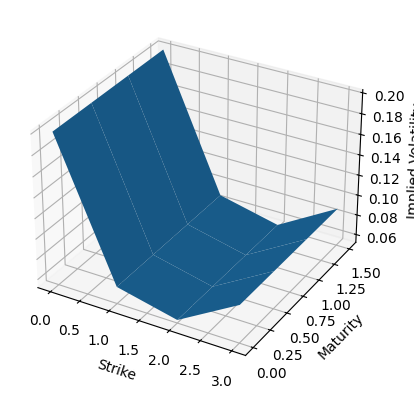

In [213]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import minimize

def heston_simulation(S0, mu, kappa, theta, sigma, rho, T, steps):
    dt = T / steps
    prices = np.zeros(steps)
    volatilities = np.zeros(steps)
    prices[0] = S0
    volatilities[0] = sigma

    for t in range(1, steps):
        dW1 = np.random.normal(0, np.sqrt(dt))
        dW2 = rho * dW1 + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt))
        
        volatilities[t] = volatilities[t-1] + kappa * (theta - volatilities[t-1]) * dt + sigma * np.sqrt(volatilities[t-1]) * dW2
        prices[t] = prices[t-1] * np.exp((mu - 0.5 * volatilities[t-1]) * dt + np.sqrt(volatilities[t-1]) * dW1)
    
    return prices, volatilities

def generate_yield_curve():
    return lambda t: 0.05  # Example flat yield curve

def discount_factor(yield_curve, t):
    return np.exp(-yield_curve(t) * t)

def calculate_greeks(prices, volatilities, notional):
    delta = (prices[-1] - prices[0]) / (notional * (prices[-1] - prices[0]))
    gamma = (delta - (prices[-2] - prices[1]) / (notional * (prices[-2] - prices[1]))) / (notional * (prices[-1] - prices[0]))
    vega = np.std(volatilities) * np.sqrt(len(prices))
    theta = (prices[-1] - prices[0]) / len(prices)
    rho = (prices[-1] - prices[0]) / (0.01 * len(prices))

    return {
        'Delta': delta,
        'Gamma': gamma,
        'Vega': vega,
        'Theta': theta,
        'Rho': rho
    }

def calculate_pnl_attribution(prices, volatilities):
    pnl = prices[-1] - prices[0]
    market_movement = np.sum(np.diff(prices))
    model_adjustments = pnl - market_movement
    
    return {
        'PnL': pnl,
        'Market Movement': market_movement,
        'Model Adjustments': model_adjustments
    }

def calculate_hedging_ratios(prices, volatilities):
    hedge_ratio = np.cov(prices, volatilities)[0, 1] / np.var(volatilities)
    return hedge_ratio

def calculate_risk_metrics(prices):
    returns = np.diff(prices) / prices[:-1]
    var_95 = np.percentile(returns, 5)
    es_95 = np.mean(returns[returns <= var_95])
    return {
        'VaR(95%)': var_95,
        'ES(95%)': es_95
    }

def price_equity_swap_heston(notional, fixed_rate, mu, kappa, theta, sigma, rho, payment_dates, valuation_date, dividend_yield, transaction_fee, credit_spread, currency_exchange_rate):
    yield_curve = generate_yield_curve()
    time_factors = [(date - valuation_date).days / 365.0 for date in payment_dates]

    equity_returns, volatilities = heston_simulation(1, mu, kappa, theta, sigma, rho, time_factors[-1], len(payment_dates))

    equity_returns = equity_returns * (1 + dividend_yield)
    equity_returns = equity_returns * (1 - transaction_fee)
    discount_factors = [discount_factor(yield_curve, t) * np.exp(-credit_spread * t) for t in time_factors]

    fixed_leg_pv = sum(notional * fixed_rate * df for df in discount_factors)
    equity_leg_pv = sum(notional * ret * df for ret, df in zip(equity_returns, discount_factors))

    npv = (equity_leg_pv - fixed_leg_pv) * currency_exchange_rate
    
    greeks = calculate_greeks(equity_returns, volatilities, notional)
    pnl_attribution = calculate_pnl_attribution(equity_returns, volatilities)
    hedging_ratios = calculate_hedging_ratios(equity_returns, volatilities)
    risk_metrics = calculate_risk_metrics(equity_returns)

    return npv, greeks, volatilities, pnl_attribution, hedging_ratios, risk_metrics

def plot_volatility_surface(volatilities, payment_dates):
    x = np.arange(len(volatilities))
    y = np.array([(date - payment_dates[0]).days / 365.0 for date in payment_dates])
    X, Y = np.meshgrid(x, y)
    Z = np.array([volatilities for _ in range(len(payment_dates))])  # Ensure Z is 2D
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z)
    ax.set_xlabel('Strike')
    ax.set_ylabel('Maturity')
    ax.set_zlabel('Implied Volatility')
    plt.show()

# Example usage with Heston model parameters
notional = 1000000
fixed_rate = 0.05
mu = 0.07
kappa = 2.0
theta = 0.04
sigma = 0.2
rho = -0.5
dividend_yield = 0.02
transaction_fee = 0.001
credit_spread = 0.01
currency_exchange_rate = 1.1
payment_dates = [datetime(2024, 6, 1), datetime(2024, 12, 1), datetime(2025, 6, 1), datetime(2025, 12, 1)]
valuation_date = datetime(2024, 1, 1)

npv, greeks, volatilities, pnl_attribution, hedging_ratios, risk_metrics = price_equity_swap_heston(
    notional, fixed_rate, mu, kappa, theta, sigma, rho, payment_dates, valuation_date, 
    dividend_yield, transaction_fee, credit_spread, currency_exchange_rate
)
print(f"The net present value of the equity swap with Heston model is: {npv:.2f}")
print(f"Greeks: {greeks}")
print(f"PnL Attribution: {pnl_attribution}")
print(f"Hedging Ratios: {hedging_ratios}")
print(f"Risk Metrics: {risk_metrics}")

plot_volatility_surface(volatilities, payment_dates)

May work more on greeks 

# Heston Model Equity Swap Pricing

This repository contains a Python implementation for pricing equity swaps using the **Heston model** for stochastic volatility. The code simulates the dynamics of equity prices and volatility, calculates key derivatives (Greeks), risk metrics (Value-at-Risk, Expected Shortfall), and performs PnL attribution. The code also includes functions to model the volatility surface and assess hedging ratios.

## Features

- **Heston Model Simulation**: Simulates equity price dynamics with stochastic volatility using the Heston model.
- **Equity Swap Pricing**: Prices an equity swap with fixed and floating legs, incorporating transaction fees, credit spreads, and currency exchange rates.
- **Greeks Calculation**: Calculates key options Greeks: Delta, Gamma, Vega, Theta, and Rho.
- **Risk Metrics**: Computes Value-at-Risk (VaR) and Expected Shortfall (ES) at a 95% confidence level.
- **PnL Attribution**: Breaks down the PnL into market movement and model adjustments.
- **Volatility Surface Plotting**: Generates a 3D volatility surface plot to visualize the relationship between strike price, maturity, and volatility.

## Requirements

The following Python libraries are required to run the code:

- `numpy`
- `scipy`
- `matplotlib`
- `datetime`

You can install the required libraries using `pip`:

```bash
pip install numpy scipy matplotlib
```

## Functions

### `heston_simulation(S0, mu, kappa, theta, sigma, rho, T, steps)`
Simulates equity price and volatility paths using the **Heston model** for stochastic volatility.

**Parameters**:
- `S0`: Initial stock price
- `mu`: Drift (expected return of the asset)
- `kappa`: Mean reversion speed of volatility
- `theta`: Long-term volatility level
- `sigma`: Volatility of volatility
- `rho`: Correlation between asset price and volatility
- `T`: Time to maturity (in years)
- `steps`: Number of time steps in the simulation

**Returns**:
- Simulated equity price and volatility paths.

### `generate_yield_curve()`
Generates a flat yield curve with a constant interest rate (default = 5%).

**Returns**:
- A lambda function representing the yield curve.

### `discount_factor(yield_curve, t)`
Calculates the discount factor based on the provided yield curve.

**Parameters**:
- `yield_curve`: A function representing the yield curve
- `t`: Time (in years)

**Returns**:
- The discount factor at time `t`.

### `calculate_greeks(prices, volatilities, notional)`
Calculates the option Greeks (Delta, Gamma, Vega, Theta, Rho) for the equity swap.

**Parameters**:
- `prices`: Simulated equity prices
- `volatilities`: Simulated volatility values
- `notional`: The notional value of the swap

**Returns**:
- A dictionary containing the Greeks.

### `calculate_pnl_attribution(prices, volatilities)`
Performs PnL attribution by separating market movement and model adjustments.

**Parameters**:
- `prices`: Simulated equity prices
- `volatilities`: Simulated volatility values

**Returns**:
- A dictionary with the PnL, market movement, and model adjustments.

### `calculate_hedging_ratios(prices, volatilities)`
Calculates the hedge ratio between equity prices and volatilities.

**Parameters**:
- `prices`: Simulated equity prices
- `volatilities`: Simulated volatility values

**Returns**:
- The calculated hedge ratio.

### `calculate_risk_metrics(prices)`
Calculates risk metrics, including **VaR(95%)** and **ES(95%)**, based on the simulated equity prices.

**Parameters**:
- `prices`: Simulated equity prices

**Returns**:
- A dictionary with the VaR and ES at a 95% confidence level.

### `price_equity_swap_heston(notional, fixed_rate, mu, kappa, theta, sigma, rho, payment_dates, valuation_date, dividend_yield, transaction_fee, credit_spread, currency_exchange_rate)`
Prices the equity swap using the Heston model for stochastic volatility. This function takes into account transaction fees, credit spreads, and currency exchange rates.

**Parameters**:
- `notional`: The notional amount of the swap
- `fixed_rate`: The fixed leg rate of the swap
- `mu`: Drift of the underlying asset
- `kappa`: Mean reversion speed of volatility
- `theta`: Long-term volatility
- `sigma`: Volatility of volatility
- `rho`: Correlation between the asset and volatility
- `payment_dates`: List of payment dates
- `valuation_date`: The date of valuation
- `dividend_yield`: The dividend yield of the underlying asset
- `transaction_fee`: Transaction fee as a percentage
- `credit_spread`: Credit spread in the swap pricing
- `currency_exchange_rate`: The exchange rate for currency conversion

**Returns**:
- Net present value (NPV) of the equity swap, Greeks, volatility path, PnL attribution, hedging ratios, and risk metrics.

### `plot_volatility_surface(volatilities, payment_dates)`
Plots a 3D surface showing the volatility surface as a function of strike price and maturity.

**Parameters**:
- `volatilities`: List of volatilities for each payment date
- `payment_dates`: List of payment dates

## Example Usage

```python
notional = 1000000
fixed_rate = 0.05
mu = 0.07
kappa = 2.0
theta = 0.04
sigma = 0.2
rho = -0.5
dividend_yield = 0.02
transaction_fee = 0.001
credit_spread = 0.01
currency_exchange_rate = 1.1
payment_dates = [datetime(2024, 6, 1), datetime(2024, 12, 1), datetime(2025, 6, 1), datetime(2025, 12, 1)]
valuation_date = datetime(2024, 1, 1)

npv, greeks, volatilities, pnl_attribution, hedging_ratios, risk_metrics = price_equity_swap_heston(
    notional, fixed_rate, mu, kappa, theta, sigma, rho, payment_dates, valuation_date, 
    dividend_yield, transaction_fee, credit_spread, currency_exchange_rate
)

print(f"The net present value of the equity swap is: {npv:.2f}")
print(f"Greeks: {greeks}")
print(f"PnL Attribution: {pnl_attribution}")
print(f"Hedging Ratios: {hedging_ratios}")
print(f"Risk Metrics: {risk_metrics}")

plot_volatility_surface(volatilities, payment_dates)
```

## Output

The output includes:
- The **NPV** of the equity swap.
- A dictionary of **Greeks** (Delta, Gamma, Vega, Theta, Rho).
- **PnL attribution** including market movement and model adjustments.
- **Hedging ratios**.
- **Risk metrics** such as VaR and ES.
- A 3D plot of the **volatility surface**.

## License

This code is licensed under the MIT License. See [LICENSE](LICENSE) for more details.

---
